In [1]:
import pandas as pd
import shapely
import numpy as np
import sys
import torch
import argparse
import random
import math
import os
import warnings
from datetime import datetime
from gensim.models import word2vec
from shapely.geometry import LineString, Polygon
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler# 好处在于可以保存训练集中的参数（均值、方差）
from scipy.stats import stats
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import tqdm
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 999
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
import gc
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [16]:
%run '../codes/self_defined_function.py'

## preprocessing and feature selection
take ArtNr '200032' as example

In [3]:
# load data
df = pd.read_csv('../data/Artikelbewegungen ab 1996.txt', sep=';', encoding = 'ISO-8859-1', header=None)
#df = pd.read_excel('../data/Artikelbewegungen.xlsx')

In [4]:
df = preprocessing(df)

In [5]:
# grid table create
tmp = create_grid_data_for_an_article('200032', df)

In [6]:
# feature selection, only weekday
tmp['weekday'] = tmp.index.weekday

In [7]:
# remove weekend
tmp = tmp[tmp['weekday'] != 5]
tmp = tmp[tmp['weekday'] != 6]

In [9]:
def extract_dataset_from_timeseries(df, targetname = 'Menge', lookback = 5):
    """
    df should not contain the features, which will not used in the traning of the model
    """
    for i in range(lookback):
        df[targetname+'_'+str(i+1)] = df[targetname].shift(i+1)
    cols = df.columns.to_list()
    cols_x = [i for i in cols if i not in [targetname]]
    cols_y = [targetname]
    dat_x = df[cols_x].iloc[lookback:, :].values
    dat_y = df[cols_y].iloc[lookback:, :].values
    return dat_x, dat_y
def extract_dataset_from_timeseries_with_diff(df, targetname = 'Menge', lookback = 5):
    """
    df should not contain the features, which will not used in the traning of the model
    """
    for i in range(lookback):
        df[targetname+'_'+str(i+1)] = df[targetname].shift(i+1)
    if lookback >=5:
        df['diff_1'] = df[targetname+'_'+str(1)] - df[targetname+'_'+str(2)]
        df['diff_2'] = df[targetname+'_'+str(3)] - df[targetname+'_'+str(4)]
        df['diff2_1'] = df['diff_1'] - df['diff_2']
    cols = df.columns.to_list()
    cols_x = [i for i in cols if i not in [targetname]]
    cols_y = [targetname]
    dat_x = df[cols_x].iloc[lookback:, :].values
    dat_y = df[cols_y].iloc[lookback:, :].values
    return dat_x, dat_y

In [10]:
# extract dataset for mlp
dat_x, dat_y = extract_dataset_from_timeseries_with_diff(tmp, lookback = 40)

In [11]:
train_x = dat_x[:2589, :]
test_x = dat_x[2589:, :]
train_y = dat_y[:2589, :].reshape(-1)
test_y = dat_y[2589:, :].reshape(-1)

In [12]:
# save to the local system
np.save('../data/rnn_train_x', train_x)
np.save('../data/rnn_train_y', train_y)
np.save('../data/rnn_test_x', test_x)
np.save('../data/rnn_test_y', test_y)

In [157]:
# extract dataset for lstm
dat_x, dat_y = extract_dataset_from_timeseries(tmp[['Menge']])

In [158]:
train_x = dat_x[:2589, :].reshape(-1, 4, 1)
test_x = dat_x[2589:, :].reshape(-1, 4, 1)
train_y = dat_y[:2589, :].reshape(-1)
test_y = dat_y[2589:, :].reshape(-1)

In [161]:
np.save('../data/rnn_train_x', train_x)
np.save('../data/rnn_train_y', train_y)
np.save('../data/rnn_test_x', test_x)
np.save('../data/rnn_test_y', test_y)

In [115]:
### test data
train_y = train_x[:,1] * 10 + 2 - 3
test_y = test_x[:, 1] * 10 + 2 - 3
np.save('../data/rnn_train_x', train_x)
np.save('../data/rnn_train_y', train_y)
np.save('../data/rnn_test_x', test_x)
np.save('../data/rnn_test_y', test_y)

In [160]:
train_x.shape

(2589, 4, 1)

## train with mlp model

In [ ]:
# run the model
tr_x = '../data/rnn_train_x.npy'
tr_y = '../data/rnn_train_y.npy'
tet_x = '../data/rnn_test_x.npy'
tet_y = '../data/rnn_test_y.npy'
num_epochs = 2000
batch_size = 30
verbose = True
# set models and loss
#model = TS_rnn(num_inp = 1, num_hidden = 32, num_layers = 2, dropout = 0, num_dim_mlp = 16) # (self, num_inp = 13, num_hidden = 64, num_layers = 2, dropout = 0.5, num_dim_mlp = 16)
model = MLP(num_inp = 44, num_hidden = 256, num_hidden2 = 64) # (self, num_inp = 1, num_hidden = 64, num_hidden2 = 16)
#model = TS_rnn()
#loss = PDLoss()
loss = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
# set the scheduler
lamb1 = lambda x: .1**(x//30)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda = lamb1)
# loda data
train = Data(tr_x, tr_y)
test = Data(tet_x, tet_y)
dl_train = DataLoader(train, batch_size = batch_size, shuffle = True)
dl_test = DataLoader(test, batch_size = batch_size, shuffle = True)
#train the model
for epoch in range(num_epochs):
    #scheduler.step()
    model.train()
    train_loss = 0
    counter = 0
    for batch_idx, dat in enumerate(dl_train):
        counter += 1
        # train the model
        optimizer.zero_grad()
        inp, target = dat
        #print('----------------')
        out = model(inp)
        #print(out.squeeze())
        #print(target)
        lo = loss(out.squeeze(), target)
        lo.backward()
        optimizer.step()
        train_loss += lo.data
        if verbose:
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch,
                    batch_idx * batch_size,
                    len(train),
                    100.*batch_idx*batch_size/len(train),
                    lo.data
                    ))
    test_lo = test_model(dl_test, model, loss)
    #hit_rate = significant_test(dl_test, model, loss)
    if verbose:
        # train loss
        print('====> Epoch: {} Average train loss: {:.4f}'.format(
            epoch,
            train_loss/counter
            ))
        # test loss
        print('====> Epoch: {} Average test loss: {:.4f}'.format(
            epoch,
            test_lo
            ))
        # significant test
        #print('====> Epoch: {} Average hit rate in 10 candidate: {: .4f}'.format(
        #    epoch,
        #    hit_rate
        #))

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 0 [0/2589 (0%)]	Loss: 1034.118408
Train Epoch: 0 [300/2589 (12%)]	Loss: 1287.755859
Train Epoch: 0 [600/2589 (23%)]	Loss: 857.657104
Train Epoch: 0 [900/2589 (35%)]	Loss: 1040.218750
Train Epoch: 0 [1200/2589 (46%)]	Loss: 1278.734009
Train Epoch: 0 [1500/2589 (58%)]	Loss: 1119.141235
Train Epoch: 0 [1800/2589 (70%)]	Loss: 984.965698
Train Epoch: 0 [2100/2589 (81%)]	Loss: 763.185852
Train Epoch: 0 [2400/2589 (93%)]	Loss: 1194.788208
====> Epoch: 0 Average train loss: 1124.0521
====> Epoch: 0 Average test loss: 1248.1989


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1 [0/2589 (0%)]	Loss: 1058.995361
Train Epoch: 1 [300/2589 (12%)]	Loss: 1365.283447
Train Epoch: 1 [600/2589 (23%)]	Loss: 915.353271
Train Epoch: 1 [900/2589 (35%)]	Loss: 1068.613159
Train Epoch: 1 [1200/2589 (46%)]	Loss: 827.312439
Train Epoch: 1 [1500/2589 (58%)]	Loss: 1011.582031
Train Epoch: 1 [1800/2589 (70%)]	Loss: 836.534302
Train Epoch: 1 [2100/2589 (81%)]	Loss: 1217.847656
Train Epoch: 1 [2400/2589 (93%)]	Loss: 1245.559692
====> Epoch: 1 Average train loss: 940.8314
====> Epoch: 1 Average test loss: 984.0328


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 2 [0/2589 (0%)]	Loss: 974.218140
Train Epoch: 2 [300/2589 (12%)]	Loss: 1053.898926
Train Epoch: 2 [600/2589 (23%)]	Loss: 839.788513
Train Epoch: 2 [900/2589 (35%)]	Loss: 566.921204
Train Epoch: 2 [1200/2589 (46%)]	Loss: 817.167053
Train Epoch: 2 [1500/2589 (58%)]	Loss: 487.572174
Train Epoch: 2 [1800/2589 (70%)]	Loss: 493.112701
Train Epoch: 2 [2100/2589 (81%)]	Loss: 715.618958
Train Epoch: 2 [2400/2589 (93%)]	Loss: 536.647095
====> Epoch: 2 Average train loss: 759.3914
====> Epoch: 2 Average test loss: 902.6270


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 3 [0/2589 (0%)]	Loss: 816.065369
Train Epoch: 3 [300/2589 (12%)]	Loss: 679.389343
Train Epoch: 3 [600/2589 (23%)]	Loss: 799.853577
Train Epoch: 3 [900/2589 (35%)]	Loss: 826.399475
Train Epoch: 3 [1200/2589 (46%)]	Loss: 587.113586
Train Epoch: 3 [1500/2589 (58%)]	Loss: 506.178406
Train Epoch: 3 [1800/2589 (70%)]	Loss: 610.702087
Train Epoch: 3 [2100/2589 (81%)]	Loss: 615.046997
Train Epoch: 3 [2400/2589 (93%)]	Loss: 550.841248
====> Epoch: 3 Average train loss: 689.2419
====> Epoch: 3 Average test loss: 888.2711


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 4 [0/2589 (0%)]	Loss: 726.119263
Train Epoch: 4 [300/2589 (12%)]	Loss: 736.628357
Train Epoch: 4 [600/2589 (23%)]	Loss: 632.222595
Train Epoch: 4 [900/2589 (35%)]	Loss: 741.041077
Train Epoch: 4 [1200/2589 (46%)]	Loss: 820.840454
Train Epoch: 4 [1500/2589 (58%)]	Loss: 697.835083
Train Epoch: 4 [1800/2589 (70%)]	Loss: 725.500244
Train Epoch: 4 [2100/2589 (81%)]	Loss: 488.669830
Train Epoch: 4 [2400/2589 (93%)]	Loss: 746.513062
====> Epoch: 4 Average train loss: 674.1551
====> Epoch: 4 Average test loss: 866.5549


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 5 [0/2589 (0%)]	Loss: 573.769165
Train Epoch: 5 [300/2589 (12%)]	Loss: 709.228882
Train Epoch: 5 [600/2589 (23%)]	Loss: 556.298157
Train Epoch: 5 [900/2589 (35%)]	Loss: 521.945312
Train Epoch: 5 [1200/2589 (46%)]	Loss: 513.300171
Train Epoch: 5 [1500/2589 (58%)]	Loss: 725.674805
Train Epoch: 5 [1800/2589 (70%)]	Loss: 703.434875
Train Epoch: 5 [2100/2589 (81%)]	Loss: 656.334717
Train Epoch: 5 [2400/2589 (93%)]	Loss: 503.350525
====> Epoch: 5 Average train loss: 653.7802
====> Epoch: 5 Average test loss: 869.5367


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 6 [0/2589 (0%)]	Loss: 555.971985
Train Epoch: 6 [300/2589 (12%)]	Loss: 682.222595
Train Epoch: 6 [600/2589 (23%)]	Loss: 596.391418
Train Epoch: 6 [900/2589 (35%)]	Loss: 591.607300
Train Epoch: 6 [1200/2589 (46%)]	Loss: 662.716248
Train Epoch: 6 [1500/2589 (58%)]	Loss: 475.148773
Train Epoch: 6 [1800/2589 (70%)]	Loss: 651.677612
Train Epoch: 6 [2100/2589 (81%)]	Loss: 721.373657
Train Epoch: 6 [2400/2589 (93%)]	Loss: 746.892700
====> Epoch: 6 Average train loss: 641.6806
====> Epoch: 6 Average test loss: 866.9926


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 7 [0/2589 (0%)]	Loss: 618.348999
Train Epoch: 7 [300/2589 (12%)]	Loss: 712.786804
Train Epoch: 7 [600/2589 (23%)]	Loss: 650.264648
Train Epoch: 7 [900/2589 (35%)]	Loss: 656.344971
Train Epoch: 7 [1200/2589 (46%)]	Loss: 658.390869
Train Epoch: 7 [1500/2589 (58%)]	Loss: 531.723633
Train Epoch: 7 [1800/2589 (70%)]	Loss: 708.957336
Train Epoch: 7 [2100/2589 (81%)]	Loss: 600.540100
Train Epoch: 7 [2400/2589 (93%)]	Loss: 657.737915
====> Epoch: 7 Average train loss: 630.3264
====> Epoch: 7 Average test loss: 875.1235


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 8 [0/2589 (0%)]	Loss: 452.755554
Train Epoch: 8 [300/2589 (12%)]	Loss: 547.470520
Train Epoch: 8 [600/2589 (23%)]	Loss: 821.385803
Train Epoch: 8 [900/2589 (35%)]	Loss: 549.443909
Train Epoch: 8 [1200/2589 (46%)]	Loss: 594.273865
Train Epoch: 8 [1500/2589 (58%)]	Loss: 629.631592
Train Epoch: 8 [1800/2589 (70%)]	Loss: 645.890442
Train Epoch: 8 [2100/2589 (81%)]	Loss: 561.455933
Train Epoch: 8 [2400/2589 (93%)]	Loss: 595.500793
====> Epoch: 8 Average train loss: 623.2726
====> Epoch: 8 Average test loss: 881.2080


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 9 [0/2589 (0%)]	Loss: 595.696045
Train Epoch: 9 [300/2589 (12%)]	Loss: 690.179626
Train Epoch: 9 [600/2589 (23%)]	Loss: 728.523438
Train Epoch: 9 [900/2589 (35%)]	Loss: 476.530487
Train Epoch: 9 [1200/2589 (46%)]	Loss: 682.819763
Train Epoch: 9 [1500/2589 (58%)]	Loss: 452.055756
Train Epoch: 9 [1800/2589 (70%)]	Loss: 590.863953
Train Epoch: 9 [2100/2589 (81%)]	Loss: 548.569519
Train Epoch: 9 [2400/2589 (93%)]	Loss: 724.425415
====> Epoch: 9 Average train loss: 608.1130
====> Epoch: 9 Average test loss: 880.1544


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 10 [0/2589 (0%)]	Loss: 486.986816
Train Epoch: 10 [300/2589 (12%)]	Loss: 627.999451
Train Epoch: 10 [600/2589 (23%)]	Loss: 593.190979
Train Epoch: 10 [900/2589 (35%)]	Loss: 597.857666
Train Epoch: 10 [1200/2589 (46%)]	Loss: 560.259888
Train Epoch: 10 [1500/2589 (58%)]	Loss: 618.617859
Train Epoch: 10 [1800/2589 (70%)]	Loss: 408.853394
Train Epoch: 10 [2100/2589 (81%)]	Loss: 624.896240
Train Epoch: 10 [2400/2589 (93%)]	Loss: 638.011841
====> Epoch: 10 Average train loss: 598.1495
====> Epoch: 10 Average test loss: 873.0856


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 11 [0/2589 (0%)]	Loss: 636.713196
Train Epoch: 11 [300/2589 (12%)]	Loss: 454.728790
Train Epoch: 11 [600/2589 (23%)]	Loss: 432.179535
Train Epoch: 11 [900/2589 (35%)]	Loss: 752.641907
Train Epoch: 11 [1200/2589 (46%)]	Loss: 615.634155
Train Epoch: 11 [1500/2589 (58%)]	Loss: 769.405823
Train Epoch: 11 [1800/2589 (70%)]	Loss: 616.921631
Train Epoch: 11 [2100/2589 (81%)]	Loss: 606.082214
Train Epoch: 11 [2400/2589 (93%)]	Loss: 537.269714
====> Epoch: 11 Average train loss: 583.6353
====> Epoch: 11 Average test loss: 884.1157


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 12 [0/2589 (0%)]	Loss: 531.289490
Train Epoch: 12 [300/2589 (12%)]	Loss: 594.013123
Train Epoch: 12 [600/2589 (23%)]	Loss: 529.759033
Train Epoch: 12 [900/2589 (35%)]	Loss: 438.398346
Train Epoch: 12 [1200/2589 (46%)]	Loss: 368.092499
Train Epoch: 12 [1500/2589 (58%)]	Loss: 485.672150
Train Epoch: 12 [1800/2589 (70%)]	Loss: 604.298096
Train Epoch: 12 [2100/2589 (81%)]	Loss: 628.296814
Train Epoch: 12 [2400/2589 (93%)]	Loss: 413.055176
====> Epoch: 12 Average train loss: 576.5279
====> Epoch: 12 Average test loss: 874.9944


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 13 [0/2589 (0%)]	Loss: 456.176849
Train Epoch: 13 [300/2589 (12%)]	Loss: 448.134949
Train Epoch: 13 [600/2589 (23%)]	Loss: 621.687683
Train Epoch: 13 [900/2589 (35%)]	Loss: 584.987671
Train Epoch: 13 [1200/2589 (46%)]	Loss: 647.064819
Train Epoch: 13 [1500/2589 (58%)]	Loss: 517.975708
Train Epoch: 13 [1800/2589 (70%)]	Loss: 621.737915
Train Epoch: 13 [2100/2589 (81%)]	Loss: 490.450195
Train Epoch: 13 [2400/2589 (93%)]	Loss: 665.291382
====> Epoch: 13 Average train loss: 569.4730
====> Epoch: 13 Average test loss: 881.3408


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 14 [0/2589 (0%)]	Loss: 472.963226
Train Epoch: 14 [300/2589 (12%)]	Loss: 647.286560
Train Epoch: 14 [600/2589 (23%)]	Loss: 670.813538
Train Epoch: 14 [900/2589 (35%)]	Loss: 485.149872
Train Epoch: 14 [1200/2589 (46%)]	Loss: 458.461243
Train Epoch: 14 [1500/2589 (58%)]	Loss: 556.832275
Train Epoch: 14 [1800/2589 (70%)]	Loss: 533.122742
Train Epoch: 14 [2100/2589 (81%)]	Loss: 457.956909
Train Epoch: 14 [2400/2589 (93%)]	Loss: 769.373352
====> Epoch: 14 Average train loss: 558.3900
====> Epoch: 14 Average test loss: 883.7785


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 15 [0/2589 (0%)]	Loss: 470.398407
Train Epoch: 15 [300/2589 (12%)]	Loss: 497.408539
Train Epoch: 15 [600/2589 (23%)]	Loss: 769.868774
Train Epoch: 15 [900/2589 (35%)]	Loss: 488.938324
Train Epoch: 15 [1200/2589 (46%)]	Loss: 574.893616
Train Epoch: 15 [1500/2589 (58%)]	Loss: 562.018188
Train Epoch: 15 [1800/2589 (70%)]	Loss: 548.969116
Train Epoch: 15 [2100/2589 (81%)]	Loss: 544.554138
Train Epoch: 15 [2400/2589 (93%)]	Loss: 422.059967
====> Epoch: 15 Average train loss: 551.7845
====> Epoch: 15 Average test loss: 895.6132


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 16 [0/2589 (0%)]	Loss: 533.333679
Train Epoch: 16 [300/2589 (12%)]	Loss: 440.410553
Train Epoch: 16 [600/2589 (23%)]	Loss: 729.725403
Train Epoch: 16 [900/2589 (35%)]	Loss: 477.464966
Train Epoch: 16 [1200/2589 (46%)]	Loss: 648.695068
Train Epoch: 16 [1500/2589 (58%)]	Loss: 556.325012
Train Epoch: 16 [1800/2589 (70%)]	Loss: 396.364136
Train Epoch: 16 [2100/2589 (81%)]	Loss: 537.271484
Train Epoch: 16 [2400/2589 (93%)]	Loss: 668.029419
====> Epoch: 16 Average train loss: 544.1252
====> Epoch: 16 Average test loss: 894.0781


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 17 [0/2589 (0%)]	Loss: 418.173126
Train Epoch: 17 [300/2589 (12%)]	Loss: 428.842773
Train Epoch: 17 [600/2589 (23%)]	Loss: 583.443298
Train Epoch: 17 [900/2589 (35%)]	Loss: 507.480591
Train Epoch: 17 [1200/2589 (46%)]	Loss: 485.887817
Train Epoch: 17 [1500/2589 (58%)]	Loss: 400.461639
Train Epoch: 17 [1800/2589 (70%)]	Loss: 649.962646
Train Epoch: 17 [2100/2589 (81%)]	Loss: 564.781372
Train Epoch: 17 [2400/2589 (93%)]	Loss: 551.142639
====> Epoch: 17 Average train loss: 540.3969
====> Epoch: 17 Average test loss: 889.4615


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 18 [0/2589 (0%)]	Loss: 570.609436
Train Epoch: 18 [300/2589 (12%)]	Loss: 583.955933
Train Epoch: 18 [600/2589 (23%)]	Loss: 541.332153
Train Epoch: 18 [900/2589 (35%)]	Loss: 643.010864
Train Epoch: 18 [1200/2589 (46%)]	Loss: 558.167175
Train Epoch: 18 [1500/2589 (58%)]	Loss: 496.657532
Train Epoch: 18 [1800/2589 (70%)]	Loss: 522.277771
Train Epoch: 18 [2100/2589 (81%)]	Loss: 516.689331
Train Epoch: 18 [2400/2589 (93%)]	Loss: 524.578979
====> Epoch: 18 Average train loss: 531.3946
====> Epoch: 18 Average test loss: 891.0446


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 19 [0/2589 (0%)]	Loss: 666.726196
Train Epoch: 19 [300/2589 (12%)]	Loss: 449.321686
Train Epoch: 19 [600/2589 (23%)]	Loss: 433.826965
Train Epoch: 19 [900/2589 (35%)]	Loss: 371.625031
Train Epoch: 19 [1200/2589 (46%)]	Loss: 611.963135
Train Epoch: 19 [1500/2589 (58%)]	Loss: 494.973907
Train Epoch: 19 [1800/2589 (70%)]	Loss: 483.578156
Train Epoch: 19 [2100/2589 (81%)]	Loss: 606.826843
Train Epoch: 19 [2400/2589 (93%)]	Loss: 616.726196
====> Epoch: 19 Average train loss: 522.7849
====> Epoch: 19 Average test loss: 897.2014


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 20 [0/2589 (0%)]	Loss: 478.045074
Train Epoch: 20 [300/2589 (12%)]	Loss: 656.875916
Train Epoch: 20 [600/2589 (23%)]	Loss: 574.543945
Train Epoch: 20 [900/2589 (35%)]	Loss: 458.922333
Train Epoch: 20 [1200/2589 (46%)]	Loss: 514.171143
Train Epoch: 20 [1500/2589 (58%)]	Loss: 486.906036
Train Epoch: 20 [1800/2589 (70%)]	Loss: 651.012451
Train Epoch: 20 [2100/2589 (81%)]	Loss: 421.139618
Train Epoch: 20 [2400/2589 (93%)]	Loss: 566.788330
====> Epoch: 20 Average train loss: 518.8209
====> Epoch: 20 Average test loss: 899.2273


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 21 [0/2589 (0%)]	Loss: 491.888031
Train Epoch: 21 [300/2589 (12%)]	Loss: 514.692810
Train Epoch: 21 [600/2589 (23%)]	Loss: 554.045166
Train Epoch: 21 [900/2589 (35%)]	Loss: 519.960022
Train Epoch: 21 [1200/2589 (46%)]	Loss: 600.433777
Train Epoch: 21 [1500/2589 (58%)]	Loss: 588.287170
Train Epoch: 21 [1800/2589 (70%)]	Loss: 585.802612
Train Epoch: 21 [2100/2589 (81%)]	Loss: 567.372742
Train Epoch: 21 [2400/2589 (93%)]	Loss: 460.017609
====> Epoch: 21 Average train loss: 510.5963
====> Epoch: 21 Average test loss: 923.9307


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 22 [0/2589 (0%)]	Loss: 740.969543
Train Epoch: 22 [300/2589 (12%)]	Loss: 457.388153
Train Epoch: 22 [600/2589 (23%)]	Loss: 407.566986
Train Epoch: 22 [900/2589 (35%)]	Loss: 510.550262
Train Epoch: 22 [1200/2589 (46%)]	Loss: 658.720337
Train Epoch: 22 [1500/2589 (58%)]	Loss: 524.640991
Train Epoch: 22 [1800/2589 (70%)]	Loss: 456.696289
Train Epoch: 22 [2100/2589 (81%)]	Loss: 518.256042
Train Epoch: 22 [2400/2589 (93%)]	Loss: 394.935120
====> Epoch: 22 Average train loss: 508.6902
====> Epoch: 22 Average test loss: 894.5046


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 23 [0/2589 (0%)]	Loss: 408.072693
Train Epoch: 23 [300/2589 (12%)]	Loss: 454.774384
Train Epoch: 23 [600/2589 (23%)]	Loss: 392.284637
Train Epoch: 23 [900/2589 (35%)]	Loss: 548.875793
Train Epoch: 23 [1200/2589 (46%)]	Loss: 536.004456
Train Epoch: 23 [1500/2589 (58%)]	Loss: 413.383240
Train Epoch: 23 [1800/2589 (70%)]	Loss: 418.218872
Train Epoch: 23 [2100/2589 (81%)]	Loss: 525.714050
Train Epoch: 23 [2400/2589 (93%)]	Loss: 424.650482
====> Epoch: 23 Average train loss: 493.9523
====> Epoch: 23 Average test loss: 891.5113


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 24 [0/2589 (0%)]	Loss: 399.268402
Train Epoch: 24 [300/2589 (12%)]	Loss: 496.805878
Train Epoch: 24 [600/2589 (23%)]	Loss: 437.748749
Train Epoch: 24 [900/2589 (35%)]	Loss: 450.244812
Train Epoch: 24 [1200/2589 (46%)]	Loss: 616.871887
Train Epoch: 24 [1500/2589 (58%)]	Loss: 518.959351
Train Epoch: 24 [1800/2589 (70%)]	Loss: 444.304260
Train Epoch: 24 [2100/2589 (81%)]	Loss: 563.659729
Train Epoch: 24 [2400/2589 (93%)]	Loss: 538.801514
====> Epoch: 24 Average train loss: 490.5856
====> Epoch: 24 Average test loss: 888.0637


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 25 [0/2589 (0%)]	Loss: 352.932526
Train Epoch: 25 [300/2589 (12%)]	Loss: 496.166718
Train Epoch: 25 [600/2589 (23%)]	Loss: 612.908508
Train Epoch: 25 [900/2589 (35%)]	Loss: 428.265228
Train Epoch: 25 [1200/2589 (46%)]	Loss: 492.014191
Train Epoch: 25 [1500/2589 (58%)]	Loss: 563.574768
Train Epoch: 25 [1800/2589 (70%)]	Loss: 576.779175
Train Epoch: 25 [2100/2589 (81%)]	Loss: 605.088196
Train Epoch: 25 [2400/2589 (93%)]	Loss: 419.171722
====> Epoch: 25 Average train loss: 486.4406
====> Epoch: 25 Average test loss: 909.9299


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 26 [0/2589 (0%)]	Loss: 502.263672
Train Epoch: 26 [300/2589 (12%)]	Loss: 391.968475
Train Epoch: 26 [600/2589 (23%)]	Loss: 366.464905
Train Epoch: 26 [900/2589 (35%)]	Loss: 318.835938
Train Epoch: 26 [1200/2589 (46%)]	Loss: 419.401184
Train Epoch: 26 [1500/2589 (58%)]	Loss: 425.918884
Train Epoch: 26 [1800/2589 (70%)]	Loss: 674.927673
Train Epoch: 26 [2100/2589 (81%)]	Loss: 536.488892
Train Epoch: 26 [2400/2589 (93%)]	Loss: 400.106262
====> Epoch: 26 Average train loss: 481.5728
====> Epoch: 26 Average test loss: 903.7350


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 27 [0/2589 (0%)]	Loss: 331.028717
Train Epoch: 27 [300/2589 (12%)]	Loss: 412.798004
Train Epoch: 27 [600/2589 (23%)]	Loss: 529.942566
Train Epoch: 27 [900/2589 (35%)]	Loss: 469.547852
Train Epoch: 27 [1200/2589 (46%)]	Loss: 793.806824
Train Epoch: 27 [1500/2589 (58%)]	Loss: 575.235107
Train Epoch: 27 [1800/2589 (70%)]	Loss: 552.406006
Train Epoch: 27 [2100/2589 (81%)]	Loss: 476.967438
Train Epoch: 27 [2400/2589 (93%)]	Loss: 527.779053
====> Epoch: 27 Average train loss: 474.3504
====> Epoch: 27 Average test loss: 910.5386


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 28 [0/2589 (0%)]	Loss: 437.383942
Train Epoch: 28 [300/2589 (12%)]	Loss: 381.077667
Train Epoch: 28 [600/2589 (23%)]	Loss: 427.767609
Train Epoch: 28 [900/2589 (35%)]	Loss: 502.531921
Train Epoch: 28 [1200/2589 (46%)]	Loss: 315.755554
Train Epoch: 28 [1500/2589 (58%)]	Loss: 559.604431
Train Epoch: 28 [1800/2589 (70%)]	Loss: 632.122742
Train Epoch: 28 [2100/2589 (81%)]	Loss: 339.730927
Train Epoch: 28 [2400/2589 (93%)]	Loss: 381.727539
====> Epoch: 28 Average train loss: 474.9620
====> Epoch: 28 Average test loss: 914.6547


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 29 [0/2589 (0%)]	Loss: 447.295197
Train Epoch: 29 [300/2589 (12%)]	Loss: 338.396393
Train Epoch: 29 [600/2589 (23%)]	Loss: 449.292175
Train Epoch: 29 [900/2589 (35%)]	Loss: 445.609711
Train Epoch: 29 [1200/2589 (46%)]	Loss: 724.316589
Train Epoch: 29 [1500/2589 (58%)]	Loss: 475.128723
Train Epoch: 29 [1800/2589 (70%)]	Loss: 537.919067
Train Epoch: 29 [2100/2589 (81%)]	Loss: 472.842133
Train Epoch: 29 [2400/2589 (93%)]	Loss: 431.181488
====> Epoch: 29 Average train loss: 462.2716
====> Epoch: 29 Average test loss: 923.3673


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 30 [0/2589 (0%)]	Loss: 496.332916
Train Epoch: 30 [300/2589 (12%)]	Loss: 406.037811
Train Epoch: 30 [600/2589 (23%)]	Loss: 341.243713
Train Epoch: 30 [900/2589 (35%)]	Loss: 688.276123
Train Epoch: 30 [1200/2589 (46%)]	Loss: 394.043304
Train Epoch: 30 [1500/2589 (58%)]	Loss: 507.998932
Train Epoch: 30 [1800/2589 (70%)]	Loss: 467.287292
Train Epoch: 30 [2100/2589 (81%)]	Loss: 451.375763
Train Epoch: 30 [2400/2589 (93%)]	Loss: 390.097290
====> Epoch: 30 Average train loss: 461.7606
====> Epoch: 30 Average test loss: 923.9494


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 31 [0/2589 (0%)]	Loss: 689.903381
Train Epoch: 31 [300/2589 (12%)]	Loss: 447.384247
Train Epoch: 31 [600/2589 (23%)]	Loss: 473.419098
Train Epoch: 31 [900/2589 (35%)]	Loss: 351.656372
Train Epoch: 31 [1200/2589 (46%)]	Loss: 331.674622
Train Epoch: 31 [1500/2589 (58%)]	Loss: 384.621094
Train Epoch: 31 [1800/2589 (70%)]	Loss: 361.161194
Train Epoch: 31 [2100/2589 (81%)]	Loss: 382.837006
Train Epoch: 31 [2400/2589 (93%)]	Loss: 483.629486
====> Epoch: 31 Average train loss: 451.5160
====> Epoch: 31 Average test loss: 908.0502


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 32 [0/2589 (0%)]	Loss: 580.896729
Train Epoch: 32 [300/2589 (12%)]	Loss: 435.371887
Train Epoch: 32 [600/2589 (23%)]	Loss: 394.320129
Train Epoch: 32 [900/2589 (35%)]	Loss: 515.434631
Train Epoch: 32 [1200/2589 (46%)]	Loss: 482.433502
Train Epoch: 32 [1500/2589 (58%)]	Loss: 490.144989
Train Epoch: 32 [1800/2589 (70%)]	Loss: 434.217865
Train Epoch: 32 [2100/2589 (81%)]	Loss: 397.243164
Train Epoch: 32 [2400/2589 (93%)]	Loss: 437.529388
====> Epoch: 32 Average train loss: 454.6642
====> Epoch: 32 Average test loss: 919.5469


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 33 [0/2589 (0%)]	Loss: 396.300812
Train Epoch: 33 [300/2589 (12%)]	Loss: 481.021088
Train Epoch: 33 [600/2589 (23%)]	Loss: 712.870972
Train Epoch: 33 [900/2589 (35%)]	Loss: 509.826477
Train Epoch: 33 [1200/2589 (46%)]	Loss: 502.983704
Train Epoch: 33 [1500/2589 (58%)]	Loss: 510.999908
Train Epoch: 33 [1800/2589 (70%)]	Loss: 481.275543
Train Epoch: 33 [2100/2589 (81%)]	Loss: 578.683167
Train Epoch: 33 [2400/2589 (93%)]	Loss: 376.188660
====> Epoch: 33 Average train loss: 455.4979
====> Epoch: 33 Average test loss: 939.0751


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 34 [0/2589 (0%)]	Loss: 630.701172
Train Epoch: 34 [300/2589 (12%)]	Loss: 590.201965
Train Epoch: 34 [600/2589 (23%)]	Loss: 344.553741
Train Epoch: 34 [900/2589 (35%)]	Loss: 420.001953
Train Epoch: 34 [1200/2589 (46%)]	Loss: 438.170837
Train Epoch: 34 [1500/2589 (58%)]	Loss: 394.965485
Train Epoch: 34 [1800/2589 (70%)]	Loss: 510.170868
Train Epoch: 34 [2100/2589 (81%)]	Loss: 447.705200
Train Epoch: 34 [2400/2589 (93%)]	Loss: 385.003326
====> Epoch: 34 Average train loss: 455.3193
====> Epoch: 34 Average test loss: 917.5809


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 35 [0/2589 (0%)]	Loss: 397.451233
Train Epoch: 35 [300/2589 (12%)]	Loss: 595.028076
Train Epoch: 35 [600/2589 (23%)]	Loss: 295.154205
Train Epoch: 35 [900/2589 (35%)]	Loss: 542.652039
Train Epoch: 35 [1200/2589 (46%)]	Loss: 603.904236
Train Epoch: 35 [1500/2589 (58%)]	Loss: 452.173309
Train Epoch: 35 [1800/2589 (70%)]	Loss: 521.700806
Train Epoch: 35 [2100/2589 (81%)]	Loss: 277.345184
Train Epoch: 35 [2400/2589 (93%)]	Loss: 361.925873
====> Epoch: 35 Average train loss: 447.9405
====> Epoch: 35 Average test loss: 919.1805


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 36 [0/2589 (0%)]	Loss: 429.272186
Train Epoch: 36 [300/2589 (12%)]	Loss: 478.994080
Train Epoch: 36 [600/2589 (23%)]	Loss: 339.102997
Train Epoch: 36 [900/2589 (35%)]	Loss: 367.451599
Train Epoch: 36 [1200/2589 (46%)]	Loss: 391.656433
Train Epoch: 36 [1500/2589 (58%)]	Loss: 479.534119
Train Epoch: 36 [1800/2589 (70%)]	Loss: 411.192596
Train Epoch: 36 [2100/2589 (81%)]	Loss: 437.292999
Train Epoch: 36 [2400/2589 (93%)]	Loss: 414.356506
====> Epoch: 36 Average train loss: 448.5386
====> Epoch: 36 Average test loss: 956.6995


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 37 [0/2589 (0%)]	Loss: 381.869354
Train Epoch: 37 [300/2589 (12%)]	Loss: 500.394257
Train Epoch: 37 [600/2589 (23%)]	Loss: 465.971802
Train Epoch: 37 [900/2589 (35%)]	Loss: 404.335175
Train Epoch: 37 [1200/2589 (46%)]	Loss: 525.579224
Train Epoch: 37 [1500/2589 (58%)]	Loss: 258.060638
Train Epoch: 37 [1800/2589 (70%)]	Loss: 605.563416
Train Epoch: 37 [2100/2589 (81%)]	Loss: 444.093781
Train Epoch: 37 [2400/2589 (93%)]	Loss: 474.976166
====> Epoch: 37 Average train loss: 432.4633
====> Epoch: 37 Average test loss: 932.2764


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 38 [0/2589 (0%)]	Loss: 556.752075
Train Epoch: 38 [300/2589 (12%)]	Loss: 421.933685
Train Epoch: 38 [600/2589 (23%)]	Loss: 543.056763
Train Epoch: 38 [900/2589 (35%)]	Loss: 517.417725
Train Epoch: 38 [1200/2589 (46%)]	Loss: 431.864960
Train Epoch: 38 [1500/2589 (58%)]	Loss: 365.041382
Train Epoch: 38 [1800/2589 (70%)]	Loss: 331.848846
Train Epoch: 38 [2100/2589 (81%)]	Loss: 535.440857
Train Epoch: 38 [2400/2589 (93%)]	Loss: 356.988220
====> Epoch: 38 Average train loss: 434.5523
====> Epoch: 38 Average test loss: 934.4127


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 39 [0/2589 (0%)]	Loss: 390.810730
Train Epoch: 39 [300/2589 (12%)]	Loss: 431.963287
Train Epoch: 39 [600/2589 (23%)]	Loss: 581.601501
Train Epoch: 39 [900/2589 (35%)]	Loss: 507.851471
Train Epoch: 39 [1200/2589 (46%)]	Loss: 443.084045
Train Epoch: 39 [1500/2589 (58%)]	Loss: 389.443420
Train Epoch: 39 [1800/2589 (70%)]	Loss: 347.964447
Train Epoch: 39 [2100/2589 (81%)]	Loss: 486.851868
Train Epoch: 39 [2400/2589 (93%)]	Loss: 459.067230
====> Epoch: 39 Average train loss: 429.9722
====> Epoch: 39 Average test loss: 930.3264


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 40 [0/2589 (0%)]	Loss: 378.117371
Train Epoch: 40 [300/2589 (12%)]	Loss: 364.171661
Train Epoch: 40 [600/2589 (23%)]	Loss: 465.545776
Train Epoch: 40 [900/2589 (35%)]	Loss: 482.313293
Train Epoch: 40 [1200/2589 (46%)]	Loss: 334.468231
Train Epoch: 40 [1500/2589 (58%)]	Loss: 399.151367
Train Epoch: 40 [1800/2589 (70%)]	Loss: 381.297272
Train Epoch: 40 [2100/2589 (81%)]	Loss: 437.088470
Train Epoch: 40 [2400/2589 (93%)]	Loss: 323.961823
====> Epoch: 40 Average train loss: 427.6449
====> Epoch: 40 Average test loss: 939.4470


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 41 [0/2589 (0%)]	Loss: 342.215271
Train Epoch: 41 [300/2589 (12%)]	Loss: 330.022949
Train Epoch: 41 [600/2589 (23%)]	Loss: 272.620239
Train Epoch: 41 [900/2589 (35%)]	Loss: 597.907104
Train Epoch: 41 [1200/2589 (46%)]	Loss: 364.971161
Train Epoch: 41 [1500/2589 (58%)]	Loss: 406.633881
Train Epoch: 41 [1800/2589 (70%)]	Loss: 474.479370
Train Epoch: 41 [2100/2589 (81%)]	Loss: 470.766388
Train Epoch: 41 [2400/2589 (93%)]	Loss: 386.157288
====> Epoch: 41 Average train loss: 433.5561
====> Epoch: 41 Average test loss: 923.5214


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 42 [0/2589 (0%)]	Loss: 429.766632
Train Epoch: 42 [300/2589 (12%)]	Loss: 337.348145
Train Epoch: 42 [600/2589 (23%)]	Loss: 352.853699
Train Epoch: 42 [900/2589 (35%)]	Loss: 347.124847
Train Epoch: 42 [1200/2589 (46%)]	Loss: 388.192322
Train Epoch: 42 [1500/2589 (58%)]	Loss: 313.467346
Train Epoch: 42 [1800/2589 (70%)]	Loss: 561.742981
Train Epoch: 42 [2100/2589 (81%)]	Loss: 509.624542
Train Epoch: 42 [2400/2589 (93%)]	Loss: 453.902710
====> Epoch: 42 Average train loss: 419.3669
====> Epoch: 42 Average test loss: 950.0268


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 43 [0/2589 (0%)]	Loss: 454.395782
Train Epoch: 43 [300/2589 (12%)]	Loss: 405.255798
Train Epoch: 43 [600/2589 (23%)]	Loss: 443.124481
Train Epoch: 43 [900/2589 (35%)]	Loss: 316.200562
Train Epoch: 43 [1200/2589 (46%)]	Loss: 418.155426
Train Epoch: 43 [1500/2589 (58%)]	Loss: 465.228210
Train Epoch: 43 [1800/2589 (70%)]	Loss: 492.096741
Train Epoch: 43 [2100/2589 (81%)]	Loss: 531.669800
Train Epoch: 43 [2400/2589 (93%)]	Loss: 431.767517
====> Epoch: 43 Average train loss: 422.6905
====> Epoch: 43 Average test loss: 960.6830


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 44 [0/2589 (0%)]	Loss: 429.146484
Train Epoch: 44 [300/2589 (12%)]	Loss: 573.921265
Train Epoch: 44 [600/2589 (23%)]	Loss: 559.931091
Train Epoch: 44 [900/2589 (35%)]	Loss: 466.347473
Train Epoch: 44 [1200/2589 (46%)]	Loss: 399.746002
Train Epoch: 44 [1500/2589 (58%)]	Loss: 559.840149
Train Epoch: 44 [1800/2589 (70%)]	Loss: 265.004578
Train Epoch: 44 [2100/2589 (81%)]	Loss: 468.669861
Train Epoch: 44 [2400/2589 (93%)]	Loss: 229.796860
====> Epoch: 44 Average train loss: 408.0473
====> Epoch: 44 Average test loss: 952.4708


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 45 [0/2589 (0%)]	Loss: 353.657227
Train Epoch: 45 [300/2589 (12%)]	Loss: 460.925262
Train Epoch: 45 [600/2589 (23%)]	Loss: 216.351883
Train Epoch: 45 [900/2589 (35%)]	Loss: 365.435944
Train Epoch: 45 [1200/2589 (46%)]	Loss: 310.739258
Train Epoch: 45 [1500/2589 (58%)]	Loss: 431.949738
Train Epoch: 45 [1800/2589 (70%)]	Loss: 369.746887
Train Epoch: 45 [2100/2589 (81%)]	Loss: 278.248596
Train Epoch: 45 [2400/2589 (93%)]	Loss: 390.212982
====> Epoch: 45 Average train loss: 417.9800
====> Epoch: 45 Average test loss: 921.5839


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 46 [0/2589 (0%)]	Loss: 305.372375
Train Epoch: 46 [300/2589 (12%)]	Loss: 577.855591
Train Epoch: 46 [600/2589 (23%)]	Loss: 459.664551
Train Epoch: 46 [900/2589 (35%)]	Loss: 397.988831
Train Epoch: 46 [1200/2589 (46%)]	Loss: 339.214508
Train Epoch: 46 [1500/2589 (58%)]	Loss: 313.438202
Train Epoch: 46 [1800/2589 (70%)]	Loss: 307.890594
Train Epoch: 46 [2100/2589 (81%)]	Loss: 465.095520
Train Epoch: 46 [2400/2589 (93%)]	Loss: 423.852844
====> Epoch: 46 Average train loss: 417.3113
====> Epoch: 46 Average test loss: 940.3619


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 47 [0/2589 (0%)]	Loss: 340.624298
Train Epoch: 47 [300/2589 (12%)]	Loss: 312.520721
Train Epoch: 47 [600/2589 (23%)]	Loss: 360.882812
Train Epoch: 47 [900/2589 (35%)]	Loss: 378.416870
Train Epoch: 47 [1200/2589 (46%)]	Loss: 363.983398
Train Epoch: 47 [1500/2589 (58%)]	Loss: 554.953491
Train Epoch: 47 [1800/2589 (70%)]	Loss: 442.536102
Train Epoch: 47 [2100/2589 (81%)]	Loss: 328.149292
Train Epoch: 47 [2400/2589 (93%)]	Loss: 390.757782
====> Epoch: 47 Average train loss: 419.7925
====> Epoch: 47 Average test loss: 933.3900


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 48 [0/2589 (0%)]	Loss: 367.322632
Train Epoch: 48 [300/2589 (12%)]	Loss: 334.337372
Train Epoch: 48 [600/2589 (23%)]	Loss: 506.184143
Train Epoch: 48 [900/2589 (35%)]	Loss: 569.965515
Train Epoch: 48 [1200/2589 (46%)]	Loss: 344.939850
Train Epoch: 48 [1500/2589 (58%)]	Loss: 532.592529
Train Epoch: 48 [1800/2589 (70%)]	Loss: 486.933502
Train Epoch: 48 [2100/2589 (81%)]	Loss: 358.071747
Train Epoch: 48 [2400/2589 (93%)]	Loss: 354.833679
====> Epoch: 48 Average train loss: 407.7558
====> Epoch: 48 Average test loss: 947.2791


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 49 [0/2589 (0%)]	Loss: 751.601746
Train Epoch: 49 [300/2589 (12%)]	Loss: 425.024628
Train Epoch: 49 [600/2589 (23%)]	Loss: 544.692017
Train Epoch: 49 [900/2589 (35%)]	Loss: 377.508820
Train Epoch: 49 [1200/2589 (46%)]	Loss: 381.597839
Train Epoch: 49 [1500/2589 (58%)]	Loss: 439.909760
Train Epoch: 49 [1800/2589 (70%)]	Loss: 385.063782
Train Epoch: 49 [2100/2589 (81%)]	Loss: 483.281921
Train Epoch: 49 [2400/2589 (93%)]	Loss: 691.889099
====> Epoch: 49 Average train loss: 414.2922
====> Epoch: 49 Average test loss: 933.7014


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 50 [0/2589 (0%)]	Loss: 331.261078
Train Epoch: 50 [300/2589 (12%)]	Loss: 445.278595
Train Epoch: 50 [600/2589 (23%)]	Loss: 363.711639
Train Epoch: 50 [900/2589 (35%)]	Loss: 414.095490
Train Epoch: 50 [1200/2589 (46%)]	Loss: 603.718811
Train Epoch: 50 [1500/2589 (58%)]	Loss: 428.832611
Train Epoch: 50 [1800/2589 (70%)]	Loss: 349.428680
Train Epoch: 50 [2100/2589 (81%)]	Loss: 527.004028
Train Epoch: 50 [2400/2589 (93%)]	Loss: 430.179962
====> Epoch: 50 Average train loss: 405.6186
====> Epoch: 50 Average test loss: 929.3186


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 51 [0/2589 (0%)]	Loss: 332.023834
Train Epoch: 51 [300/2589 (12%)]	Loss: 258.500458
Train Epoch: 51 [600/2589 (23%)]	Loss: 291.159210
Train Epoch: 51 [900/2589 (35%)]	Loss: 491.650116
Train Epoch: 51 [1200/2589 (46%)]	Loss: 302.266815
Train Epoch: 51 [1500/2589 (58%)]	Loss: 365.906677
Train Epoch: 51 [1800/2589 (70%)]	Loss: 408.450714
Train Epoch: 51 [2100/2589 (81%)]	Loss: 538.495361
Train Epoch: 51 [2400/2589 (93%)]	Loss: 407.116974
====> Epoch: 51 Average train loss: 402.8474
====> Epoch: 51 Average test loss: 927.4473


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 52 [0/2589 (0%)]	Loss: 334.485077
Train Epoch: 52 [300/2589 (12%)]	Loss: 375.301605
Train Epoch: 52 [600/2589 (23%)]	Loss: 420.879822
Train Epoch: 52 [900/2589 (35%)]	Loss: 414.528320
Train Epoch: 52 [1200/2589 (46%)]	Loss: 342.303162
Train Epoch: 52 [1500/2589 (58%)]	Loss: 310.304718
Train Epoch: 52 [1800/2589 (70%)]	Loss: 377.818390
Train Epoch: 52 [2100/2589 (81%)]	Loss: 502.615814
Train Epoch: 52 [2400/2589 (93%)]	Loss: 481.570862
====> Epoch: 52 Average train loss: 400.0707
====> Epoch: 52 Average test loss: 932.2186


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 53 [0/2589 (0%)]	Loss: 347.422241
Train Epoch: 53 [300/2589 (12%)]	Loss: 319.692810
Train Epoch: 53 [600/2589 (23%)]	Loss: 381.886871
Train Epoch: 53 [900/2589 (35%)]	Loss: 473.079193
Train Epoch: 53 [1200/2589 (46%)]	Loss: 367.219238
Train Epoch: 53 [1500/2589 (58%)]	Loss: 360.682922
Train Epoch: 53 [1800/2589 (70%)]	Loss: 375.509064
Train Epoch: 53 [2100/2589 (81%)]	Loss: 372.823456
Train Epoch: 53 [2400/2589 (93%)]	Loss: 426.322235
====> Epoch: 53 Average train loss: 397.9776
====> Epoch: 53 Average test loss: 938.6765


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 54 [0/2589 (0%)]	Loss: 282.873474
Train Epoch: 54 [300/2589 (12%)]	Loss: 503.159271
Train Epoch: 54 [600/2589 (23%)]	Loss: 379.193970
Train Epoch: 54 [900/2589 (35%)]	Loss: 486.985352
Train Epoch: 54 [1200/2589 (46%)]	Loss: 511.618622
Train Epoch: 54 [1500/2589 (58%)]	Loss: 399.985474
Train Epoch: 54 [1800/2589 (70%)]	Loss: 405.920044
Train Epoch: 54 [2100/2589 (81%)]	Loss: 436.593048
Train Epoch: 54 [2400/2589 (93%)]	Loss: 482.485931
====> Epoch: 54 Average train loss: 395.8831
====> Epoch: 54 Average test loss: 934.9887


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 55 [0/2589 (0%)]	Loss: 331.170074
Train Epoch: 55 [300/2589 (12%)]	Loss: 432.828644
Train Epoch: 55 [600/2589 (23%)]	Loss: 372.601196
Train Epoch: 55 [900/2589 (35%)]	Loss: 378.969910
Train Epoch: 55 [1200/2589 (46%)]	Loss: 534.354675
Train Epoch: 55 [1500/2589 (58%)]	Loss: 309.259155
Train Epoch: 55 [1800/2589 (70%)]	Loss: 327.566864
Train Epoch: 55 [2100/2589 (81%)]	Loss: 285.030457
Train Epoch: 55 [2400/2589 (93%)]	Loss: 481.356934
====> Epoch: 55 Average train loss: 397.8540
====> Epoch: 55 Average test loss: 952.6467


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 56 [0/2589 (0%)]	Loss: 364.100647
Train Epoch: 56 [300/2589 (12%)]	Loss: 367.606567
Train Epoch: 56 [600/2589 (23%)]	Loss: 394.067566
Train Epoch: 56 [900/2589 (35%)]	Loss: 407.238281
Train Epoch: 56 [1200/2589 (46%)]	Loss: 441.078766
Train Epoch: 56 [1500/2589 (58%)]	Loss: 315.025757
Train Epoch: 56 [1800/2589 (70%)]	Loss: 339.470276
Train Epoch: 56 [2100/2589 (81%)]	Loss: 405.202423
Train Epoch: 56 [2400/2589 (93%)]	Loss: 325.666595
====> Epoch: 56 Average train loss: 389.6751
====> Epoch: 56 Average test loss: 940.4711


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 57 [0/2589 (0%)]	Loss: 335.335663
Train Epoch: 57 [300/2589 (12%)]	Loss: 520.671997
Train Epoch: 57 [600/2589 (23%)]	Loss: 354.409393
Train Epoch: 57 [900/2589 (35%)]	Loss: 366.939056
Train Epoch: 57 [1200/2589 (46%)]	Loss: 412.378052
Train Epoch: 57 [1500/2589 (58%)]	Loss: 360.361450
Train Epoch: 57 [1800/2589 (70%)]	Loss: 368.610626
Train Epoch: 57 [2100/2589 (81%)]	Loss: 373.191467
Train Epoch: 57 [2400/2589 (93%)]	Loss: 461.323669
====> Epoch: 57 Average train loss: 386.5832
====> Epoch: 57 Average test loss: 944.3632


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 58 [0/2589 (0%)]	Loss: 308.455841
Train Epoch: 58 [300/2589 (12%)]	Loss: 315.799408
Train Epoch: 58 [600/2589 (23%)]	Loss: 409.783203
Train Epoch: 58 [900/2589 (35%)]	Loss: 463.645325
Train Epoch: 58 [1200/2589 (46%)]	Loss: 424.681915
Train Epoch: 58 [1500/2589 (58%)]	Loss: 318.608887
Train Epoch: 58 [1800/2589 (70%)]	Loss: 332.137878
Train Epoch: 58 [2100/2589 (81%)]	Loss: 373.983582
Train Epoch: 58 [2400/2589 (93%)]	Loss: 422.734070
====> Epoch: 58 Average train loss: 378.1669
====> Epoch: 58 Average test loss: 931.5571


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 59 [0/2589 (0%)]	Loss: 253.799667
Train Epoch: 59 [300/2589 (12%)]	Loss: 421.564789
Train Epoch: 59 [600/2589 (23%)]	Loss: 320.409302
Train Epoch: 59 [900/2589 (35%)]	Loss: 278.421967
Train Epoch: 59 [1200/2589 (46%)]	Loss: 471.866516
Train Epoch: 59 [1500/2589 (58%)]	Loss: 442.690948
Train Epoch: 59 [1800/2589 (70%)]	Loss: 191.873474
Train Epoch: 59 [2100/2589 (81%)]	Loss: 243.693878
Train Epoch: 59 [2400/2589 (93%)]	Loss: 306.223633
====> Epoch: 59 Average train loss: 378.0986
====> Epoch: 59 Average test loss: 937.4637


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 60 [0/2589 (0%)]	Loss: 351.471588
Train Epoch: 60 [300/2589 (12%)]	Loss: 319.410217
Train Epoch: 60 [600/2589 (23%)]	Loss: 336.231262
Train Epoch: 60 [900/2589 (35%)]	Loss: 563.595520
Train Epoch: 60 [1200/2589 (46%)]	Loss: 448.542999
Train Epoch: 60 [1500/2589 (58%)]	Loss: 390.853455
Train Epoch: 60 [1800/2589 (70%)]	Loss: 441.638672
Train Epoch: 60 [2100/2589 (81%)]	Loss: 434.234375
Train Epoch: 60 [2400/2589 (93%)]	Loss: 611.146729
====> Epoch: 60 Average train loss: 380.5029
====> Epoch: 60 Average test loss: 946.6053


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 61 [0/2589 (0%)]	Loss: 330.639099
Train Epoch: 61 [300/2589 (12%)]	Loss: 346.179199
Train Epoch: 61 [600/2589 (23%)]	Loss: 412.868774
Train Epoch: 61 [900/2589 (35%)]	Loss: 426.595428
Train Epoch: 61 [1200/2589 (46%)]	Loss: 420.752106
Train Epoch: 61 [1500/2589 (58%)]	Loss: 294.793579
Train Epoch: 61 [1800/2589 (70%)]	Loss: 341.187683
Train Epoch: 61 [2100/2589 (81%)]	Loss: 365.967804
Train Epoch: 61 [2400/2589 (93%)]	Loss: 339.238770
====> Epoch: 61 Average train loss: 383.1741
====> Epoch: 61 Average test loss: 931.3373


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 62 [0/2589 (0%)]	Loss: 404.834137
Train Epoch: 62 [300/2589 (12%)]	Loss: 276.299225
Train Epoch: 62 [600/2589 (23%)]	Loss: 316.171539
Train Epoch: 62 [900/2589 (35%)]	Loss: 414.005310
Train Epoch: 62 [1200/2589 (46%)]	Loss: 355.992065
Train Epoch: 62 [1500/2589 (58%)]	Loss: 301.906830
Train Epoch: 62 [1800/2589 (70%)]	Loss: 447.850311
Train Epoch: 62 [2100/2589 (81%)]	Loss: 408.031403
Train Epoch: 62 [2400/2589 (93%)]	Loss: 438.114624
====> Epoch: 62 Average train loss: 385.4059
====> Epoch: 62 Average test loss: 947.1248


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 63 [0/2589 (0%)]	Loss: 404.774139
Train Epoch: 63 [300/2589 (12%)]	Loss: 381.236267
Train Epoch: 63 [600/2589 (23%)]	Loss: 385.135376
Train Epoch: 63 [900/2589 (35%)]	Loss: 375.292877
Train Epoch: 63 [1200/2589 (46%)]	Loss: 495.991791
Train Epoch: 63 [1500/2589 (58%)]	Loss: 492.534637
Train Epoch: 63 [1800/2589 (70%)]	Loss: 321.796722
Train Epoch: 63 [2100/2589 (81%)]	Loss: 348.396912
Train Epoch: 63 [2400/2589 (93%)]	Loss: 346.324890
====> Epoch: 63 Average train loss: 371.5776
====> Epoch: 63 Average test loss: 954.6412


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 64 [0/2589 (0%)]	Loss: 299.181335
Train Epoch: 64 [300/2589 (12%)]	Loss: 299.221100
Train Epoch: 64 [600/2589 (23%)]	Loss: 329.250275
Train Epoch: 64 [900/2589 (35%)]	Loss: 363.957367
Train Epoch: 64 [1200/2589 (46%)]	Loss: 402.318817
Train Epoch: 64 [1500/2589 (58%)]	Loss: 343.501038
Train Epoch: 64 [1800/2589 (70%)]	Loss: 519.020630
Train Epoch: 64 [2100/2589 (81%)]	Loss: 484.892426
Train Epoch: 64 [2400/2589 (93%)]	Loss: 353.956757
====> Epoch: 64 Average train loss: 379.4034
====> Epoch: 64 Average test loss: 944.0536


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 65 [0/2589 (0%)]	Loss: 382.848022
Train Epoch: 65 [300/2589 (12%)]	Loss: 352.157623
Train Epoch: 65 [600/2589 (23%)]	Loss: 308.156250
Train Epoch: 65 [900/2589 (35%)]	Loss: 243.945099
Train Epoch: 65 [1200/2589 (46%)]	Loss: 294.443207
Train Epoch: 65 [1500/2589 (58%)]	Loss: 382.883911
Train Epoch: 65 [1800/2589 (70%)]	Loss: 257.612885
Train Epoch: 65 [2100/2589 (81%)]	Loss: 452.560059
Train Epoch: 65 [2400/2589 (93%)]	Loss: 335.281891
====> Epoch: 65 Average train loss: 376.9571
====> Epoch: 65 Average test loss: 932.6029


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 66 [0/2589 (0%)]	Loss: 457.260345
Train Epoch: 66 [300/2589 (12%)]	Loss: 328.321960
Train Epoch: 66 [600/2589 (23%)]	Loss: 333.416443
Train Epoch: 66 [900/2589 (35%)]	Loss: 352.787445
Train Epoch: 66 [1200/2589 (46%)]	Loss: 418.780304
Train Epoch: 66 [1500/2589 (58%)]	Loss: 357.428558
Train Epoch: 66 [1800/2589 (70%)]	Loss: 305.443970
Train Epoch: 66 [2100/2589 (81%)]	Loss: 379.632111
Train Epoch: 66 [2400/2589 (93%)]	Loss: 349.447784
====> Epoch: 66 Average train loss: 380.8258
====> Epoch: 66 Average test loss: 972.6159


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 67 [0/2589 (0%)]	Loss: 440.206360
Train Epoch: 67 [300/2589 (12%)]	Loss: 315.776001
Train Epoch: 67 [600/2589 (23%)]	Loss: 412.694153
Train Epoch: 67 [900/2589 (35%)]	Loss: 358.109283
Train Epoch: 67 [1200/2589 (46%)]	Loss: 428.843353
Train Epoch: 67 [1500/2589 (58%)]	Loss: 386.210266
Train Epoch: 67 [1800/2589 (70%)]	Loss: 286.219543
Train Epoch: 67 [2100/2589 (81%)]	Loss: 246.962387
Train Epoch: 67 [2400/2589 (93%)]	Loss: 353.001862
====> Epoch: 67 Average train loss: 370.8002
====> Epoch: 67 Average test loss: 943.1704


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 68 [0/2589 (0%)]	Loss: 447.586395
Train Epoch: 68 [300/2589 (12%)]	Loss: 326.389679
Train Epoch: 68 [600/2589 (23%)]	Loss: 355.779663
Train Epoch: 68 [900/2589 (35%)]	Loss: 310.422974
Train Epoch: 68 [1200/2589 (46%)]	Loss: 324.364960
Train Epoch: 68 [1500/2589 (58%)]	Loss: 320.248169
Train Epoch: 68 [1800/2589 (70%)]	Loss: 345.482269
Train Epoch: 68 [2100/2589 (81%)]	Loss: 277.572296
Train Epoch: 68 [2400/2589 (93%)]	Loss: 397.440582
====> Epoch: 68 Average train loss: 366.6071
====> Epoch: 68 Average test loss: 968.0443


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 69 [0/2589 (0%)]	Loss: 541.029053
Train Epoch: 69 [300/2589 (12%)]	Loss: 341.365326
Train Epoch: 69 [600/2589 (23%)]	Loss: 228.609833
Train Epoch: 69 [900/2589 (35%)]	Loss: 369.956757
Train Epoch: 69 [1200/2589 (46%)]	Loss: 383.342926
Train Epoch: 69 [1500/2589 (58%)]	Loss: 350.021545
Train Epoch: 69 [1800/2589 (70%)]	Loss: 419.085327
Train Epoch: 69 [2100/2589 (81%)]	Loss: 370.730682
Train Epoch: 69 [2400/2589 (93%)]	Loss: 275.933167
====> Epoch: 69 Average train loss: 367.8340
====> Epoch: 69 Average test loss: 986.7255


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 70 [0/2589 (0%)]	Loss: 409.811646
Train Epoch: 70 [300/2589 (12%)]	Loss: 339.033386
Train Epoch: 70 [600/2589 (23%)]	Loss: 307.887360
Train Epoch: 70 [900/2589 (35%)]	Loss: 305.522003
Train Epoch: 70 [1200/2589 (46%)]	Loss: 293.595642
Train Epoch: 70 [1500/2589 (58%)]	Loss: 393.065918
Train Epoch: 70 [1800/2589 (70%)]	Loss: 374.522919
Train Epoch: 70 [2100/2589 (81%)]	Loss: 341.221680
Train Epoch: 70 [2400/2589 (93%)]	Loss: 403.088928
====> Epoch: 70 Average train loss: 358.8125
====> Epoch: 70 Average test loss: 980.2476


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 71 [0/2589 (0%)]	Loss: 375.746216
Train Epoch: 71 [300/2589 (12%)]	Loss: 266.725861
Train Epoch: 71 [600/2589 (23%)]	Loss: 298.532684
Train Epoch: 71 [900/2589 (35%)]	Loss: 275.714966
Train Epoch: 71 [1200/2589 (46%)]	Loss: 431.133148
Train Epoch: 71 [1500/2589 (58%)]	Loss: 282.981750
Train Epoch: 71 [1800/2589 (70%)]	Loss: 306.288666
Train Epoch: 71 [2100/2589 (81%)]	Loss: 276.776978
Train Epoch: 71 [2400/2589 (93%)]	Loss: 342.010223
====> Epoch: 71 Average train loss: 360.6806
====> Epoch: 71 Average test loss: 935.3177


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 72 [0/2589 (0%)]	Loss: 300.057037
Train Epoch: 72 [300/2589 (12%)]	Loss: 412.033875
Train Epoch: 72 [600/2589 (23%)]	Loss: 368.216125
Train Epoch: 72 [900/2589 (35%)]	Loss: 549.629272
Train Epoch: 72 [1200/2589 (46%)]	Loss: 262.190430
Train Epoch: 72 [1500/2589 (58%)]	Loss: 302.926361
Train Epoch: 72 [1800/2589 (70%)]	Loss: 285.910736
Train Epoch: 72 [2100/2589 (81%)]	Loss: 318.641754
Train Epoch: 72 [2400/2589 (93%)]	Loss: 390.668579
====> Epoch: 72 Average train loss: 352.9947
====> Epoch: 72 Average test loss: 958.4211


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 73 [0/2589 (0%)]	Loss: 405.750854
Train Epoch: 73 [300/2589 (12%)]	Loss: 370.559021
Train Epoch: 73 [600/2589 (23%)]	Loss: 328.243439
Train Epoch: 73 [900/2589 (35%)]	Loss: 295.563660
Train Epoch: 73 [1200/2589 (46%)]	Loss: 340.001892
Train Epoch: 73 [1500/2589 (58%)]	Loss: 403.528412
Train Epoch: 73 [1800/2589 (70%)]	Loss: 431.423248
Train Epoch: 73 [2100/2589 (81%)]	Loss: 464.269226
Train Epoch: 73 [2400/2589 (93%)]	Loss: 447.408020
====> Epoch: 73 Average train loss: 358.3520
====> Epoch: 73 Average test loss: 947.1361


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 74 [0/2589 (0%)]	Loss: 387.756714
Train Epoch: 74 [300/2589 (12%)]	Loss: 480.018616
Train Epoch: 74 [600/2589 (23%)]	Loss: 362.033844
Train Epoch: 74 [900/2589 (35%)]	Loss: 390.848755
Train Epoch: 74 [1200/2589 (46%)]	Loss: 412.233704
Train Epoch: 74 [1500/2589 (58%)]	Loss: 413.491302
Train Epoch: 74 [1800/2589 (70%)]	Loss: 439.350952
Train Epoch: 74 [2100/2589 (81%)]	Loss: 478.650665
Train Epoch: 74 [2400/2589 (93%)]	Loss: 440.214233
====> Epoch: 74 Average train loss: 358.4761
====> Epoch: 74 Average test loss: 935.9888


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 75 [0/2589 (0%)]	Loss: 294.107758
Train Epoch: 75 [300/2589 (12%)]	Loss: 356.330414
Train Epoch: 75 [600/2589 (23%)]	Loss: 305.438171
Train Epoch: 75 [900/2589 (35%)]	Loss: 368.428345
Train Epoch: 75 [1200/2589 (46%)]	Loss: 390.918732
Train Epoch: 75 [1500/2589 (58%)]	Loss: 320.985992
Train Epoch: 75 [1800/2589 (70%)]	Loss: 261.164856
Train Epoch: 75 [2100/2589 (81%)]	Loss: 389.507477
Train Epoch: 75 [2400/2589 (93%)]	Loss: 227.315033
====> Epoch: 75 Average train loss: 361.0345
====> Epoch: 75 Average test loss: 952.7463


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 76 [0/2589 (0%)]	Loss: 257.324249
Train Epoch: 76 [300/2589 (12%)]	Loss: 450.911560
Train Epoch: 76 [600/2589 (23%)]	Loss: 433.782715
Train Epoch: 76 [900/2589 (35%)]	Loss: 335.773438
Train Epoch: 76 [1200/2589 (46%)]	Loss: 329.296997
Train Epoch: 76 [1500/2589 (58%)]	Loss: 266.727661
Train Epoch: 76 [1800/2589 (70%)]	Loss: 408.976501
Train Epoch: 76 [2100/2589 (81%)]	Loss: 429.525208
Train Epoch: 76 [2400/2589 (93%)]	Loss: 295.237732
====> Epoch: 76 Average train loss: 363.3425
====> Epoch: 76 Average test loss: 960.7448


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 77 [0/2589 (0%)]	Loss: 430.064453
Train Epoch: 77 [300/2589 (12%)]	Loss: 458.611816
Train Epoch: 77 [600/2589 (23%)]	Loss: 322.329498
Train Epoch: 77 [900/2589 (35%)]	Loss: 413.234894
Train Epoch: 77 [1200/2589 (46%)]	Loss: 389.392517
Train Epoch: 77 [1500/2589 (58%)]	Loss: 238.908493
Train Epoch: 77 [1800/2589 (70%)]	Loss: 278.094269
Train Epoch: 77 [2100/2589 (81%)]	Loss: 286.462219
Train Epoch: 77 [2400/2589 (93%)]	Loss: 394.942993
====> Epoch: 77 Average train loss: 358.6756
====> Epoch: 77 Average test loss: 934.2775


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 78 [0/2589 (0%)]	Loss: 437.785461
Train Epoch: 78 [300/2589 (12%)]	Loss: 330.567169
Train Epoch: 78 [600/2589 (23%)]	Loss: 403.896759
Train Epoch: 78 [900/2589 (35%)]	Loss: 308.719086
Train Epoch: 78 [1200/2589 (46%)]	Loss: 408.335754
Train Epoch: 78 [1500/2589 (58%)]	Loss: 387.688660
Train Epoch: 78 [1800/2589 (70%)]	Loss: 465.290161
Train Epoch: 78 [2100/2589 (81%)]	Loss: 317.912476
Train Epoch: 78 [2400/2589 (93%)]	Loss: 300.429291
====> Epoch: 78 Average train loss: 357.4406
====> Epoch: 78 Average test loss: 949.5006


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 79 [0/2589 (0%)]	Loss: 394.163910
Train Epoch: 79 [300/2589 (12%)]	Loss: 241.225296
Train Epoch: 79 [600/2589 (23%)]	Loss: 283.330078
Train Epoch: 79 [900/2589 (35%)]	Loss: 398.082397
Train Epoch: 79 [1200/2589 (46%)]	Loss: 326.946991
Train Epoch: 79 [1500/2589 (58%)]	Loss: 418.987030
Train Epoch: 79 [1800/2589 (70%)]	Loss: 227.674377
Train Epoch: 79 [2100/2589 (81%)]	Loss: 303.294098
Train Epoch: 79 [2400/2589 (93%)]	Loss: 300.294586
====> Epoch: 79 Average train loss: 347.3038
====> Epoch: 79 Average test loss: 940.0397


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 80 [0/2589 (0%)]	Loss: 471.675385
Train Epoch: 80 [300/2589 (12%)]	Loss: 326.934265
Train Epoch: 80 [600/2589 (23%)]	Loss: 233.919357
Train Epoch: 80 [900/2589 (35%)]	Loss: 369.890625
Train Epoch: 80 [1200/2589 (46%)]	Loss: 292.379395
Train Epoch: 80 [1500/2589 (58%)]	Loss: 310.795380
Train Epoch: 80 [1800/2589 (70%)]	Loss: 277.603088
Train Epoch: 80 [2100/2589 (81%)]	Loss: 314.207031
Train Epoch: 80 [2400/2589 (93%)]	Loss: 436.382294
====> Epoch: 80 Average train loss: 361.5138
====> Epoch: 80 Average test loss: 979.0884


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 81 [0/2589 (0%)]	Loss: 269.029327
Train Epoch: 81 [300/2589 (12%)]	Loss: 256.295227
Train Epoch: 81 [600/2589 (23%)]	Loss: 408.722748
Train Epoch: 81 [900/2589 (35%)]	Loss: 448.662445
Train Epoch: 81 [1200/2589 (46%)]	Loss: 251.996643
Train Epoch: 81 [1500/2589 (58%)]	Loss: 340.028778
Train Epoch: 81 [1800/2589 (70%)]	Loss: 532.258484
Train Epoch: 81 [2100/2589 (81%)]	Loss: 414.528931
Train Epoch: 81 [2400/2589 (93%)]	Loss: 240.443420
====> Epoch: 81 Average train loss: 346.4799
====> Epoch: 81 Average test loss: 954.8261


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 82 [0/2589 (0%)]	Loss: 283.176361
Train Epoch: 82 [300/2589 (12%)]	Loss: 363.401550
Train Epoch: 82 [600/2589 (23%)]	Loss: 339.144135
Train Epoch: 82 [900/2589 (35%)]	Loss: 261.483978
Train Epoch: 82 [1200/2589 (46%)]	Loss: 381.751404
Train Epoch: 82 [1500/2589 (58%)]	Loss: 342.806366
Train Epoch: 82 [1800/2589 (70%)]	Loss: 295.425751
Train Epoch: 82 [2100/2589 (81%)]	Loss: 363.227844
Train Epoch: 82 [2400/2589 (93%)]	Loss: 257.589630
====> Epoch: 82 Average train loss: 348.2157
====> Epoch: 82 Average test loss: 964.2443


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 83 [0/2589 (0%)]	Loss: 351.148529
Train Epoch: 83 [300/2589 (12%)]	Loss: 366.234985
Train Epoch: 83 [600/2589 (23%)]	Loss: 287.775757
Train Epoch: 83 [900/2589 (35%)]	Loss: 349.365326
Train Epoch: 83 [1200/2589 (46%)]	Loss: 419.030823
Train Epoch: 83 [1500/2589 (58%)]	Loss: 371.236633
Train Epoch: 83 [1800/2589 (70%)]	Loss: 255.483459
Train Epoch: 83 [2100/2589 (81%)]	Loss: 440.393707
Train Epoch: 83 [2400/2589 (93%)]	Loss: 439.175476
====> Epoch: 83 Average train loss: 350.6359
====> Epoch: 83 Average test loss: 955.9120


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 84 [0/2589 (0%)]	Loss: 308.359436
Train Epoch: 84 [300/2589 (12%)]	Loss: 252.608749
Train Epoch: 84 [600/2589 (23%)]	Loss: 305.568939
Train Epoch: 84 [900/2589 (35%)]	Loss: 280.081512
Train Epoch: 84 [1200/2589 (46%)]	Loss: 365.243835
Train Epoch: 84 [1500/2589 (58%)]	Loss: 456.293274
Train Epoch: 84 [1800/2589 (70%)]	Loss: 252.010483
Train Epoch: 84 [2100/2589 (81%)]	Loss: 379.540100
Train Epoch: 84 [2400/2589 (93%)]	Loss: 288.497162
====> Epoch: 84 Average train loss: 346.0239
====> Epoch: 84 Average test loss: 976.0338


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 85 [0/2589 (0%)]	Loss: 259.294952
Train Epoch: 85 [300/2589 (12%)]	Loss: 329.366241
Train Epoch: 85 [600/2589 (23%)]	Loss: 229.135605
Train Epoch: 85 [900/2589 (35%)]	Loss: 312.243927
Train Epoch: 85 [1200/2589 (46%)]	Loss: 353.631226
Train Epoch: 85 [1500/2589 (58%)]	Loss: 298.068665
Train Epoch: 85 [1800/2589 (70%)]	Loss: 298.757172
Train Epoch: 85 [2100/2589 (81%)]	Loss: 344.420471
Train Epoch: 85 [2400/2589 (93%)]	Loss: 274.154266
====> Epoch: 85 Average train loss: 343.3639
====> Epoch: 85 Average test loss: 973.3776


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 86 [0/2589 (0%)]	Loss: 351.937164
Train Epoch: 86 [300/2589 (12%)]	Loss: 213.381149
Train Epoch: 86 [600/2589 (23%)]	Loss: 360.105865
Train Epoch: 86 [900/2589 (35%)]	Loss: 355.804138
Train Epoch: 86 [1200/2589 (46%)]	Loss: 450.591522
Train Epoch: 86 [1500/2589 (58%)]	Loss: 497.863892
Train Epoch: 86 [1800/2589 (70%)]	Loss: 513.873352
Train Epoch: 86 [2100/2589 (81%)]	Loss: 355.827454
Train Epoch: 86 [2400/2589 (93%)]	Loss: 332.820435
====> Epoch: 86 Average train loss: 344.2160
====> Epoch: 86 Average test loss: 974.9186


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 87 [0/2589 (0%)]	Loss: 318.416107
Train Epoch: 87 [300/2589 (12%)]	Loss: 293.608063
Train Epoch: 87 [600/2589 (23%)]	Loss: 419.319946
Train Epoch: 87 [900/2589 (35%)]	Loss: 316.409973
Train Epoch: 87 [1200/2589 (46%)]	Loss: 370.842896
Train Epoch: 87 [1500/2589 (58%)]	Loss: 200.580215
Train Epoch: 87 [1800/2589 (70%)]	Loss: 307.102051
Train Epoch: 87 [2100/2589 (81%)]	Loss: 352.352570
Train Epoch: 87 [2400/2589 (93%)]	Loss: 337.784271
====> Epoch: 87 Average train loss: 341.8547
====> Epoch: 87 Average test loss: 956.3986


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 88 [0/2589 (0%)]	Loss: 348.561310
Train Epoch: 88 [300/2589 (12%)]	Loss: 390.233978
Train Epoch: 88 [600/2589 (23%)]	Loss: 300.088013
Train Epoch: 88 [900/2589 (35%)]	Loss: 430.847046
Train Epoch: 88 [1200/2589 (46%)]	Loss: 348.843719
Train Epoch: 88 [1500/2589 (58%)]	Loss: 317.634277
Train Epoch: 88 [1800/2589 (70%)]	Loss: 417.847260
Train Epoch: 88 [2100/2589 (81%)]	Loss: 202.448441
Train Epoch: 88 [2400/2589 (93%)]	Loss: 322.536407
====> Epoch: 88 Average train loss: 343.0482
====> Epoch: 88 Average test loss: 959.2908


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 89 [0/2589 (0%)]	Loss: 298.095245
Train Epoch: 89 [300/2589 (12%)]	Loss: 223.979599
Train Epoch: 89 [600/2589 (23%)]	Loss: 339.420380
Train Epoch: 89 [900/2589 (35%)]	Loss: 322.971680
Train Epoch: 89 [1200/2589 (46%)]	Loss: 613.030457
Train Epoch: 89 [1500/2589 (58%)]	Loss: 464.721466
Train Epoch: 89 [1800/2589 (70%)]	Loss: 405.562561
Train Epoch: 89 [2100/2589 (81%)]	Loss: 242.089462
Train Epoch: 89 [2400/2589 (93%)]	Loss: 244.121979
====> Epoch: 89 Average train loss: 341.7867
====> Epoch: 89 Average test loss: 958.7591


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 90 [0/2589 (0%)]	Loss: 216.632645
Train Epoch: 90 [300/2589 (12%)]	Loss: 232.249649
Train Epoch: 90 [600/2589 (23%)]	Loss: 313.684235
Train Epoch: 90 [900/2589 (35%)]	Loss: 412.557831
Train Epoch: 90 [1200/2589 (46%)]	Loss: 309.756134
Train Epoch: 90 [1500/2589 (58%)]	Loss: 391.421234
Train Epoch: 90 [1800/2589 (70%)]	Loss: 231.250275
Train Epoch: 90 [2100/2589 (81%)]	Loss: 306.996216
Train Epoch: 90 [2400/2589 (93%)]	Loss: 323.676788
====> Epoch: 90 Average train loss: 339.3578
====> Epoch: 90 Average test loss: 993.0330


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 91 [0/2589 (0%)]	Loss: 319.230377
Train Epoch: 91 [300/2589 (12%)]	Loss: 383.257019
Train Epoch: 91 [600/2589 (23%)]	Loss: 289.664124
Train Epoch: 91 [900/2589 (35%)]	Loss: 331.891602
Train Epoch: 91 [1200/2589 (46%)]	Loss: 400.702850
Train Epoch: 91 [1500/2589 (58%)]	Loss: 411.198029
Train Epoch: 91 [1800/2589 (70%)]	Loss: 393.947754
Train Epoch: 91 [2100/2589 (81%)]	Loss: 422.920197
Train Epoch: 91 [2400/2589 (93%)]	Loss: 335.657166
====> Epoch: 91 Average train loss: 338.4229
====> Epoch: 91 Average test loss: 969.6166


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 92 [0/2589 (0%)]	Loss: 277.503784
Train Epoch: 92 [300/2589 (12%)]	Loss: 245.821625
Train Epoch: 92 [600/2589 (23%)]	Loss: 357.177887
Train Epoch: 92 [900/2589 (35%)]	Loss: 337.430298
Train Epoch: 92 [1200/2589 (46%)]	Loss: 334.425720
Train Epoch: 92 [1500/2589 (58%)]	Loss: 435.879486
Train Epoch: 92 [1800/2589 (70%)]	Loss: 351.593872
Train Epoch: 92 [2100/2589 (81%)]	Loss: 427.033295
Train Epoch: 92 [2400/2589 (93%)]	Loss: 407.475433
====> Epoch: 92 Average train loss: 347.8771
====> Epoch: 92 Average test loss: 938.7603


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 93 [0/2589 (0%)]	Loss: 203.302155
Train Epoch: 93 [300/2589 (12%)]	Loss: 384.976898
Train Epoch: 93 [600/2589 (23%)]	Loss: 265.714417
Train Epoch: 93 [900/2589 (35%)]	Loss: 264.150940
Train Epoch: 93 [1200/2589 (46%)]	Loss: 517.801575
Train Epoch: 93 [1500/2589 (58%)]	Loss: 277.442078
Train Epoch: 93 [1800/2589 (70%)]	Loss: 358.852936
Train Epoch: 93 [2100/2589 (81%)]	Loss: 316.801239
Train Epoch: 93 [2400/2589 (93%)]	Loss: 386.137756
====> Epoch: 93 Average train loss: 339.4553
====> Epoch: 93 Average test loss: 963.2021


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 94 [0/2589 (0%)]	Loss: 502.712433
Train Epoch: 94 [300/2589 (12%)]	Loss: 451.669769
Train Epoch: 94 [600/2589 (23%)]	Loss: 417.321259
Train Epoch: 94 [900/2589 (35%)]	Loss: 248.673615
Train Epoch: 94 [1200/2589 (46%)]	Loss: 270.685394
Train Epoch: 94 [1500/2589 (58%)]	Loss: 387.628235
Train Epoch: 94 [1800/2589 (70%)]	Loss: 265.832947
Train Epoch: 94 [2100/2589 (81%)]	Loss: 447.515076
Train Epoch: 94 [2400/2589 (93%)]	Loss: 365.823364
====> Epoch: 94 Average train loss: 341.1661
====> Epoch: 94 Average test loss: 972.1973


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 95 [0/2589 (0%)]	Loss: 350.875092
Train Epoch: 95 [300/2589 (12%)]	Loss: 364.792847
Train Epoch: 95 [600/2589 (23%)]	Loss: 394.244507
Train Epoch: 95 [900/2589 (35%)]	Loss: 252.724991
Train Epoch: 95 [1200/2589 (46%)]	Loss: 275.572754
Train Epoch: 95 [1500/2589 (58%)]	Loss: 359.697083
Train Epoch: 95 [1800/2589 (70%)]	Loss: 343.412262
Train Epoch: 95 [2100/2589 (81%)]	Loss: 276.612122
Train Epoch: 95 [2400/2589 (93%)]	Loss: 330.155884
====> Epoch: 95 Average train loss: 328.5024
====> Epoch: 95 Average test loss: 949.0389


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 96 [0/2589 (0%)]	Loss: 352.553070
Train Epoch: 96 [300/2589 (12%)]	Loss: 272.498962
Train Epoch: 96 [600/2589 (23%)]	Loss: 336.368256
Train Epoch: 96 [900/2589 (35%)]	Loss: 326.245697
Train Epoch: 96 [1200/2589 (46%)]	Loss: 323.819214
Train Epoch: 96 [1500/2589 (58%)]	Loss: 274.751434
Train Epoch: 96 [1800/2589 (70%)]	Loss: 380.857758
Train Epoch: 96 [2100/2589 (81%)]	Loss: 470.478882
Train Epoch: 96 [2400/2589 (93%)]	Loss: 287.950562
====> Epoch: 96 Average train loss: 332.4037
====> Epoch: 96 Average test loss: 977.4015


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 97 [0/2589 (0%)]	Loss: 251.073303
Train Epoch: 97 [300/2589 (12%)]	Loss: 348.823059
Train Epoch: 97 [600/2589 (23%)]	Loss: 375.643829
Train Epoch: 97 [900/2589 (35%)]	Loss: 317.860474
Train Epoch: 97 [1200/2589 (46%)]	Loss: 312.276672
Train Epoch: 97 [1500/2589 (58%)]	Loss: 286.287170
Train Epoch: 97 [1800/2589 (70%)]	Loss: 263.274475
Train Epoch: 97 [2100/2589 (81%)]	Loss: 307.288574
Train Epoch: 97 [2400/2589 (93%)]	Loss: 239.611191
====> Epoch: 97 Average train loss: 340.5896
====> Epoch: 97 Average test loss: 974.9793


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 98 [0/2589 (0%)]	Loss: 350.837738
Train Epoch: 98 [300/2589 (12%)]	Loss: 477.356659
Train Epoch: 98 [600/2589 (23%)]	Loss: 567.165649
Train Epoch: 98 [900/2589 (35%)]	Loss: 306.927643
Train Epoch: 98 [1200/2589 (46%)]	Loss: 459.943970
Train Epoch: 98 [1500/2589 (58%)]	Loss: 289.097137
Train Epoch: 98 [1800/2589 (70%)]	Loss: 313.999542
Train Epoch: 98 [2100/2589 (81%)]	Loss: 409.659149
Train Epoch: 98 [2400/2589 (93%)]	Loss: 287.987488
====> Epoch: 98 Average train loss: 345.6075
====> Epoch: 98 Average test loss: 938.5838


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 99 [0/2589 (0%)]	Loss: 288.890900
Train Epoch: 99 [300/2589 (12%)]	Loss: 363.316864
Train Epoch: 99 [600/2589 (23%)]	Loss: 343.580139
Train Epoch: 99 [900/2589 (35%)]	Loss: 301.471954
Train Epoch: 99 [1200/2589 (46%)]	Loss: 277.727814
Train Epoch: 99 [1500/2589 (58%)]	Loss: 324.176697
Train Epoch: 99 [1800/2589 (70%)]	Loss: 382.231476
Train Epoch: 99 [2100/2589 (81%)]	Loss: 368.551605
Train Epoch: 99 [2400/2589 (93%)]	Loss: 233.863052
====> Epoch: 99 Average train loss: 351.5699
====> Epoch: 99 Average test loss: 952.3362


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 100 [0/2589 (0%)]	Loss: 306.996796
Train Epoch: 100 [300/2589 (12%)]	Loss: 257.034241
Train Epoch: 100 [600/2589 (23%)]	Loss: 325.716339
Train Epoch: 100 [900/2589 (35%)]	Loss: 362.103424
Train Epoch: 100 [1200/2589 (46%)]	Loss: 447.285370
Train Epoch: 100 [1500/2589 (58%)]	Loss: 416.342621
Train Epoch: 100 [1800/2589 (70%)]	Loss: 253.028458
Train Epoch: 100 [2100/2589 (81%)]	Loss: 334.235901
Train Epoch: 100 [2400/2589 (93%)]	Loss: 297.031525
====> Epoch: 100 Average train loss: 338.4789
====> Epoch: 100 Average test loss: 927.6988


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 101 [0/2589 (0%)]	Loss: 284.198456
Train Epoch: 101 [300/2589 (12%)]	Loss: 395.399597
Train Epoch: 101 [600/2589 (23%)]	Loss: 309.725403
Train Epoch: 101 [900/2589 (35%)]	Loss: 417.389038
Train Epoch: 101 [1200/2589 (46%)]	Loss: 299.280457
Train Epoch: 101 [1500/2589 (58%)]	Loss: 316.676697
Train Epoch: 101 [1800/2589 (70%)]	Loss: 284.095978
Train Epoch: 101 [2100/2589 (81%)]	Loss: 297.459351
Train Epoch: 101 [2400/2589 (93%)]	Loss: 391.176178
====> Epoch: 101 Average train loss: 322.4482
====> Epoch: 101 Average test loss: 932.8209


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 102 [0/2589 (0%)]	Loss: 327.457214
Train Epoch: 102 [300/2589 (12%)]	Loss: 284.071106
Train Epoch: 102 [600/2589 (23%)]	Loss: 305.860626
Train Epoch: 102 [900/2589 (35%)]	Loss: 463.685211
Train Epoch: 102 [1200/2589 (46%)]	Loss: 524.869568
Train Epoch: 102 [1500/2589 (58%)]	Loss: 235.557312
Train Epoch: 102 [1800/2589 (70%)]	Loss: 245.196228
Train Epoch: 102 [2100/2589 (81%)]	Loss: 341.427917
Train Epoch: 102 [2400/2589 (93%)]	Loss: 370.680847
====> Epoch: 102 Average train loss: 332.1342
====> Epoch: 102 Average test loss: 930.3229


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 103 [0/2589 (0%)]	Loss: 287.848969
Train Epoch: 103 [300/2589 (12%)]	Loss: 334.568481
Train Epoch: 103 [600/2589 (23%)]	Loss: 327.785767
Train Epoch: 103 [900/2589 (35%)]	Loss: 273.671417
Train Epoch: 103 [1200/2589 (46%)]	Loss: 250.770508
Train Epoch: 103 [1500/2589 (58%)]	Loss: 362.921082
Train Epoch: 103 [1800/2589 (70%)]	Loss: 309.932526
Train Epoch: 103 [2100/2589 (81%)]	Loss: 282.447205
Train Epoch: 103 [2400/2589 (93%)]	Loss: 259.774017
====> Epoch: 103 Average train loss: 324.7520
====> Epoch: 103 Average test loss: 982.3641


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 104 [0/2589 (0%)]	Loss: 387.161682
Train Epoch: 104 [300/2589 (12%)]	Loss: 336.715881
Train Epoch: 104 [600/2589 (23%)]	Loss: 360.399139
Train Epoch: 104 [900/2589 (35%)]	Loss: 447.540680
Train Epoch: 104 [1200/2589 (46%)]	Loss: 341.497955
Train Epoch: 104 [1500/2589 (58%)]	Loss: 427.376740
Train Epoch: 104 [1800/2589 (70%)]	Loss: 268.785614
Train Epoch: 104 [2100/2589 (81%)]	Loss: 382.364441
Train Epoch: 104 [2400/2589 (93%)]	Loss: 386.465881
====> Epoch: 104 Average train loss: 333.2766
====> Epoch: 104 Average test loss: 953.7135


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 105 [0/2589 (0%)]	Loss: 270.092224
Train Epoch: 105 [300/2589 (12%)]	Loss: 305.460938
Train Epoch: 105 [600/2589 (23%)]	Loss: 353.750977
Train Epoch: 105 [900/2589 (35%)]	Loss: 281.756714
Train Epoch: 105 [1200/2589 (46%)]	Loss: 307.747437
Train Epoch: 105 [1500/2589 (58%)]	Loss: 274.484833
Train Epoch: 105 [1800/2589 (70%)]	Loss: 537.868469
Train Epoch: 105 [2100/2589 (81%)]	Loss: 381.689178
Train Epoch: 105 [2400/2589 (93%)]	Loss: 280.623413
====> Epoch: 105 Average train loss: 326.5977
====> Epoch: 105 Average test loss: 936.0273


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 106 [0/2589 (0%)]	Loss: 423.344543
Train Epoch: 106 [300/2589 (12%)]	Loss: 261.251740
Train Epoch: 106 [600/2589 (23%)]	Loss: 257.442078
Train Epoch: 106 [900/2589 (35%)]	Loss: 342.316010
Train Epoch: 106 [1200/2589 (46%)]	Loss: 319.360016
Train Epoch: 106 [1500/2589 (58%)]	Loss: 281.915436
Train Epoch: 106 [1800/2589 (70%)]	Loss: 348.875854
Train Epoch: 106 [2100/2589 (81%)]	Loss: 318.358063
Train Epoch: 106 [2400/2589 (93%)]	Loss: 440.222534
====> Epoch: 106 Average train loss: 316.2711
====> Epoch: 106 Average test loss: 957.2432


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 107 [0/2589 (0%)]	Loss: 217.402649
Train Epoch: 107 [300/2589 (12%)]	Loss: 319.551971
Train Epoch: 107 [600/2589 (23%)]	Loss: 366.684265
Train Epoch: 107 [900/2589 (35%)]	Loss: 321.874786
Train Epoch: 107 [1200/2589 (46%)]	Loss: 294.181000
Train Epoch: 107 [1500/2589 (58%)]	Loss: 281.948853
Train Epoch: 107 [1800/2589 (70%)]	Loss: 273.302277
Train Epoch: 107 [2100/2589 (81%)]	Loss: 278.272156
Train Epoch: 107 [2400/2589 (93%)]	Loss: 240.628616
====> Epoch: 107 Average train loss: 323.8973
====> Epoch: 107 Average test loss: 970.4144


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 108 [0/2589 (0%)]	Loss: 479.482727
Train Epoch: 108 [300/2589 (12%)]	Loss: 674.266602
Train Epoch: 108 [600/2589 (23%)]	Loss: 388.174164
Train Epoch: 108 [900/2589 (35%)]	Loss: 306.769226
Train Epoch: 108 [1200/2589 (46%)]	Loss: 542.086548
Train Epoch: 108 [1500/2589 (58%)]	Loss: 327.756348
Train Epoch: 108 [1800/2589 (70%)]	Loss: 403.982849
Train Epoch: 108 [2100/2589 (81%)]	Loss: 335.222229
Train Epoch: 108 [2400/2589 (93%)]	Loss: 437.792419
====> Epoch: 108 Average train loss: 342.1807
====> Epoch: 108 Average test loss: 948.9755


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 109 [0/2589 (0%)]	Loss: 362.037933
Train Epoch: 109 [300/2589 (12%)]	Loss: 294.728668
Train Epoch: 109 [600/2589 (23%)]	Loss: 344.154724
Train Epoch: 109 [900/2589 (35%)]	Loss: 383.555878
Train Epoch: 109 [1200/2589 (46%)]	Loss: 310.419128
Train Epoch: 109 [1500/2589 (58%)]	Loss: 335.156250
Train Epoch: 109 [1800/2589 (70%)]	Loss: 247.145279
Train Epoch: 109 [2100/2589 (81%)]	Loss: 276.122467
Train Epoch: 109 [2400/2589 (93%)]	Loss: 377.765930
====> Epoch: 109 Average train loss: 325.0555
====> Epoch: 109 Average test loss: 972.3555


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 110 [0/2589 (0%)]	Loss: 307.829437
Train Epoch: 110 [300/2589 (12%)]	Loss: 341.949097
Train Epoch: 110 [600/2589 (23%)]	Loss: 298.095917
Train Epoch: 110 [900/2589 (35%)]	Loss: 391.015350
Train Epoch: 110 [1200/2589 (46%)]	Loss: 322.035034
Train Epoch: 110 [1500/2589 (58%)]	Loss: 249.613449
Train Epoch: 110 [1800/2589 (70%)]	Loss: 351.620270
Train Epoch: 110 [2100/2589 (81%)]	Loss: 268.743103
Train Epoch: 110 [2400/2589 (93%)]	Loss: 211.049667
====> Epoch: 110 Average train loss: 333.3139
====> Epoch: 110 Average test loss: 948.4443


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 111 [0/2589 (0%)]	Loss: 346.575195
Train Epoch: 111 [300/2589 (12%)]	Loss: 280.534393
Train Epoch: 111 [600/2589 (23%)]	Loss: 309.985291
Train Epoch: 111 [900/2589 (35%)]	Loss: 345.204163
Train Epoch: 111 [1200/2589 (46%)]	Loss: 534.181030
Train Epoch: 111 [1500/2589 (58%)]	Loss: 193.390640
Train Epoch: 111 [1800/2589 (70%)]	Loss: 319.429413
Train Epoch: 111 [2100/2589 (81%)]	Loss: 364.625214
Train Epoch: 111 [2400/2589 (93%)]	Loss: 463.148499
====> Epoch: 111 Average train loss: 327.3484
====> Epoch: 111 Average test loss: 957.2665


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 112 [0/2589 (0%)]	Loss: 265.149048
Train Epoch: 112 [300/2589 (12%)]	Loss: 322.616333
Train Epoch: 112 [600/2589 (23%)]	Loss: 310.669586
Train Epoch: 112 [900/2589 (35%)]	Loss: 355.477539
Train Epoch: 112 [1200/2589 (46%)]	Loss: 341.401855
Train Epoch: 112 [1500/2589 (58%)]	Loss: 308.231506
Train Epoch: 112 [1800/2589 (70%)]	Loss: 444.053253
Train Epoch: 112 [2100/2589 (81%)]	Loss: 347.479675
Train Epoch: 112 [2400/2589 (93%)]	Loss: 381.369934
====> Epoch: 112 Average train loss: 331.4291
====> Epoch: 112 Average test loss: 973.0709


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 113 [0/2589 (0%)]	Loss: 230.539566
Train Epoch: 113 [300/2589 (12%)]	Loss: 339.979492
Train Epoch: 113 [600/2589 (23%)]	Loss: 486.110352
Train Epoch: 113 [900/2589 (35%)]	Loss: 375.069672
Train Epoch: 113 [1200/2589 (46%)]	Loss: 380.081390
Train Epoch: 113 [1500/2589 (58%)]	Loss: 326.928894
Train Epoch: 113 [1800/2589 (70%)]	Loss: 333.129059
Train Epoch: 113 [2100/2589 (81%)]	Loss: 357.788208
Train Epoch: 113 [2400/2589 (93%)]	Loss: 370.791595
====> Epoch: 113 Average train loss: 325.5642
====> Epoch: 113 Average test loss: 945.1518


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 114 [0/2589 (0%)]	Loss: 418.684082
Train Epoch: 114 [300/2589 (12%)]	Loss: 363.369843
Train Epoch: 114 [600/2589 (23%)]	Loss: 220.680115
Train Epoch: 114 [900/2589 (35%)]	Loss: 334.163513
Train Epoch: 114 [1200/2589 (46%)]	Loss: 295.565491
Train Epoch: 114 [1500/2589 (58%)]	Loss: 319.016815
Train Epoch: 114 [1800/2589 (70%)]	Loss: 384.581970
Train Epoch: 114 [2100/2589 (81%)]	Loss: 419.461487
Train Epoch: 114 [2400/2589 (93%)]	Loss: 236.305771
====> Epoch: 114 Average train loss: 320.4059
====> Epoch: 114 Average test loss: 957.2931


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 115 [0/2589 (0%)]	Loss: 254.035416
Train Epoch: 115 [300/2589 (12%)]	Loss: 408.733795
Train Epoch: 115 [600/2589 (23%)]	Loss: 325.773560
Train Epoch: 115 [900/2589 (35%)]	Loss: 254.128754
Train Epoch: 115 [1200/2589 (46%)]	Loss: 274.533783
Train Epoch: 115 [1500/2589 (58%)]	Loss: 350.935822
Train Epoch: 115 [1800/2589 (70%)]	Loss: 338.962708
Train Epoch: 115 [2100/2589 (81%)]	Loss: 410.496307
Train Epoch: 115 [2400/2589 (93%)]	Loss: 274.926361
====> Epoch: 115 Average train loss: 319.3234
====> Epoch: 115 Average test loss: 950.5748


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 116 [0/2589 (0%)]	Loss: 358.844574
Train Epoch: 116 [300/2589 (12%)]	Loss: 281.693237
Train Epoch: 116 [600/2589 (23%)]	Loss: 232.752930
Train Epoch: 116 [900/2589 (35%)]	Loss: 233.906509
Train Epoch: 116 [1200/2589 (46%)]	Loss: 252.371277
Train Epoch: 116 [1500/2589 (58%)]	Loss: 343.556427
Train Epoch: 116 [1800/2589 (70%)]	Loss: 409.300873
Train Epoch: 116 [2100/2589 (81%)]	Loss: 200.139343
Train Epoch: 116 [2400/2589 (93%)]	Loss: 295.544342
====> Epoch: 116 Average train loss: 310.0840
====> Epoch: 116 Average test loss: 953.3301


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 117 [0/2589 (0%)]	Loss: 274.911346
Train Epoch: 117 [300/2589 (12%)]	Loss: 378.954651
Train Epoch: 117 [600/2589 (23%)]	Loss: 323.113373
Train Epoch: 117 [900/2589 (35%)]	Loss: 273.119995
Train Epoch: 117 [1200/2589 (46%)]	Loss: 452.788727
Train Epoch: 117 [1500/2589 (58%)]	Loss: 464.269836
Train Epoch: 117 [1800/2589 (70%)]	Loss: 362.328583
Train Epoch: 117 [2100/2589 (81%)]	Loss: 395.031036
Train Epoch: 117 [2400/2589 (93%)]	Loss: 270.439209
====> Epoch: 117 Average train loss: 317.6530
====> Epoch: 117 Average test loss: 968.8362


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 118 [0/2589 (0%)]	Loss: 275.115692
Train Epoch: 118 [300/2589 (12%)]	Loss: 470.854004
Train Epoch: 118 [600/2589 (23%)]	Loss: 370.022919
Train Epoch: 118 [900/2589 (35%)]	Loss: 209.907059
Train Epoch: 118 [1200/2589 (46%)]	Loss: 360.684448
Train Epoch: 118 [1500/2589 (58%)]	Loss: 292.781311
Train Epoch: 118 [1800/2589 (70%)]	Loss: 296.725220
Train Epoch: 118 [2100/2589 (81%)]	Loss: 261.879913
Train Epoch: 118 [2400/2589 (93%)]	Loss: 491.999725
====> Epoch: 118 Average train loss: 328.2742
====> Epoch: 118 Average test loss: 993.9598


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 119 [0/2589 (0%)]	Loss: 277.230011
Train Epoch: 119 [300/2589 (12%)]	Loss: 327.882141
Train Epoch: 119 [600/2589 (23%)]	Loss: 333.341431
Train Epoch: 119 [900/2589 (35%)]	Loss: 263.153198
Train Epoch: 119 [1200/2589 (46%)]	Loss: 276.427948
Train Epoch: 119 [1500/2589 (58%)]	Loss: 433.608124
Train Epoch: 119 [1800/2589 (70%)]	Loss: 368.590820
Train Epoch: 119 [2100/2589 (81%)]	Loss: 388.086853
Train Epoch: 119 [2400/2589 (93%)]	Loss: 259.769562
====> Epoch: 119 Average train loss: 315.0166
====> Epoch: 119 Average test loss: 965.6818


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 120 [0/2589 (0%)]	Loss: 211.426468
Train Epoch: 120 [300/2589 (12%)]	Loss: 305.654663
Train Epoch: 120 [600/2589 (23%)]	Loss: 250.940369
Train Epoch: 120 [900/2589 (35%)]	Loss: 451.689392
Train Epoch: 120 [1200/2589 (46%)]	Loss: 242.782913
Train Epoch: 120 [1500/2589 (58%)]	Loss: 298.718231
Train Epoch: 120 [1800/2589 (70%)]	Loss: 273.576660
Train Epoch: 120 [2100/2589 (81%)]	Loss: 201.347839
Train Epoch: 120 [2400/2589 (93%)]	Loss: 423.157349
====> Epoch: 120 Average train loss: 318.4530
====> Epoch: 120 Average test loss: 960.5876


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 121 [0/2589 (0%)]	Loss: 294.018921
Train Epoch: 121 [300/2589 (12%)]	Loss: 380.040192
Train Epoch: 121 [600/2589 (23%)]	Loss: 209.352814
Train Epoch: 121 [900/2589 (35%)]	Loss: 316.435272
Train Epoch: 121 [1200/2589 (46%)]	Loss: 426.473267
Train Epoch: 121 [1500/2589 (58%)]	Loss: 348.350647
Train Epoch: 121 [1800/2589 (70%)]	Loss: 253.267899
Train Epoch: 121 [2100/2589 (81%)]	Loss: 301.884125
Train Epoch: 121 [2400/2589 (93%)]	Loss: 333.714478
====> Epoch: 121 Average train loss: 329.4672
====> Epoch: 121 Average test loss: 937.3013


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 122 [0/2589 (0%)]	Loss: 420.795471
Train Epoch: 122 [300/2589 (12%)]	Loss: 340.436615
Train Epoch: 122 [600/2589 (23%)]	Loss: 338.977051
Train Epoch: 122 [900/2589 (35%)]	Loss: 277.934662
Train Epoch: 122 [1200/2589 (46%)]	Loss: 384.315247
Train Epoch: 122 [1500/2589 (58%)]	Loss: 262.138947
Train Epoch: 122 [1800/2589 (70%)]	Loss: 335.404297
Train Epoch: 122 [2100/2589 (81%)]	Loss: 266.464294
Train Epoch: 122 [2400/2589 (93%)]	Loss: 432.670959
====> Epoch: 122 Average train loss: 315.2819
====> Epoch: 122 Average test loss: 931.4375


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 123 [0/2589 (0%)]	Loss: 372.996155
Train Epoch: 123 [300/2589 (12%)]	Loss: 338.237885
Train Epoch: 123 [600/2589 (23%)]	Loss: 367.406647
Train Epoch: 123 [900/2589 (35%)]	Loss: 270.926178
Train Epoch: 123 [1200/2589 (46%)]	Loss: 333.136902
Train Epoch: 123 [1500/2589 (58%)]	Loss: 273.141296
Train Epoch: 123 [1800/2589 (70%)]	Loss: 234.938934
Train Epoch: 123 [2100/2589 (81%)]	Loss: 268.999176
Train Epoch: 123 [2400/2589 (93%)]	Loss: 362.773315
====> Epoch: 123 Average train loss: 327.1321
====> Epoch: 123 Average test loss: 926.5654


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 124 [0/2589 (0%)]	Loss: 337.051270
Train Epoch: 124 [300/2589 (12%)]	Loss: 467.547058
Train Epoch: 124 [600/2589 (23%)]	Loss: 268.867859
Train Epoch: 124 [900/2589 (35%)]	Loss: 631.831909
Train Epoch: 124 [1200/2589 (46%)]	Loss: 232.204681
Train Epoch: 124 [1500/2589 (58%)]	Loss: 313.799316
Train Epoch: 124 [1800/2589 (70%)]	Loss: 260.320953
Train Epoch: 124 [2100/2589 (81%)]	Loss: 296.923279
Train Epoch: 124 [2400/2589 (93%)]	Loss: 326.161346
====> Epoch: 124 Average train loss: 315.9258
====> Epoch: 124 Average test loss: 955.8672


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 125 [0/2589 (0%)]	Loss: 314.675140
Train Epoch: 125 [300/2589 (12%)]	Loss: 328.462250
Train Epoch: 125 [600/2589 (23%)]	Loss: 344.673767
Train Epoch: 125 [900/2589 (35%)]	Loss: 244.846863
Train Epoch: 125 [1200/2589 (46%)]	Loss: 271.647522
Train Epoch: 125 [1500/2589 (58%)]	Loss: 350.088715
Train Epoch: 125 [1800/2589 (70%)]	Loss: 397.168762
Train Epoch: 125 [2100/2589 (81%)]	Loss: 526.555786
Train Epoch: 125 [2400/2589 (93%)]	Loss: 416.541290
====> Epoch: 125 Average train loss: 313.4901
====> Epoch: 125 Average test loss: 944.0171


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 126 [0/2589 (0%)]	Loss: 330.412231
Train Epoch: 126 [300/2589 (12%)]	Loss: 331.621796
Train Epoch: 126 [600/2589 (23%)]	Loss: 398.770020
Train Epoch: 126 [900/2589 (35%)]	Loss: 463.246063
Train Epoch: 126 [1200/2589 (46%)]	Loss: 266.653412
Train Epoch: 126 [1500/2589 (58%)]	Loss: 213.212753
Train Epoch: 126 [1800/2589 (70%)]	Loss: 486.203400
Train Epoch: 126 [2100/2589 (81%)]	Loss: 440.144257
Train Epoch: 126 [2400/2589 (93%)]	Loss: 329.622040
====> Epoch: 126 Average train loss: 325.7055
====> Epoch: 126 Average test loss: 954.0568


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 127 [0/2589 (0%)]	Loss: 202.486496
Train Epoch: 127 [300/2589 (12%)]	Loss: 336.389374
Train Epoch: 127 [600/2589 (23%)]	Loss: 247.066727
Train Epoch: 127 [900/2589 (35%)]	Loss: 269.646881
Train Epoch: 127 [1200/2589 (46%)]	Loss: 248.453598
Train Epoch: 127 [1500/2589 (58%)]	Loss: 328.038177
Train Epoch: 127 [1800/2589 (70%)]	Loss: 233.079880
Train Epoch: 127 [2100/2589 (81%)]	Loss: 247.666245
Train Epoch: 127 [2400/2589 (93%)]	Loss: 307.417480
====> Epoch: 127 Average train loss: 306.0570
====> Epoch: 127 Average test loss: 948.4123


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 128 [0/2589 (0%)]	Loss: 289.502563
Train Epoch: 128 [300/2589 (12%)]	Loss: 308.612030
Train Epoch: 128 [600/2589 (23%)]	Loss: 248.739639
Train Epoch: 128 [900/2589 (35%)]	Loss: 266.332550
Train Epoch: 128 [1200/2589 (46%)]	Loss: 296.203339
Train Epoch: 128 [1500/2589 (58%)]	Loss: 271.800079
Train Epoch: 128 [1800/2589 (70%)]	Loss: 247.055557
Train Epoch: 128 [2100/2589 (81%)]	Loss: 292.246185
Train Epoch: 128 [2400/2589 (93%)]	Loss: 269.559906
====> Epoch: 128 Average train loss: 320.0558
====> Epoch: 128 Average test loss: 971.1561


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 129 [0/2589 (0%)]	Loss: 295.994568
Train Epoch: 129 [300/2589 (12%)]	Loss: 313.300018
Train Epoch: 129 [600/2589 (23%)]	Loss: 290.229218
Train Epoch: 129 [900/2589 (35%)]	Loss: 298.600250
Train Epoch: 129 [1200/2589 (46%)]	Loss: 229.892029
Train Epoch: 129 [1500/2589 (58%)]	Loss: 325.440399
Train Epoch: 129 [1800/2589 (70%)]	Loss: 286.110931
Train Epoch: 129 [2100/2589 (81%)]	Loss: 390.291718
Train Epoch: 129 [2400/2589 (93%)]	Loss: 355.289215
====> Epoch: 129 Average train loss: 313.4424
====> Epoch: 129 Average test loss: 984.1972


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 130 [0/2589 (0%)]	Loss: 222.580627
Train Epoch: 130 [300/2589 (12%)]	Loss: 309.437836
Train Epoch: 130 [600/2589 (23%)]	Loss: 480.298309
Train Epoch: 130 [900/2589 (35%)]	Loss: 336.623474
Train Epoch: 130 [1200/2589 (46%)]	Loss: 274.734100
Train Epoch: 130 [1500/2589 (58%)]	Loss: 250.780273
Train Epoch: 130 [1800/2589 (70%)]	Loss: 204.784119
Train Epoch: 130 [2100/2589 (81%)]	Loss: 280.692688
Train Epoch: 130 [2400/2589 (93%)]	Loss: 358.290039
====> Epoch: 130 Average train loss: 313.2222
====> Epoch: 130 Average test loss: 993.5314


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 131 [0/2589 (0%)]	Loss: 321.592651
Train Epoch: 131 [300/2589 (12%)]	Loss: 514.077271
Train Epoch: 131 [600/2589 (23%)]	Loss: 379.867889
Train Epoch: 131 [900/2589 (35%)]	Loss: 459.211060
Train Epoch: 131 [1200/2589 (46%)]	Loss: 334.849640
Train Epoch: 131 [1500/2589 (58%)]	Loss: 321.745911
Train Epoch: 131 [1800/2589 (70%)]	Loss: 311.701752
Train Epoch: 131 [2100/2589 (81%)]	Loss: 439.709381
Train Epoch: 131 [2400/2589 (93%)]	Loss: 322.426208
====> Epoch: 131 Average train loss: 324.6414
====> Epoch: 131 Average test loss: 942.9069


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 132 [0/2589 (0%)]	Loss: 197.794937
Train Epoch: 132 [300/2589 (12%)]	Loss: 338.439575
Train Epoch: 132 [600/2589 (23%)]	Loss: 357.918762
Train Epoch: 132 [900/2589 (35%)]	Loss: 337.782043
Train Epoch: 132 [1200/2589 (46%)]	Loss: 262.815887
Train Epoch: 132 [1500/2589 (58%)]	Loss: 504.547699
Train Epoch: 132 [1800/2589 (70%)]	Loss: 196.290237
Train Epoch: 132 [2100/2589 (81%)]	Loss: 300.682190
Train Epoch: 132 [2400/2589 (93%)]	Loss: 233.460907
====> Epoch: 132 Average train loss: 312.3437
====> Epoch: 132 Average test loss: 971.6245


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 133 [0/2589 (0%)]	Loss: 249.273880
Train Epoch: 133 [300/2589 (12%)]	Loss: 311.829926
Train Epoch: 133 [600/2589 (23%)]	Loss: 203.310974
Train Epoch: 133 [900/2589 (35%)]	Loss: 350.508972
Train Epoch: 133 [1200/2589 (46%)]	Loss: 404.878571
Train Epoch: 133 [1500/2589 (58%)]	Loss: 404.421722
Train Epoch: 133 [1800/2589 (70%)]	Loss: 310.201447
Train Epoch: 133 [2100/2589 (81%)]	Loss: 439.143372
Train Epoch: 133 [2400/2589 (93%)]	Loss: 258.512848
====> Epoch: 133 Average train loss: 311.5475
====> Epoch: 133 Average test loss: 969.5412


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 134 [0/2589 (0%)]	Loss: 286.804962
Train Epoch: 134 [300/2589 (12%)]	Loss: 290.020874
Train Epoch: 134 [600/2589 (23%)]	Loss: 245.704483
Train Epoch: 134 [900/2589 (35%)]	Loss: 286.765594
Train Epoch: 134 [1200/2589 (46%)]	Loss: 818.232239
Train Epoch: 134 [1500/2589 (58%)]	Loss: 306.940063
Train Epoch: 134 [1800/2589 (70%)]	Loss: 267.695526
Train Epoch: 134 [2100/2589 (81%)]	Loss: 295.148285
Train Epoch: 134 [2400/2589 (93%)]	Loss: 346.458191
====> Epoch: 134 Average train loss: 311.1465
====> Epoch: 134 Average test loss: 955.8380


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 135 [0/2589 (0%)]	Loss: 328.725311
Train Epoch: 135 [300/2589 (12%)]	Loss: 342.318420
Train Epoch: 135 [600/2589 (23%)]	Loss: 344.277344
Train Epoch: 135 [900/2589 (35%)]	Loss: 455.991791
Train Epoch: 135 [1200/2589 (46%)]	Loss: 208.741882
Train Epoch: 135 [1500/2589 (58%)]	Loss: 359.086578
Train Epoch: 135 [1800/2589 (70%)]	Loss: 311.688843
Train Epoch: 135 [2100/2589 (81%)]	Loss: 367.605957
Train Epoch: 135 [2400/2589 (93%)]	Loss: 309.779907
====> Epoch: 135 Average train loss: 309.2940
====> Epoch: 135 Average test loss: 971.8181


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 136 [0/2589 (0%)]	Loss: 290.945618
Train Epoch: 136 [300/2589 (12%)]	Loss: 383.686432
Train Epoch: 136 [600/2589 (23%)]	Loss: 213.676422
Train Epoch: 136 [900/2589 (35%)]	Loss: 406.917084
Train Epoch: 136 [1200/2589 (46%)]	Loss: 319.430695
Train Epoch: 136 [1500/2589 (58%)]	Loss: 256.567413
Train Epoch: 136 [1800/2589 (70%)]	Loss: 430.261230
Train Epoch: 136 [2100/2589 (81%)]	Loss: 282.606934
Train Epoch: 136 [2400/2589 (93%)]	Loss: 265.817200
====> Epoch: 136 Average train loss: 316.0909
====> Epoch: 136 Average test loss: 983.0999


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 137 [0/2589 (0%)]	Loss: 315.518921
Train Epoch: 137 [300/2589 (12%)]	Loss: 314.015991
Train Epoch: 137 [600/2589 (23%)]	Loss: 129.954269
Train Epoch: 137 [900/2589 (35%)]	Loss: 289.260406
Train Epoch: 137 [1200/2589 (46%)]	Loss: 291.824585
Train Epoch: 137 [1500/2589 (58%)]	Loss: 257.920624
Train Epoch: 137 [1800/2589 (70%)]	Loss: 418.875305
Train Epoch: 137 [2100/2589 (81%)]	Loss: 303.104156
Train Epoch: 137 [2400/2589 (93%)]	Loss: 216.478546
====> Epoch: 137 Average train loss: 312.6290
====> Epoch: 137 Average test loss: 975.2307


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 138 [0/2589 (0%)]	Loss: 453.495056
Train Epoch: 138 [300/2589 (12%)]	Loss: 330.280945
Train Epoch: 138 [600/2589 (23%)]	Loss: 309.340759
Train Epoch: 138 [900/2589 (35%)]	Loss: 383.137878
Train Epoch: 138 [1200/2589 (46%)]	Loss: 233.455719
Train Epoch: 138 [1500/2589 (58%)]	Loss: 272.744202
Train Epoch: 138 [1800/2589 (70%)]	Loss: 290.120422
Train Epoch: 138 [2100/2589 (81%)]	Loss: 385.336456
Train Epoch: 138 [2400/2589 (93%)]	Loss: 283.547394
====> Epoch: 138 Average train loss: 313.5687
====> Epoch: 138 Average test loss: 968.0496


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 139 [0/2589 (0%)]	Loss: 224.716125
Train Epoch: 139 [300/2589 (12%)]	Loss: 225.273087
Train Epoch: 139 [600/2589 (23%)]	Loss: 352.198547
Train Epoch: 139 [900/2589 (35%)]	Loss: 341.931580
Train Epoch: 139 [1200/2589 (46%)]	Loss: 472.659668
Train Epoch: 139 [1500/2589 (58%)]	Loss: 351.275360
Train Epoch: 139 [1800/2589 (70%)]	Loss: 244.463379
Train Epoch: 139 [2100/2589 (81%)]	Loss: 382.883209
Train Epoch: 139 [2400/2589 (93%)]	Loss: 312.773590
====> Epoch: 139 Average train loss: 313.7963
====> Epoch: 139 Average test loss: 959.0716


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 140 [0/2589 (0%)]	Loss: 223.500748
Train Epoch: 140 [300/2589 (12%)]	Loss: 220.398895
Train Epoch: 140 [600/2589 (23%)]	Loss: 353.569305
Train Epoch: 140 [900/2589 (35%)]	Loss: 266.569641
Train Epoch: 140 [1200/2589 (46%)]	Loss: 314.986938
Train Epoch: 140 [1500/2589 (58%)]	Loss: 337.475403
Train Epoch: 140 [1800/2589 (70%)]	Loss: 441.925568
Train Epoch: 140 [2100/2589 (81%)]	Loss: 344.531433
Train Epoch: 140 [2400/2589 (93%)]	Loss: 223.394623
====> Epoch: 140 Average train loss: 305.9673
====> Epoch: 140 Average test loss: 991.9041


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 141 [0/2589 (0%)]	Loss: 217.787399
Train Epoch: 141 [300/2589 (12%)]	Loss: 334.605255
Train Epoch: 141 [600/2589 (23%)]	Loss: 342.235046
Train Epoch: 141 [900/2589 (35%)]	Loss: 286.877106
Train Epoch: 141 [1200/2589 (46%)]	Loss: 337.890015
Train Epoch: 141 [1500/2589 (58%)]	Loss: 290.961639
Train Epoch: 141 [1800/2589 (70%)]	Loss: 287.369751
Train Epoch: 141 [2100/2589 (81%)]	Loss: 285.484497
Train Epoch: 141 [2400/2589 (93%)]	Loss: 298.667999
====> Epoch: 141 Average train loss: 311.9897
====> Epoch: 141 Average test loss: 953.1882


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 142 [0/2589 (0%)]	Loss: 364.673401
Train Epoch: 142 [300/2589 (12%)]	Loss: 269.200653
Train Epoch: 142 [600/2589 (23%)]	Loss: 275.325958
Train Epoch: 142 [900/2589 (35%)]	Loss: 209.485352
Train Epoch: 142 [1200/2589 (46%)]	Loss: 222.510895
Train Epoch: 142 [1500/2589 (58%)]	Loss: 450.797211
Train Epoch: 142 [1800/2589 (70%)]	Loss: 315.379242
Train Epoch: 142 [2100/2589 (81%)]	Loss: 186.909851
Train Epoch: 142 [2400/2589 (93%)]	Loss: 259.984283
====> Epoch: 142 Average train loss: 305.9269
====> Epoch: 142 Average test loss: 936.8828


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 143 [0/2589 (0%)]	Loss: 297.876495
Train Epoch: 143 [300/2589 (12%)]	Loss: 409.329895
Train Epoch: 143 [600/2589 (23%)]	Loss: 297.125488
Train Epoch: 143 [900/2589 (35%)]	Loss: 308.332855
Train Epoch: 143 [1200/2589 (46%)]	Loss: 207.399414
Train Epoch: 143 [1500/2589 (58%)]	Loss: 294.115143
Train Epoch: 143 [1800/2589 (70%)]	Loss: 222.805832
Train Epoch: 143 [2100/2589 (81%)]	Loss: 271.512909
Train Epoch: 143 [2400/2589 (93%)]	Loss: 258.902222
====> Epoch: 143 Average train loss: 310.3594
====> Epoch: 143 Average test loss: 964.3604


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 144 [0/2589 (0%)]	Loss: 245.138321
Train Epoch: 144 [300/2589 (12%)]	Loss: 244.932343
Train Epoch: 144 [600/2589 (23%)]	Loss: 235.254257
Train Epoch: 144 [900/2589 (35%)]	Loss: 226.243881
Train Epoch: 144 [1200/2589 (46%)]	Loss: 235.296890
Train Epoch: 144 [1500/2589 (58%)]	Loss: 217.262695
Train Epoch: 144 [1800/2589 (70%)]	Loss: 250.368057
Train Epoch: 144 [2100/2589 (81%)]	Loss: 262.887360
Train Epoch: 144 [2400/2589 (93%)]	Loss: 237.708557
====> Epoch: 144 Average train loss: 292.1918
====> Epoch: 144 Average test loss: 956.8193


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 145 [0/2589 (0%)]	Loss: 270.685242
Train Epoch: 145 [300/2589 (12%)]	Loss: 212.095673
Train Epoch: 145 [600/2589 (23%)]	Loss: 330.753265
Train Epoch: 145 [900/2589 (35%)]	Loss: 215.091263
Train Epoch: 145 [1200/2589 (46%)]	Loss: 256.369659
Train Epoch: 145 [1500/2589 (58%)]	Loss: 278.589020
Train Epoch: 145 [1800/2589 (70%)]	Loss: 245.780533
Train Epoch: 145 [2100/2589 (81%)]	Loss: 247.369461
Train Epoch: 145 [2400/2589 (93%)]	Loss: 306.102722
====> Epoch: 145 Average train loss: 299.6701
====> Epoch: 145 Average test loss: 948.5739


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 146 [0/2589 (0%)]	Loss: 232.947601
Train Epoch: 146 [300/2589 (12%)]	Loss: 235.759125
Train Epoch: 146 [600/2589 (23%)]	Loss: 284.850464
Train Epoch: 146 [900/2589 (35%)]	Loss: 330.405304
Train Epoch: 146 [1200/2589 (46%)]	Loss: 314.084961
Train Epoch: 146 [1500/2589 (58%)]	Loss: 254.677322
Train Epoch: 146 [1800/2589 (70%)]	Loss: 273.338928
Train Epoch: 146 [2100/2589 (81%)]	Loss: 271.421234
Train Epoch: 146 [2400/2589 (93%)]	Loss: 379.495636
====> Epoch: 146 Average train loss: 305.2812
====> Epoch: 146 Average test loss: 961.7281


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 147 [0/2589 (0%)]	Loss: 243.139328
Train Epoch: 147 [300/2589 (12%)]	Loss: 362.387878
Train Epoch: 147 [600/2589 (23%)]	Loss: 194.701202
Train Epoch: 147 [900/2589 (35%)]	Loss: 238.942825
Train Epoch: 147 [1200/2589 (46%)]	Loss: 322.669128
Train Epoch: 147 [1500/2589 (58%)]	Loss: 378.173065
Train Epoch: 147 [1800/2589 (70%)]	Loss: 229.736328
Train Epoch: 147 [2100/2589 (81%)]	Loss: 275.925476
Train Epoch: 147 [2400/2589 (93%)]	Loss: 244.863480
====> Epoch: 147 Average train loss: 303.7032
====> Epoch: 147 Average test loss: 924.4402


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 148 [0/2589 (0%)]	Loss: 335.464752
Train Epoch: 148 [300/2589 (12%)]	Loss: 426.043335
Train Epoch: 148 [600/2589 (23%)]	Loss: 276.056641
Train Epoch: 148 [900/2589 (35%)]	Loss: 316.109314
Train Epoch: 148 [1200/2589 (46%)]	Loss: 321.574890
Train Epoch: 148 [1500/2589 (58%)]	Loss: 298.313751
Train Epoch: 148 [1800/2589 (70%)]	Loss: 319.862427
Train Epoch: 148 [2100/2589 (81%)]	Loss: 263.808624
Train Epoch: 148 [2400/2589 (93%)]	Loss: 194.997574
====> Epoch: 148 Average train loss: 312.4003
====> Epoch: 148 Average test loss: 952.2524


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 149 [0/2589 (0%)]	Loss: 310.251038
Train Epoch: 149 [300/2589 (12%)]	Loss: 205.879883
Train Epoch: 149 [600/2589 (23%)]	Loss: 437.121155
Train Epoch: 149 [900/2589 (35%)]	Loss: 287.393585
Train Epoch: 149 [1200/2589 (46%)]	Loss: 259.480316
Train Epoch: 149 [1500/2589 (58%)]	Loss: 320.989441
Train Epoch: 149 [1800/2589 (70%)]	Loss: 359.608978
Train Epoch: 149 [2100/2589 (81%)]	Loss: 289.219055
Train Epoch: 149 [2400/2589 (93%)]	Loss: 337.409088
====> Epoch: 149 Average train loss: 302.6485
====> Epoch: 149 Average test loss: 963.7783


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 150 [0/2589 (0%)]	Loss: 285.356628
Train Epoch: 150 [300/2589 (12%)]	Loss: 301.464844
Train Epoch: 150 [600/2589 (23%)]	Loss: 220.501511
Train Epoch: 150 [900/2589 (35%)]	Loss: 209.304520
Train Epoch: 150 [1200/2589 (46%)]	Loss: 204.247421
Train Epoch: 150 [1500/2589 (58%)]	Loss: 279.236450
Train Epoch: 150 [1800/2589 (70%)]	Loss: 258.951447
Train Epoch: 150 [2100/2589 (81%)]	Loss: 448.575409
Train Epoch: 150 [2400/2589 (93%)]	Loss: 267.544189
====> Epoch: 150 Average train loss: 311.7900
====> Epoch: 150 Average test loss: 989.9393


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 151 [0/2589 (0%)]	Loss: 397.033142
Train Epoch: 151 [300/2589 (12%)]	Loss: 207.043396
Train Epoch: 151 [600/2589 (23%)]	Loss: 264.599762
Train Epoch: 151 [900/2589 (35%)]	Loss: 247.464188
Train Epoch: 151 [1200/2589 (46%)]	Loss: 279.868988
Train Epoch: 151 [1500/2589 (58%)]	Loss: 288.671692
Train Epoch: 151 [1800/2589 (70%)]	Loss: 424.844574
Train Epoch: 151 [2100/2589 (81%)]	Loss: 255.450027
Train Epoch: 151 [2400/2589 (93%)]	Loss: 230.865982
====> Epoch: 151 Average train loss: 299.5473
====> Epoch: 151 Average test loss: 969.9469


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 152 [0/2589 (0%)]	Loss: 418.346527
Train Epoch: 152 [300/2589 (12%)]	Loss: 256.558441
Train Epoch: 152 [600/2589 (23%)]	Loss: 308.157990
Train Epoch: 152 [900/2589 (35%)]	Loss: 278.913971
Train Epoch: 152 [1200/2589 (46%)]	Loss: 206.951324
Train Epoch: 152 [1500/2589 (58%)]	Loss: 252.959320
Train Epoch: 152 [1800/2589 (70%)]	Loss: 247.847610
Train Epoch: 152 [2100/2589 (81%)]	Loss: 238.614578
Train Epoch: 152 [2400/2589 (93%)]	Loss: 288.407990
====> Epoch: 152 Average train loss: 298.3241
====> Epoch: 152 Average test loss: 929.3180


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 153 [0/2589 (0%)]	Loss: 357.020905
Train Epoch: 153 [300/2589 (12%)]	Loss: 399.472321
Train Epoch: 153 [600/2589 (23%)]	Loss: 279.838165
Train Epoch: 153 [900/2589 (35%)]	Loss: 308.192688
Train Epoch: 153 [1200/2589 (46%)]	Loss: 295.701691
Train Epoch: 153 [1500/2589 (58%)]	Loss: 176.830658
Train Epoch: 153 [1800/2589 (70%)]	Loss: 276.712067
Train Epoch: 153 [2100/2589 (81%)]	Loss: 280.409210
Train Epoch: 153 [2400/2589 (93%)]	Loss: 238.246399
====> Epoch: 153 Average train loss: 310.6136
====> Epoch: 153 Average test loss: 970.9718


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 154 [0/2589 (0%)]	Loss: 207.384445
Train Epoch: 154 [300/2589 (12%)]	Loss: 295.619171
Train Epoch: 154 [600/2589 (23%)]	Loss: 315.231964
Train Epoch: 154 [900/2589 (35%)]	Loss: 194.877533
Train Epoch: 154 [1200/2589 (46%)]	Loss: 341.976257
Train Epoch: 154 [1500/2589 (58%)]	Loss: 181.592834
Train Epoch: 154 [1800/2589 (70%)]	Loss: 330.004395
Train Epoch: 154 [2100/2589 (81%)]	Loss: 279.087341
Train Epoch: 154 [2400/2589 (93%)]	Loss: 296.160034
====> Epoch: 154 Average train loss: 302.5952
====> Epoch: 154 Average test loss: 951.7415


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 155 [0/2589 (0%)]	Loss: 335.246643
Train Epoch: 155 [300/2589 (12%)]	Loss: 229.002686
Train Epoch: 155 [600/2589 (23%)]	Loss: 321.855408
Train Epoch: 155 [900/2589 (35%)]	Loss: 229.488434
Train Epoch: 155 [1200/2589 (46%)]	Loss: 384.315399
Train Epoch: 155 [1500/2589 (58%)]	Loss: 273.796844
Train Epoch: 155 [1800/2589 (70%)]	Loss: 305.399017
Train Epoch: 155 [2100/2589 (81%)]	Loss: 493.403168
Train Epoch: 155 [2400/2589 (93%)]	Loss: 214.844025
====> Epoch: 155 Average train loss: 292.2742
====> Epoch: 155 Average test loss: 951.7609


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 156 [0/2589 (0%)]	Loss: 275.880890
Train Epoch: 156 [300/2589 (12%)]	Loss: 232.735413
Train Epoch: 156 [600/2589 (23%)]	Loss: 221.105179
Train Epoch: 156 [900/2589 (35%)]	Loss: 357.489227
Train Epoch: 156 [1200/2589 (46%)]	Loss: 271.012177
Train Epoch: 156 [1500/2589 (58%)]	Loss: 283.120300
Train Epoch: 156 [1800/2589 (70%)]	Loss: 196.137070
Train Epoch: 156 [2100/2589 (81%)]	Loss: 428.669952
Train Epoch: 156 [2400/2589 (93%)]	Loss: 285.690033
====> Epoch: 156 Average train loss: 295.4678
====> Epoch: 156 Average test loss: 951.7236


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 157 [0/2589 (0%)]	Loss: 282.150513
Train Epoch: 157 [300/2589 (12%)]	Loss: 293.671173
Train Epoch: 157 [600/2589 (23%)]	Loss: 281.567352
Train Epoch: 157 [900/2589 (35%)]	Loss: 290.888489
Train Epoch: 157 [1200/2589 (46%)]	Loss: 337.245270
Train Epoch: 157 [1500/2589 (58%)]	Loss: 368.882690
Train Epoch: 157 [1800/2589 (70%)]	Loss: 272.685516
Train Epoch: 157 [2100/2589 (81%)]	Loss: 289.633972
Train Epoch: 157 [2400/2589 (93%)]	Loss: 299.800446
====> Epoch: 157 Average train loss: 300.9035
====> Epoch: 157 Average test loss: 950.2237


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 158 [0/2589 (0%)]	Loss: 358.262665
Train Epoch: 158 [300/2589 (12%)]	Loss: 382.216278
Train Epoch: 158 [600/2589 (23%)]	Loss: 275.324371
Train Epoch: 158 [900/2589 (35%)]	Loss: 275.855347
Train Epoch: 158 [1200/2589 (46%)]	Loss: 265.290100
Train Epoch: 158 [1500/2589 (58%)]	Loss: 578.969604
Train Epoch: 158 [1800/2589 (70%)]	Loss: 285.195862
Train Epoch: 158 [2100/2589 (81%)]	Loss: 260.452209
Train Epoch: 158 [2400/2589 (93%)]	Loss: 277.745728
====> Epoch: 158 Average train loss: 290.5256
====> Epoch: 158 Average test loss: 959.2640


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 159 [0/2589 (0%)]	Loss: 383.973785
Train Epoch: 159 [300/2589 (12%)]	Loss: 296.439789
Train Epoch: 159 [600/2589 (23%)]	Loss: 334.683441
Train Epoch: 159 [900/2589 (35%)]	Loss: 245.395279
Train Epoch: 159 [1200/2589 (46%)]	Loss: 318.957123
Train Epoch: 159 [1500/2589 (58%)]	Loss: 268.839569
Train Epoch: 159 [1800/2589 (70%)]	Loss: 241.539841
Train Epoch: 159 [2100/2589 (81%)]	Loss: 262.088165
Train Epoch: 159 [2400/2589 (93%)]	Loss: 277.266876
====> Epoch: 159 Average train loss: 306.8628
====> Epoch: 159 Average test loss: 970.4388


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 160 [0/2589 (0%)]	Loss: 309.410248
Train Epoch: 160 [300/2589 (12%)]	Loss: 258.290619
Train Epoch: 160 [600/2589 (23%)]	Loss: 381.720276
Train Epoch: 160 [900/2589 (35%)]	Loss: 257.866089
Train Epoch: 160 [1200/2589 (46%)]	Loss: 289.440063
Train Epoch: 160 [1500/2589 (58%)]	Loss: 320.660675
Train Epoch: 160 [1800/2589 (70%)]	Loss: 295.834045
Train Epoch: 160 [2100/2589 (81%)]	Loss: 325.035370
Train Epoch: 160 [2400/2589 (93%)]	Loss: 248.468903
====> Epoch: 160 Average train loss: 310.9529
====> Epoch: 160 Average test loss: 967.4301


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 161 [0/2589 (0%)]	Loss: 309.919861
Train Epoch: 161 [300/2589 (12%)]	Loss: 217.783493
Train Epoch: 161 [600/2589 (23%)]	Loss: 297.190247
Train Epoch: 161 [900/2589 (35%)]	Loss: 278.590057
Train Epoch: 161 [1200/2589 (46%)]	Loss: 256.893280
Train Epoch: 161 [1500/2589 (58%)]	Loss: 375.790680
Train Epoch: 161 [1800/2589 (70%)]	Loss: 233.016129
Train Epoch: 161 [2100/2589 (81%)]	Loss: 417.187775
Train Epoch: 161 [2400/2589 (93%)]	Loss: 322.257202
====> Epoch: 161 Average train loss: 306.3364
====> Epoch: 161 Average test loss: 974.9544


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 162 [0/2589 (0%)]	Loss: 343.942932
Train Epoch: 162 [300/2589 (12%)]	Loss: 405.095032
Train Epoch: 162 [600/2589 (23%)]	Loss: 321.842133
Train Epoch: 162 [900/2589 (35%)]	Loss: 260.144989
Train Epoch: 162 [1200/2589 (46%)]	Loss: 314.947723
Train Epoch: 162 [1500/2589 (58%)]	Loss: 379.996155
Train Epoch: 162 [1800/2589 (70%)]	Loss: 257.722687
Train Epoch: 162 [2100/2589 (81%)]	Loss: 451.740570
Train Epoch: 162 [2400/2589 (93%)]	Loss: 329.483490
====> Epoch: 162 Average train loss: 297.7580
====> Epoch: 162 Average test loss: 936.2174


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 163 [0/2589 (0%)]	Loss: 134.764587
Train Epoch: 163 [300/2589 (12%)]	Loss: 233.853043
Train Epoch: 163 [600/2589 (23%)]	Loss: 251.040176
Train Epoch: 163 [900/2589 (35%)]	Loss: 261.267426
Train Epoch: 163 [1200/2589 (46%)]	Loss: 339.227142
Train Epoch: 163 [1500/2589 (58%)]	Loss: 327.669922
Train Epoch: 163 [1800/2589 (70%)]	Loss: 240.273895
Train Epoch: 163 [2100/2589 (81%)]	Loss: 495.556854
Train Epoch: 163 [2400/2589 (93%)]	Loss: 311.825287
====> Epoch: 163 Average train loss: 294.3129
====> Epoch: 163 Average test loss: 958.3674


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 164 [0/2589 (0%)]	Loss: 348.195862
Train Epoch: 164 [300/2589 (12%)]	Loss: 293.778870
Train Epoch: 164 [600/2589 (23%)]	Loss: 215.245956
Train Epoch: 164 [900/2589 (35%)]	Loss: 257.500610
Train Epoch: 164 [1200/2589 (46%)]	Loss: 266.446625
Train Epoch: 164 [1500/2589 (58%)]	Loss: 271.837097
Train Epoch: 164 [1800/2589 (70%)]	Loss: 461.363342
Train Epoch: 164 [2100/2589 (81%)]	Loss: 402.411774
Train Epoch: 164 [2400/2589 (93%)]	Loss: 237.647888
====> Epoch: 164 Average train loss: 282.3434
====> Epoch: 164 Average test loss: 966.5026


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 165 [0/2589 (0%)]	Loss: 319.030853
Train Epoch: 165 [300/2589 (12%)]	Loss: 304.489044
Train Epoch: 165 [600/2589 (23%)]	Loss: 191.620422
Train Epoch: 165 [900/2589 (35%)]	Loss: 294.940765
Train Epoch: 165 [1200/2589 (46%)]	Loss: 258.564026
Train Epoch: 165 [1500/2589 (58%)]	Loss: 212.815491
Train Epoch: 165 [1800/2589 (70%)]	Loss: 462.671082
Train Epoch: 165 [2100/2589 (81%)]	Loss: 254.284637
Train Epoch: 165 [2400/2589 (93%)]	Loss: 372.254028
====> Epoch: 165 Average train loss: 292.7350
====> Epoch: 165 Average test loss: 958.5152


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 166 [0/2589 (0%)]	Loss: 365.095642
Train Epoch: 166 [300/2589 (12%)]	Loss: 336.775208
Train Epoch: 166 [600/2589 (23%)]	Loss: 392.900604
Train Epoch: 166 [900/2589 (35%)]	Loss: 395.888184
Train Epoch: 166 [1200/2589 (46%)]	Loss: 240.161087
Train Epoch: 166 [1500/2589 (58%)]	Loss: 513.519409
Train Epoch: 166 [1800/2589 (70%)]	Loss: 388.164032
Train Epoch: 166 [2100/2589 (81%)]	Loss: 257.369904
Train Epoch: 166 [2400/2589 (93%)]	Loss: 252.560150
====> Epoch: 166 Average train loss: 301.5169
====> Epoch: 166 Average test loss: 955.9994


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 167 [0/2589 (0%)]	Loss: 247.659393
Train Epoch: 167 [300/2589 (12%)]	Loss: 244.166046
Train Epoch: 167 [600/2589 (23%)]	Loss: 314.283295
Train Epoch: 167 [900/2589 (35%)]	Loss: 255.221619
Train Epoch: 167 [1200/2589 (46%)]	Loss: 277.149536
Train Epoch: 167 [1500/2589 (58%)]	Loss: 318.424011
Train Epoch: 167 [1800/2589 (70%)]	Loss: 252.186981
Train Epoch: 167 [2100/2589 (81%)]	Loss: 334.661804
Train Epoch: 167 [2400/2589 (93%)]	Loss: 325.009491
====> Epoch: 167 Average train loss: 295.1907
====> Epoch: 167 Average test loss: 978.9627


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 168 [0/2589 (0%)]	Loss: 314.689880
Train Epoch: 168 [300/2589 (12%)]	Loss: 329.968384
Train Epoch: 168 [600/2589 (23%)]	Loss: 242.553650
Train Epoch: 168 [900/2589 (35%)]	Loss: 219.970917
Train Epoch: 168 [1200/2589 (46%)]	Loss: 272.497772
Train Epoch: 168 [1500/2589 (58%)]	Loss: 282.971283
Train Epoch: 168 [1800/2589 (70%)]	Loss: 457.247864
Train Epoch: 168 [2100/2589 (81%)]	Loss: 265.731598
Train Epoch: 168 [2400/2589 (93%)]	Loss: 326.755859
====> Epoch: 168 Average train loss: 302.0107
====> Epoch: 168 Average test loss: 948.6024


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 169 [0/2589 (0%)]	Loss: 269.419861
Train Epoch: 169 [300/2589 (12%)]	Loss: 244.048096
Train Epoch: 169 [600/2589 (23%)]	Loss: 317.940582
Train Epoch: 169 [900/2589 (35%)]	Loss: 320.985840
Train Epoch: 169 [1200/2589 (46%)]	Loss: 347.778320
Train Epoch: 169 [1500/2589 (58%)]	Loss: 311.087799
Train Epoch: 169 [1800/2589 (70%)]	Loss: 243.460892
Train Epoch: 169 [2100/2589 (81%)]	Loss: 336.765137
Train Epoch: 169 [2400/2589 (93%)]	Loss: 325.428131
====> Epoch: 169 Average train loss: 304.6606
====> Epoch: 169 Average test loss: 939.9404


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 170 [0/2589 (0%)]	Loss: 325.619690
Train Epoch: 170 [300/2589 (12%)]	Loss: 211.792236
Train Epoch: 170 [600/2589 (23%)]	Loss: 452.898254
Train Epoch: 170 [900/2589 (35%)]	Loss: 264.985565
Train Epoch: 170 [1200/2589 (46%)]	Loss: 237.214218
Train Epoch: 170 [1500/2589 (58%)]	Loss: 269.697662
Train Epoch: 170 [1800/2589 (70%)]	Loss: 307.927765
Train Epoch: 170 [2100/2589 (81%)]	Loss: 228.472626
Train Epoch: 170 [2400/2589 (93%)]	Loss: 265.799011
====> Epoch: 170 Average train loss: 308.3304
====> Epoch: 170 Average test loss: 959.4663


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 171 [0/2589 (0%)]	Loss: 220.775330
Train Epoch: 171 [300/2589 (12%)]	Loss: 232.988693
Train Epoch: 171 [600/2589 (23%)]	Loss: 201.387314
Train Epoch: 171 [900/2589 (35%)]	Loss: 271.189636
Train Epoch: 171 [1200/2589 (46%)]	Loss: 314.333405
Train Epoch: 171 [1500/2589 (58%)]	Loss: 358.003418
Train Epoch: 171 [1800/2589 (70%)]	Loss: 262.123444
Train Epoch: 171 [2100/2589 (81%)]	Loss: 316.020325
Train Epoch: 171 [2400/2589 (93%)]	Loss: 295.362183
====> Epoch: 171 Average train loss: 293.8205
====> Epoch: 171 Average test loss: 959.4623


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 172 [0/2589 (0%)]	Loss: 288.364532
Train Epoch: 172 [300/2589 (12%)]	Loss: 270.746399
Train Epoch: 172 [600/2589 (23%)]	Loss: 391.751770
Train Epoch: 172 [900/2589 (35%)]	Loss: 292.225098
Train Epoch: 172 [1200/2589 (46%)]	Loss: 301.217682
Train Epoch: 172 [1500/2589 (58%)]	Loss: 180.437515
Train Epoch: 172 [1800/2589 (70%)]	Loss: 393.338348
Train Epoch: 172 [2100/2589 (81%)]	Loss: 251.828186
Train Epoch: 172 [2400/2589 (93%)]	Loss: 370.687469
====> Epoch: 172 Average train loss: 299.9631
====> Epoch: 172 Average test loss: 953.5529


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 173 [0/2589 (0%)]	Loss: 175.631287
Train Epoch: 173 [300/2589 (12%)]	Loss: 251.988678
Train Epoch: 173 [600/2589 (23%)]	Loss: 427.515533
Train Epoch: 173 [900/2589 (35%)]	Loss: 237.190750
Train Epoch: 173 [1200/2589 (46%)]	Loss: 257.512878
Train Epoch: 173 [1500/2589 (58%)]	Loss: 256.191742
Train Epoch: 173 [1800/2589 (70%)]	Loss: 258.508698
Train Epoch: 173 [2100/2589 (81%)]	Loss: 337.834534
Train Epoch: 173 [2400/2589 (93%)]	Loss: 373.818665
====> Epoch: 173 Average train loss: 288.6295
====> Epoch: 173 Average test loss: 965.6863


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 174 [0/2589 (0%)]	Loss: 223.649185
Train Epoch: 174 [300/2589 (12%)]	Loss: 230.262619
Train Epoch: 174 [600/2589 (23%)]	Loss: 278.710114
Train Epoch: 174 [900/2589 (35%)]	Loss: 385.686554
Train Epoch: 174 [1200/2589 (46%)]	Loss: 287.055756
Train Epoch: 174 [1500/2589 (58%)]	Loss: 270.301483
Train Epoch: 174 [1800/2589 (70%)]	Loss: 387.674896
Train Epoch: 174 [2100/2589 (81%)]	Loss: 216.230515
Train Epoch: 174 [2400/2589 (93%)]	Loss: 286.897095
====> Epoch: 174 Average train loss: 297.1048
====> Epoch: 174 Average test loss: 952.3953


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 175 [0/2589 (0%)]	Loss: 221.549103
Train Epoch: 175 [300/2589 (12%)]	Loss: 324.668488
Train Epoch: 175 [600/2589 (23%)]	Loss: 319.036804
Train Epoch: 175 [900/2589 (35%)]	Loss: 326.302063
Train Epoch: 175 [1200/2589 (46%)]	Loss: 280.993561
Train Epoch: 175 [1500/2589 (58%)]	Loss: 304.316467
Train Epoch: 175 [1800/2589 (70%)]	Loss: 320.737823
Train Epoch: 175 [2100/2589 (81%)]	Loss: 376.915039
Train Epoch: 175 [2400/2589 (93%)]	Loss: 299.245819
====> Epoch: 175 Average train loss: 287.7318
====> Epoch: 175 Average test loss: 958.2136


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 176 [0/2589 (0%)]	Loss: 257.054871
Train Epoch: 176 [300/2589 (12%)]	Loss: 315.235504
Train Epoch: 176 [600/2589 (23%)]	Loss: 372.723450
Train Epoch: 176 [900/2589 (35%)]	Loss: 301.150330
Train Epoch: 176 [1200/2589 (46%)]	Loss: 321.754944
Train Epoch: 176 [1500/2589 (58%)]	Loss: 253.559631
Train Epoch: 176 [1800/2589 (70%)]	Loss: 251.776993
Train Epoch: 176 [2100/2589 (81%)]	Loss: 350.374390
Train Epoch: 176 [2400/2589 (93%)]	Loss: 330.561005
====> Epoch: 176 Average train loss: 296.0452
====> Epoch: 176 Average test loss: 950.5170


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 177 [0/2589 (0%)]	Loss: 404.291992
Train Epoch: 177 [300/2589 (12%)]	Loss: 323.939392
Train Epoch: 177 [600/2589 (23%)]	Loss: 359.639526
Train Epoch: 177 [900/2589 (35%)]	Loss: 325.754364
Train Epoch: 177 [1200/2589 (46%)]	Loss: 308.824829
Train Epoch: 177 [1500/2589 (58%)]	Loss: 315.424408
Train Epoch: 177 [1800/2589 (70%)]	Loss: 271.928040
Train Epoch: 177 [2100/2589 (81%)]	Loss: 204.168854
Train Epoch: 177 [2400/2589 (93%)]	Loss: 266.629120
====> Epoch: 177 Average train loss: 295.0491
====> Epoch: 177 Average test loss: 949.3898


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 178 [0/2589 (0%)]	Loss: 248.279861
Train Epoch: 178 [300/2589 (12%)]	Loss: 310.898773
Train Epoch: 178 [600/2589 (23%)]	Loss: 218.645264
Train Epoch: 178 [900/2589 (35%)]	Loss: 268.441315
Train Epoch: 178 [1200/2589 (46%)]	Loss: 187.240921
Train Epoch: 178 [1500/2589 (58%)]	Loss: 445.751465
Train Epoch: 178 [1800/2589 (70%)]	Loss: 191.813309
Train Epoch: 178 [2100/2589 (81%)]	Loss: 259.184937
Train Epoch: 178 [2400/2589 (93%)]	Loss: 293.532196
====> Epoch: 178 Average train loss: 295.3596
====> Epoch: 178 Average test loss: 948.5417


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 179 [0/2589 (0%)]	Loss: 248.499557
Train Epoch: 179 [300/2589 (12%)]	Loss: 274.178314
Train Epoch: 179 [600/2589 (23%)]	Loss: 254.926315
Train Epoch: 179 [900/2589 (35%)]	Loss: 220.520172
Train Epoch: 179 [1200/2589 (46%)]	Loss: 323.223022
Train Epoch: 179 [1500/2589 (58%)]	Loss: 304.780212
Train Epoch: 179 [1800/2589 (70%)]	Loss: 324.372833
Train Epoch: 179 [2100/2589 (81%)]	Loss: 393.728180
Train Epoch: 179 [2400/2589 (93%)]	Loss: 438.264191
====> Epoch: 179 Average train loss: 290.2683
====> Epoch: 179 Average test loss: 931.3939


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 180 [0/2589 (0%)]	Loss: 196.207611
Train Epoch: 180 [300/2589 (12%)]	Loss: 265.519623
Train Epoch: 180 [600/2589 (23%)]	Loss: 313.003998
Train Epoch: 180 [900/2589 (35%)]	Loss: 287.828705
Train Epoch: 180 [1200/2589 (46%)]	Loss: 341.311462
Train Epoch: 180 [1500/2589 (58%)]	Loss: 250.035477
Train Epoch: 180 [1800/2589 (70%)]	Loss: 302.186462
Train Epoch: 180 [2100/2589 (81%)]	Loss: 260.247772
Train Epoch: 180 [2400/2589 (93%)]	Loss: 267.152405
====> Epoch: 180 Average train loss: 289.1649
====> Epoch: 180 Average test loss: 948.9381


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 181 [0/2589 (0%)]	Loss: 322.895325
Train Epoch: 181 [300/2589 (12%)]	Loss: 215.409424
Train Epoch: 181 [600/2589 (23%)]	Loss: 285.749481
Train Epoch: 181 [900/2589 (35%)]	Loss: 247.562012
Train Epoch: 181 [1200/2589 (46%)]	Loss: 304.269043
Train Epoch: 181 [1500/2589 (58%)]	Loss: 210.803513
Train Epoch: 181 [1800/2589 (70%)]	Loss: 266.005524
Train Epoch: 181 [2100/2589 (81%)]	Loss: 246.729507
Train Epoch: 181 [2400/2589 (93%)]	Loss: 286.144562
====> Epoch: 181 Average train loss: 278.7682
====> Epoch: 181 Average test loss: 955.0710


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 182 [0/2589 (0%)]	Loss: 221.016190
Train Epoch: 182 [300/2589 (12%)]	Loss: 239.893524
Train Epoch: 182 [600/2589 (23%)]	Loss: 295.571686
Train Epoch: 182 [900/2589 (35%)]	Loss: 231.212585
Train Epoch: 182 [1200/2589 (46%)]	Loss: 166.389542
Train Epoch: 182 [1500/2589 (58%)]	Loss: 227.149658
Train Epoch: 182 [1800/2589 (70%)]	Loss: 259.360474
Train Epoch: 182 [2100/2589 (81%)]	Loss: 299.336395
Train Epoch: 182 [2400/2589 (93%)]	Loss: 354.368439
====> Epoch: 182 Average train loss: 298.3679
====> Epoch: 182 Average test loss: 967.7408


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 183 [0/2589 (0%)]	Loss: 228.090134
Train Epoch: 183 [300/2589 (12%)]	Loss: 242.619614
Train Epoch: 183 [600/2589 (23%)]	Loss: 301.167450
Train Epoch: 183 [900/2589 (35%)]	Loss: 238.881378
Train Epoch: 183 [1200/2589 (46%)]	Loss: 470.008514
Train Epoch: 183 [1500/2589 (58%)]	Loss: 342.030853
Train Epoch: 183 [1800/2589 (70%)]	Loss: 179.459824
Train Epoch: 183 [2100/2589 (81%)]	Loss: 399.124847
Train Epoch: 183 [2400/2589 (93%)]	Loss: 260.671295
====> Epoch: 183 Average train loss: 293.7868
====> Epoch: 183 Average test loss: 940.5209


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 184 [0/2589 (0%)]	Loss: 227.744827
Train Epoch: 184 [300/2589 (12%)]	Loss: 313.766296
Train Epoch: 184 [600/2589 (23%)]	Loss: 318.499878
Train Epoch: 184 [900/2589 (35%)]	Loss: 340.801605
Train Epoch: 184 [1200/2589 (46%)]	Loss: 374.733826
Train Epoch: 184 [1500/2589 (58%)]	Loss: 288.294434
Train Epoch: 184 [1800/2589 (70%)]	Loss: 338.170258
Train Epoch: 184 [2100/2589 (81%)]	Loss: 260.611145
Train Epoch: 184 [2400/2589 (93%)]	Loss: 295.410706
====> Epoch: 184 Average train loss: 287.4435
====> Epoch: 184 Average test loss: 959.6196


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 185 [0/2589 (0%)]	Loss: 241.610336
Train Epoch: 185 [300/2589 (12%)]	Loss: 313.572235
Train Epoch: 185 [600/2589 (23%)]	Loss: 316.286957
Train Epoch: 185 [900/2589 (35%)]	Loss: 269.143158
Train Epoch: 185 [1200/2589 (46%)]	Loss: 201.189926
Train Epoch: 185 [1500/2589 (58%)]	Loss: 238.089096
Train Epoch: 185 [1800/2589 (70%)]	Loss: 248.863174
Train Epoch: 185 [2100/2589 (81%)]	Loss: 475.568390
Train Epoch: 185 [2400/2589 (93%)]	Loss: 371.936340
====> Epoch: 185 Average train loss: 289.3261
====> Epoch: 185 Average test loss: 937.6472


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 186 [0/2589 (0%)]	Loss: 315.810852
Train Epoch: 186 [300/2589 (12%)]	Loss: 236.739929
Train Epoch: 186 [600/2589 (23%)]	Loss: 259.917633
Train Epoch: 186 [900/2589 (35%)]	Loss: 271.525238
Train Epoch: 186 [1200/2589 (46%)]	Loss: 286.948883
Train Epoch: 186 [1500/2589 (58%)]	Loss: 347.303009
Train Epoch: 186 [1800/2589 (70%)]	Loss: 333.766174
Train Epoch: 186 [2100/2589 (81%)]	Loss: 288.783356
Train Epoch: 186 [2400/2589 (93%)]	Loss: 233.111725
====> Epoch: 186 Average train loss: 291.3074
====> Epoch: 186 Average test loss: 976.1365


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 187 [0/2589 (0%)]	Loss: 264.264069
Train Epoch: 187 [300/2589 (12%)]	Loss: 240.024597
Train Epoch: 187 [600/2589 (23%)]	Loss: 252.842865
Train Epoch: 187 [900/2589 (35%)]	Loss: 301.756226
Train Epoch: 187 [1200/2589 (46%)]	Loss: 275.153809
Train Epoch: 187 [1500/2589 (58%)]	Loss: 253.156647
Train Epoch: 187 [1800/2589 (70%)]	Loss: 346.027039
Train Epoch: 187 [2100/2589 (81%)]	Loss: 261.297089
Train Epoch: 187 [2400/2589 (93%)]	Loss: 294.910950
====> Epoch: 187 Average train loss: 281.7763
====> Epoch: 187 Average test loss: 954.8184


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 188 [0/2589 (0%)]	Loss: 194.428391
Train Epoch: 188 [300/2589 (12%)]	Loss: 244.827911
Train Epoch: 188 [600/2589 (23%)]	Loss: 295.702026
Train Epoch: 188 [900/2589 (35%)]	Loss: 295.274231
Train Epoch: 188 [1200/2589 (46%)]	Loss: 274.119415
Train Epoch: 188 [1500/2589 (58%)]	Loss: 298.597870
Train Epoch: 188 [1800/2589 (70%)]	Loss: 240.046417
Train Epoch: 188 [2100/2589 (81%)]	Loss: 352.797333
Train Epoch: 188 [2400/2589 (93%)]	Loss: 352.588806
====> Epoch: 188 Average train loss: 291.9143
====> Epoch: 188 Average test loss: 950.1817


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 189 [0/2589 (0%)]	Loss: 213.303650
Train Epoch: 189 [300/2589 (12%)]	Loss: 256.962830
Train Epoch: 189 [600/2589 (23%)]	Loss: 263.301941
Train Epoch: 189 [900/2589 (35%)]	Loss: 283.014709
Train Epoch: 189 [1200/2589 (46%)]	Loss: 228.742844
Train Epoch: 189 [1500/2589 (58%)]	Loss: 385.896942
Train Epoch: 189 [1800/2589 (70%)]	Loss: 212.246613
Train Epoch: 189 [2100/2589 (81%)]	Loss: 316.306458
Train Epoch: 189 [2400/2589 (93%)]	Loss: 220.260712
====> Epoch: 189 Average train loss: 289.9069
====> Epoch: 189 Average test loss: 926.9161


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 190 [0/2589 (0%)]	Loss: 288.215607
Train Epoch: 190 [300/2589 (12%)]	Loss: 364.063965
Train Epoch: 190 [600/2589 (23%)]	Loss: 288.874115
Train Epoch: 190 [900/2589 (35%)]	Loss: 314.707703
Train Epoch: 190 [1200/2589 (46%)]	Loss: 354.455383
Train Epoch: 190 [1500/2589 (58%)]	Loss: 175.325851
Train Epoch: 190 [1800/2589 (70%)]	Loss: 281.789734
Train Epoch: 190 [2100/2589 (81%)]	Loss: 303.661316
Train Epoch: 190 [2400/2589 (93%)]	Loss: 257.351593
====> Epoch: 190 Average train loss: 294.9245
====> Epoch: 190 Average test loss: 958.0129


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 191 [0/2589 (0%)]	Loss: 314.360443
Train Epoch: 191 [300/2589 (12%)]	Loss: 221.615982
Train Epoch: 191 [600/2589 (23%)]	Loss: 588.824646
Train Epoch: 191 [900/2589 (35%)]	Loss: 289.614594
Train Epoch: 191 [1200/2589 (46%)]	Loss: 253.706039
Train Epoch: 191 [1500/2589 (58%)]	Loss: 303.913086
Train Epoch: 191 [1800/2589 (70%)]	Loss: 242.582626
Train Epoch: 191 [2100/2589 (81%)]	Loss: 386.713745
Train Epoch: 191 [2400/2589 (93%)]	Loss: 297.345703
====> Epoch: 191 Average train loss: 285.8623
====> Epoch: 191 Average test loss: 938.1819


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 192 [0/2589 (0%)]	Loss: 199.406540
Train Epoch: 192 [300/2589 (12%)]	Loss: 280.438843
Train Epoch: 192 [600/2589 (23%)]	Loss: 211.465302
Train Epoch: 192 [900/2589 (35%)]	Loss: 209.100693
Train Epoch: 192 [1200/2589 (46%)]	Loss: 272.988922
Train Epoch: 192 [1500/2589 (58%)]	Loss: 415.046478
Train Epoch: 192 [1800/2589 (70%)]	Loss: 350.085358
Train Epoch: 192 [2100/2589 (81%)]	Loss: 264.449097
Train Epoch: 192 [2400/2589 (93%)]	Loss: 201.135284
====> Epoch: 192 Average train loss: 287.0969
====> Epoch: 192 Average test loss: 986.2358


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 193 [0/2589 (0%)]	Loss: 212.320053
Train Epoch: 193 [300/2589 (12%)]	Loss: 373.498901
Train Epoch: 193 [600/2589 (23%)]	Loss: 261.984467
Train Epoch: 193 [900/2589 (35%)]	Loss: 312.239075
Train Epoch: 193 [1200/2589 (46%)]	Loss: 235.676529
Train Epoch: 193 [1500/2589 (58%)]	Loss: 325.241028
Train Epoch: 193 [1800/2589 (70%)]	Loss: 350.665161
Train Epoch: 193 [2100/2589 (81%)]	Loss: 305.423859
Train Epoch: 193 [2400/2589 (93%)]	Loss: 340.454132
====> Epoch: 193 Average train loss: 293.5056
====> Epoch: 193 Average test loss: 947.2255


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 194 [0/2589 (0%)]	Loss: 277.539246
Train Epoch: 194 [300/2589 (12%)]	Loss: 241.523926
Train Epoch: 194 [600/2589 (23%)]	Loss: 258.112030
Train Epoch: 194 [900/2589 (35%)]	Loss: 287.875183
Train Epoch: 194 [1200/2589 (46%)]	Loss: 211.298050
Train Epoch: 194 [1500/2589 (58%)]	Loss: 296.029327
Train Epoch: 194 [1800/2589 (70%)]	Loss: 227.023453
Train Epoch: 194 [2100/2589 (81%)]	Loss: 225.928772
Train Epoch: 194 [2400/2589 (93%)]	Loss: 241.137726
====> Epoch: 194 Average train loss: 278.7362
====> Epoch: 194 Average test loss: 954.2830


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 195 [0/2589 (0%)]	Loss: 273.734253
Train Epoch: 195 [300/2589 (12%)]	Loss: 296.269592
Train Epoch: 195 [600/2589 (23%)]	Loss: 246.888275
Train Epoch: 195 [900/2589 (35%)]	Loss: 432.073547
Train Epoch: 195 [1200/2589 (46%)]	Loss: 207.211884
Train Epoch: 195 [1500/2589 (58%)]	Loss: 286.653961
Train Epoch: 195 [1800/2589 (70%)]	Loss: 221.157578
Train Epoch: 195 [2100/2589 (81%)]	Loss: 245.665253
Train Epoch: 195 [2400/2589 (93%)]	Loss: 265.530853
====> Epoch: 195 Average train loss: 291.1597
====> Epoch: 195 Average test loss: 965.3250


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 196 [0/2589 (0%)]	Loss: 217.946930
Train Epoch: 196 [300/2589 (12%)]	Loss: 326.390900
Train Epoch: 196 [600/2589 (23%)]	Loss: 219.510422
Train Epoch: 196 [900/2589 (35%)]	Loss: 417.509003
Train Epoch: 196 [1200/2589 (46%)]	Loss: 320.565796
Train Epoch: 196 [1500/2589 (58%)]	Loss: 260.507538
Train Epoch: 196 [1800/2589 (70%)]	Loss: 343.948853
Train Epoch: 196 [2100/2589 (81%)]	Loss: 355.298035
Train Epoch: 196 [2400/2589 (93%)]	Loss: 392.000214
====> Epoch: 196 Average train loss: 286.5055
====> Epoch: 196 Average test loss: 954.8760


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 197 [0/2589 (0%)]	Loss: 267.191437
Train Epoch: 197 [300/2589 (12%)]	Loss: 312.838684
Train Epoch: 197 [600/2589 (23%)]	Loss: 343.446808
Train Epoch: 197 [900/2589 (35%)]	Loss: 309.458649
Train Epoch: 197 [1200/2589 (46%)]	Loss: 301.882294
Train Epoch: 197 [1500/2589 (58%)]	Loss: 195.716476
Train Epoch: 197 [1800/2589 (70%)]	Loss: 154.876144
Train Epoch: 197 [2100/2589 (81%)]	Loss: 270.969635
Train Epoch: 197 [2400/2589 (93%)]	Loss: 261.238983
====> Epoch: 197 Average train loss: 288.3584
====> Epoch: 197 Average test loss: 948.9534


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 198 [0/2589 (0%)]	Loss: 263.187469
Train Epoch: 198 [300/2589 (12%)]	Loss: 267.415802
Train Epoch: 198 [600/2589 (23%)]	Loss: 383.326569
Train Epoch: 198 [900/2589 (35%)]	Loss: 238.026520
Train Epoch: 198 [1200/2589 (46%)]	Loss: 264.297302
Train Epoch: 198 [1500/2589 (58%)]	Loss: 259.852539
Train Epoch: 198 [1800/2589 (70%)]	Loss: 286.223053
Train Epoch: 198 [2100/2589 (81%)]	Loss: 226.921158
Train Epoch: 198 [2400/2589 (93%)]	Loss: 340.064362
====> Epoch: 198 Average train loss: 279.1180
====> Epoch: 198 Average test loss: 973.8625


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 199 [0/2589 (0%)]	Loss: 248.664246
Train Epoch: 199 [300/2589 (12%)]	Loss: 285.570129
Train Epoch: 199 [600/2589 (23%)]	Loss: 237.786484
Train Epoch: 199 [900/2589 (35%)]	Loss: 283.206909
Train Epoch: 199 [1200/2589 (46%)]	Loss: 226.645859
Train Epoch: 199 [1500/2589 (58%)]	Loss: 289.032562
Train Epoch: 199 [1800/2589 (70%)]	Loss: 239.986618
Train Epoch: 199 [2100/2589 (81%)]	Loss: 265.882935
Train Epoch: 199 [2400/2589 (93%)]	Loss: 274.600739
====> Epoch: 199 Average train loss: 281.2591
====> Epoch: 199 Average test loss: 952.5858


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 200 [0/2589 (0%)]	Loss: 216.661377
Train Epoch: 200 [300/2589 (12%)]	Loss: 419.977264
Train Epoch: 200 [600/2589 (23%)]	Loss: 205.633133
Train Epoch: 200 [900/2589 (35%)]	Loss: 254.591034
Train Epoch: 200 [1200/2589 (46%)]	Loss: 220.217133
Train Epoch: 200 [1500/2589 (58%)]	Loss: 306.606995
Train Epoch: 200 [1800/2589 (70%)]	Loss: 284.388947
Train Epoch: 200 [2100/2589 (81%)]	Loss: 325.449219
Train Epoch: 200 [2400/2589 (93%)]	Loss: 217.714005
====> Epoch: 200 Average train loss: 277.3325
====> Epoch: 200 Average test loss: 962.5599


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 201 [0/2589 (0%)]	Loss: 307.321350
Train Epoch: 201 [300/2589 (12%)]	Loss: 390.546478
Train Epoch: 201 [600/2589 (23%)]	Loss: 271.325470
Train Epoch: 201 [900/2589 (35%)]	Loss: 210.923660
Train Epoch: 201 [1200/2589 (46%)]	Loss: 205.743484
Train Epoch: 201 [1500/2589 (58%)]	Loss: 282.767181
Train Epoch: 201 [1800/2589 (70%)]	Loss: 315.500214
Train Epoch: 201 [2100/2589 (81%)]	Loss: 253.393509
Train Epoch: 201 [2400/2589 (93%)]	Loss: 437.091949
====> Epoch: 201 Average train loss: 288.7359
====> Epoch: 201 Average test loss: 949.5732


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 202 [0/2589 (0%)]	Loss: 223.859406
Train Epoch: 202 [300/2589 (12%)]	Loss: 335.843414
Train Epoch: 202 [600/2589 (23%)]	Loss: 497.150482
Train Epoch: 202 [900/2589 (35%)]	Loss: 289.146881
Train Epoch: 202 [1200/2589 (46%)]	Loss: 270.964508
Train Epoch: 202 [1500/2589 (58%)]	Loss: 298.309509
Train Epoch: 202 [1800/2589 (70%)]	Loss: 182.120544
Train Epoch: 202 [2100/2589 (81%)]	Loss: 279.383240
Train Epoch: 202 [2400/2589 (93%)]	Loss: 334.069031
====> Epoch: 202 Average train loss: 282.6682
====> Epoch: 202 Average test loss: 951.7338


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 203 [0/2589 (0%)]	Loss: 298.644836
Train Epoch: 203 [300/2589 (12%)]	Loss: 463.187469
Train Epoch: 203 [600/2589 (23%)]	Loss: 229.218521
Train Epoch: 203 [900/2589 (35%)]	Loss: 263.946167
Train Epoch: 203 [1200/2589 (46%)]	Loss: 196.263107
Train Epoch: 203 [1500/2589 (58%)]	Loss: 356.706451
Train Epoch: 203 [1800/2589 (70%)]	Loss: 285.504395
Train Epoch: 203 [2100/2589 (81%)]	Loss: 277.682648
Train Epoch: 203 [2400/2589 (93%)]	Loss: 428.458679
====> Epoch: 203 Average train loss: 296.2076
====> Epoch: 203 Average test loss: 948.2977


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 204 [0/2589 (0%)]	Loss: 256.924408
Train Epoch: 204 [300/2589 (12%)]	Loss: 240.428848
Train Epoch: 204 [600/2589 (23%)]	Loss: 358.177826
Train Epoch: 204 [900/2589 (35%)]	Loss: 332.831085
Train Epoch: 204 [1200/2589 (46%)]	Loss: 305.989471
Train Epoch: 204 [1500/2589 (58%)]	Loss: 239.443634
Train Epoch: 204 [1800/2589 (70%)]	Loss: 255.039627
Train Epoch: 204 [2100/2589 (81%)]	Loss: 281.160767
Train Epoch: 204 [2400/2589 (93%)]	Loss: 268.224152
====> Epoch: 204 Average train loss: 282.1770
====> Epoch: 204 Average test loss: 932.2148


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 205 [0/2589 (0%)]	Loss: 324.393066
Train Epoch: 205 [300/2589 (12%)]	Loss: 483.037567
Train Epoch: 205 [600/2589 (23%)]	Loss: 273.792694
Train Epoch: 205 [900/2589 (35%)]	Loss: 400.688446
Train Epoch: 205 [1200/2589 (46%)]	Loss: 369.727112
Train Epoch: 205 [1500/2589 (58%)]	Loss: 335.174683
Train Epoch: 205 [1800/2589 (70%)]	Loss: 223.213104
Train Epoch: 205 [2100/2589 (81%)]	Loss: 253.428055
Train Epoch: 205 [2400/2589 (93%)]	Loss: 300.696350
====> Epoch: 205 Average train loss: 297.6444
====> Epoch: 205 Average test loss: 943.8884


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 206 [0/2589 (0%)]	Loss: 296.737823
Train Epoch: 206 [300/2589 (12%)]	Loss: 302.354004
Train Epoch: 206 [600/2589 (23%)]	Loss: 340.116333
Train Epoch: 206 [900/2589 (35%)]	Loss: 440.200806
Train Epoch: 206 [1200/2589 (46%)]	Loss: 200.729294
Train Epoch: 206 [1500/2589 (58%)]	Loss: 242.328156
Train Epoch: 206 [1800/2589 (70%)]	Loss: 231.562790
Train Epoch: 206 [2100/2589 (81%)]	Loss: 191.847427
Train Epoch: 206 [2400/2589 (93%)]	Loss: 329.063080
====> Epoch: 206 Average train loss: 274.8850
====> Epoch: 206 Average test loss: 951.4783


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 207 [0/2589 (0%)]	Loss: 183.600540
Train Epoch: 207 [300/2589 (12%)]	Loss: 324.014954
Train Epoch: 207 [600/2589 (23%)]	Loss: 301.119904
Train Epoch: 207 [900/2589 (35%)]	Loss: 221.520859
Train Epoch: 207 [1200/2589 (46%)]	Loss: 449.490051
Train Epoch: 207 [1500/2589 (58%)]	Loss: 292.544525
Train Epoch: 207 [1800/2589 (70%)]	Loss: 312.101135
Train Epoch: 207 [2100/2589 (81%)]	Loss: 224.242249
Train Epoch: 207 [2400/2589 (93%)]	Loss: 214.830795
====> Epoch: 207 Average train loss: 284.7482
====> Epoch: 207 Average test loss: 957.3763


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 208 [0/2589 (0%)]	Loss: 210.936951
Train Epoch: 208 [300/2589 (12%)]	Loss: 218.645676
Train Epoch: 208 [600/2589 (23%)]	Loss: 223.422668
Train Epoch: 208 [900/2589 (35%)]	Loss: 265.359741
Train Epoch: 208 [1200/2589 (46%)]	Loss: 262.385040
Train Epoch: 208 [1500/2589 (58%)]	Loss: 529.537231
Train Epoch: 208 [1800/2589 (70%)]	Loss: 359.194397
Train Epoch: 208 [2100/2589 (81%)]	Loss: 381.391602
Train Epoch: 208 [2400/2589 (93%)]	Loss: 326.292908
====> Epoch: 208 Average train loss: 279.4568
====> Epoch: 208 Average test loss: 945.2461


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 209 [0/2589 (0%)]	Loss: 284.292267
Train Epoch: 209 [300/2589 (12%)]	Loss: 229.370804
Train Epoch: 209 [600/2589 (23%)]	Loss: 296.640503
Train Epoch: 209 [900/2589 (35%)]	Loss: 204.448456
Train Epoch: 209 [1200/2589 (46%)]	Loss: 283.330627
Train Epoch: 209 [1500/2589 (58%)]	Loss: 324.016479
Train Epoch: 209 [1800/2589 (70%)]	Loss: 392.491882
Train Epoch: 209 [2100/2589 (81%)]	Loss: 394.374664
Train Epoch: 209 [2400/2589 (93%)]	Loss: 329.722504
====> Epoch: 209 Average train loss: 299.6629
====> Epoch: 209 Average test loss: 979.5190


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 210 [0/2589 (0%)]	Loss: 186.950714
Train Epoch: 210 [300/2589 (12%)]	Loss: 222.946869
Train Epoch: 210 [600/2589 (23%)]	Loss: 174.124161
Train Epoch: 210 [900/2589 (35%)]	Loss: 246.285553
Train Epoch: 210 [1200/2589 (46%)]	Loss: 277.934174
Train Epoch: 210 [1500/2589 (58%)]	Loss: 280.586487
Train Epoch: 210 [1800/2589 (70%)]	Loss: 256.037750
Train Epoch: 210 [2100/2589 (81%)]	Loss: 305.881073
Train Epoch: 210 [2400/2589 (93%)]	Loss: 206.863617
====> Epoch: 210 Average train loss: 279.2535
====> Epoch: 210 Average test loss: 954.4168


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 211 [0/2589 (0%)]	Loss: 216.761246
Train Epoch: 211 [300/2589 (12%)]	Loss: 429.292114
Train Epoch: 211 [600/2589 (23%)]	Loss: 254.404007
Train Epoch: 211 [900/2589 (35%)]	Loss: 343.986450
Train Epoch: 211 [1200/2589 (46%)]	Loss: 426.852356
Train Epoch: 211 [1500/2589 (58%)]	Loss: 343.061829
Train Epoch: 211 [1800/2589 (70%)]	Loss: 294.336304
Train Epoch: 211 [2100/2589 (81%)]	Loss: 258.040100
Train Epoch: 211 [2400/2589 (93%)]	Loss: 338.251587
====> Epoch: 211 Average train loss: 286.8362
====> Epoch: 211 Average test loss: 957.8771


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 212 [0/2589 (0%)]	Loss: 160.205612
Train Epoch: 212 [300/2589 (12%)]	Loss: 297.654297
Train Epoch: 212 [600/2589 (23%)]	Loss: 305.619812
Train Epoch: 212 [900/2589 (35%)]	Loss: 255.084946
Train Epoch: 212 [1200/2589 (46%)]	Loss: 308.597992
Train Epoch: 212 [1500/2589 (58%)]	Loss: 266.415924
Train Epoch: 212 [1800/2589 (70%)]	Loss: 264.323334
Train Epoch: 212 [2100/2589 (81%)]	Loss: 237.931671
Train Epoch: 212 [2400/2589 (93%)]	Loss: 434.719940
====> Epoch: 212 Average train loss: 282.1609
====> Epoch: 212 Average test loss: 956.1771


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 213 [0/2589 (0%)]	Loss: 198.539612
Train Epoch: 213 [300/2589 (12%)]	Loss: 263.908569
Train Epoch: 213 [600/2589 (23%)]	Loss: 540.262817
Train Epoch: 213 [900/2589 (35%)]	Loss: 189.849609
Train Epoch: 213 [1200/2589 (46%)]	Loss: 235.437042
Train Epoch: 213 [1500/2589 (58%)]	Loss: 249.696152
Train Epoch: 213 [1800/2589 (70%)]	Loss: 195.595184
Train Epoch: 213 [2100/2589 (81%)]	Loss: 308.688324
Train Epoch: 213 [2400/2589 (93%)]	Loss: 211.753693
====> Epoch: 213 Average train loss: 283.0846
====> Epoch: 213 Average test loss: 956.3666


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 214 [0/2589 (0%)]	Loss: 293.632355
Train Epoch: 214 [300/2589 (12%)]	Loss: 297.430145
Train Epoch: 214 [600/2589 (23%)]	Loss: 289.466583
Train Epoch: 214 [900/2589 (35%)]	Loss: 236.519562
Train Epoch: 214 [1200/2589 (46%)]	Loss: 220.228195
Train Epoch: 214 [1500/2589 (58%)]	Loss: 295.376404
Train Epoch: 214 [1800/2589 (70%)]	Loss: 276.003754
Train Epoch: 214 [2100/2589 (81%)]	Loss: 264.498230
Train Epoch: 214 [2400/2589 (93%)]	Loss: 314.633636
====> Epoch: 214 Average train loss: 283.1988
====> Epoch: 214 Average test loss: 953.8370


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 215 [0/2589 (0%)]	Loss: 239.253174
Train Epoch: 215 [300/2589 (12%)]	Loss: 218.015137
Train Epoch: 215 [600/2589 (23%)]	Loss: 275.291412
Train Epoch: 215 [900/2589 (35%)]	Loss: 455.240540
Train Epoch: 215 [1200/2589 (46%)]	Loss: 249.612335
Train Epoch: 215 [1500/2589 (58%)]	Loss: 221.739349
Train Epoch: 215 [1800/2589 (70%)]	Loss: 508.838531
Train Epoch: 215 [2100/2589 (81%)]	Loss: 203.336044
Train Epoch: 215 [2400/2589 (93%)]	Loss: 287.497986
====> Epoch: 215 Average train loss: 283.4595
====> Epoch: 215 Average test loss: 947.8553


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 216 [0/2589 (0%)]	Loss: 274.758331
Train Epoch: 216 [300/2589 (12%)]	Loss: 392.616608
Train Epoch: 216 [600/2589 (23%)]	Loss: 304.699707
Train Epoch: 216 [900/2589 (35%)]	Loss: 332.632324
Train Epoch: 216 [1200/2589 (46%)]	Loss: 270.986847
Train Epoch: 216 [1500/2589 (58%)]	Loss: 236.456146
Train Epoch: 216 [1800/2589 (70%)]	Loss: 288.603790
Train Epoch: 216 [2100/2589 (81%)]	Loss: 247.198425
Train Epoch: 216 [2400/2589 (93%)]	Loss: 225.283630
====> Epoch: 216 Average train loss: 281.8930
====> Epoch: 216 Average test loss: 948.8896


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 217 [0/2589 (0%)]	Loss: 245.383133
Train Epoch: 217 [300/2589 (12%)]	Loss: 231.574997
Train Epoch: 217 [600/2589 (23%)]	Loss: 271.894958
Train Epoch: 217 [900/2589 (35%)]	Loss: 170.459442
Train Epoch: 217 [1200/2589 (46%)]	Loss: 332.139008
Train Epoch: 217 [1500/2589 (58%)]	Loss: 298.537170
Train Epoch: 217 [1800/2589 (70%)]	Loss: 351.155823
Train Epoch: 217 [2100/2589 (81%)]	Loss: 225.831833
Train Epoch: 217 [2400/2589 (93%)]	Loss: 284.908722
====> Epoch: 217 Average train loss: 277.1074
====> Epoch: 217 Average test loss: 945.3123


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 218 [0/2589 (0%)]	Loss: 305.289734
Train Epoch: 218 [300/2589 (12%)]	Loss: 231.113571
Train Epoch: 218 [600/2589 (23%)]	Loss: 287.257843
Train Epoch: 218 [900/2589 (35%)]	Loss: 263.404236
Train Epoch: 218 [1200/2589 (46%)]	Loss: 188.949524
Train Epoch: 218 [1500/2589 (58%)]	Loss: 288.198639
Train Epoch: 218 [1800/2589 (70%)]	Loss: 392.477844
Train Epoch: 218 [2100/2589 (81%)]	Loss: 258.383453
Train Epoch: 218 [2400/2589 (93%)]	Loss: 281.386353
====> Epoch: 218 Average train loss: 286.6068
====> Epoch: 218 Average test loss: 956.5764


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 219 [0/2589 (0%)]	Loss: 283.227142
Train Epoch: 219 [300/2589 (12%)]	Loss: 268.967438
Train Epoch: 219 [600/2589 (23%)]	Loss: 396.702301
Train Epoch: 219 [900/2589 (35%)]	Loss: 247.216049
Train Epoch: 219 [1200/2589 (46%)]	Loss: 309.634796
Train Epoch: 219 [1500/2589 (58%)]	Loss: 296.617615
Train Epoch: 219 [1800/2589 (70%)]	Loss: 400.675507
Train Epoch: 219 [2100/2589 (81%)]	Loss: 307.259857
Train Epoch: 219 [2400/2589 (93%)]	Loss: 326.203766
====> Epoch: 219 Average train loss: 287.3362
====> Epoch: 219 Average test loss: 962.5220


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 220 [0/2589 (0%)]	Loss: 343.225708
Train Epoch: 220 [300/2589 (12%)]	Loss: 244.499695
Train Epoch: 220 [600/2589 (23%)]	Loss: 217.065659
Train Epoch: 220 [900/2589 (35%)]	Loss: 207.666733
Train Epoch: 220 [1200/2589 (46%)]	Loss: 244.840591
Train Epoch: 220 [1500/2589 (58%)]	Loss: 244.145248
Train Epoch: 220 [1800/2589 (70%)]	Loss: 422.342255
Train Epoch: 220 [2100/2589 (81%)]	Loss: 321.033661
Train Epoch: 220 [2400/2589 (93%)]	Loss: 304.181946
====> Epoch: 220 Average train loss: 280.0851
====> Epoch: 220 Average test loss: 949.6780


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 221 [0/2589 (0%)]	Loss: 289.393097
Train Epoch: 221 [300/2589 (12%)]	Loss: 247.461655
Train Epoch: 221 [600/2589 (23%)]	Loss: 424.055359
Train Epoch: 221 [900/2589 (35%)]	Loss: 373.200378
Train Epoch: 221 [1200/2589 (46%)]	Loss: 363.068665
Train Epoch: 221 [1500/2589 (58%)]	Loss: 270.187958
Train Epoch: 221 [1800/2589 (70%)]	Loss: 250.645691
Train Epoch: 221 [2100/2589 (81%)]	Loss: 172.599152
Train Epoch: 221 [2400/2589 (93%)]	Loss: 198.926651
====> Epoch: 221 Average train loss: 279.4026
====> Epoch: 221 Average test loss: 956.1382


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 222 [0/2589 (0%)]	Loss: 259.320343
Train Epoch: 222 [300/2589 (12%)]	Loss: 223.008362
Train Epoch: 222 [600/2589 (23%)]	Loss: 269.755310
Train Epoch: 222 [900/2589 (35%)]	Loss: 249.556702
Train Epoch: 222 [1200/2589 (46%)]	Loss: 452.386017
Train Epoch: 222 [1500/2589 (58%)]	Loss: 183.552307
Train Epoch: 222 [1800/2589 (70%)]	Loss: 233.842667
Train Epoch: 222 [2100/2589 (81%)]	Loss: 219.636780
Train Epoch: 222 [2400/2589 (93%)]	Loss: 272.274750
====> Epoch: 222 Average train loss: 287.9443
====> Epoch: 222 Average test loss: 954.2374


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 223 [0/2589 (0%)]	Loss: 272.537781
Train Epoch: 223 [300/2589 (12%)]	Loss: 477.986694
Train Epoch: 223 [600/2589 (23%)]	Loss: 481.293274
Train Epoch: 223 [900/2589 (35%)]	Loss: 253.361191
Train Epoch: 223 [1200/2589 (46%)]	Loss: 269.403717
Train Epoch: 223 [1500/2589 (58%)]	Loss: 194.791016
Train Epoch: 223 [1800/2589 (70%)]	Loss: 351.722015
Train Epoch: 223 [2100/2589 (81%)]	Loss: 304.056213
Train Epoch: 223 [2400/2589 (93%)]	Loss: 346.625183
====> Epoch: 223 Average train loss: 281.1707
====> Epoch: 223 Average test loss: 945.8925


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 224 [0/2589 (0%)]	Loss: 313.963745
Train Epoch: 224 [300/2589 (12%)]	Loss: 297.251282
Train Epoch: 224 [600/2589 (23%)]	Loss: 214.310150
Train Epoch: 224 [900/2589 (35%)]	Loss: 282.153931
Train Epoch: 224 [1200/2589 (46%)]	Loss: 306.076172
Train Epoch: 224 [1500/2589 (58%)]	Loss: 335.961456
Train Epoch: 224 [1800/2589 (70%)]	Loss: 401.844208
Train Epoch: 224 [2100/2589 (81%)]	Loss: 232.771973
Train Epoch: 224 [2400/2589 (93%)]	Loss: 201.550293
====> Epoch: 224 Average train loss: 292.4003
====> Epoch: 224 Average test loss: 951.0888


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 225 [0/2589 (0%)]	Loss: 345.399353
Train Epoch: 225 [300/2589 (12%)]	Loss: 277.696808
Train Epoch: 225 [600/2589 (23%)]	Loss: 297.932922
Train Epoch: 225 [900/2589 (35%)]	Loss: 249.411133
Train Epoch: 225 [1200/2589 (46%)]	Loss: 476.194794
Train Epoch: 225 [1500/2589 (58%)]	Loss: 250.375046
Train Epoch: 225 [1800/2589 (70%)]	Loss: 304.798248
Train Epoch: 225 [2100/2589 (81%)]	Loss: 326.430115
Train Epoch: 225 [2400/2589 (93%)]	Loss: 267.497772
====> Epoch: 225 Average train loss: 270.9002
====> Epoch: 225 Average test loss: 969.2720


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 226 [0/2589 (0%)]	Loss: 343.073029
Train Epoch: 226 [300/2589 (12%)]	Loss: 214.530319
Train Epoch: 226 [600/2589 (23%)]	Loss: 253.145508
Train Epoch: 226 [900/2589 (35%)]	Loss: 231.414871
Train Epoch: 226 [1200/2589 (46%)]	Loss: 302.285339
Train Epoch: 226 [1500/2589 (58%)]	Loss: 294.691895
Train Epoch: 226 [1800/2589 (70%)]	Loss: 263.723358
Train Epoch: 226 [2100/2589 (81%)]	Loss: 310.627563
Train Epoch: 226 [2400/2589 (93%)]	Loss: 196.403641
====> Epoch: 226 Average train loss: 268.6879
====> Epoch: 226 Average test loss: 946.6650


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 227 [0/2589 (0%)]	Loss: 222.184799
Train Epoch: 227 [300/2589 (12%)]	Loss: 292.221863
Train Epoch: 227 [600/2589 (23%)]	Loss: 223.072220
Train Epoch: 227 [900/2589 (35%)]	Loss: 163.516953
Train Epoch: 227 [1200/2589 (46%)]	Loss: 232.472595
Train Epoch: 227 [1500/2589 (58%)]	Loss: 206.133469
Train Epoch: 227 [1800/2589 (70%)]	Loss: 360.670197
Train Epoch: 227 [2100/2589 (81%)]	Loss: 376.121124
Train Epoch: 227 [2400/2589 (93%)]	Loss: 205.975571
====> Epoch: 227 Average train loss: 276.1469
====> Epoch: 227 Average test loss: 942.1839


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 228 [0/2589 (0%)]	Loss: 207.672943
Train Epoch: 228 [300/2589 (12%)]	Loss: 179.651855
Train Epoch: 228 [600/2589 (23%)]	Loss: 286.435944
Train Epoch: 228 [900/2589 (35%)]	Loss: 209.605423
Train Epoch: 228 [1200/2589 (46%)]	Loss: 251.417664
Train Epoch: 228 [1500/2589 (58%)]	Loss: 329.778381
Train Epoch: 228 [1800/2589 (70%)]	Loss: 252.511169
Train Epoch: 228 [2100/2589 (81%)]	Loss: 271.801697
Train Epoch: 228 [2400/2589 (93%)]	Loss: 262.741272
====> Epoch: 228 Average train loss: 273.4603
====> Epoch: 228 Average test loss: 962.2717


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 229 [0/2589 (0%)]	Loss: 313.156616
Train Epoch: 229 [300/2589 (12%)]	Loss: 354.573181
Train Epoch: 229 [600/2589 (23%)]	Loss: 304.896149
Train Epoch: 229 [900/2589 (35%)]	Loss: 442.923065
Train Epoch: 229 [1200/2589 (46%)]	Loss: 232.553238
Train Epoch: 229 [1500/2589 (58%)]	Loss: 257.235565
Train Epoch: 229 [1800/2589 (70%)]	Loss: 188.701218
Train Epoch: 229 [2100/2589 (81%)]	Loss: 601.872681
Train Epoch: 229 [2400/2589 (93%)]	Loss: 204.800049
====> Epoch: 229 Average train loss: 284.5630
====> Epoch: 229 Average test loss: 922.2335


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 230 [0/2589 (0%)]	Loss: 314.272736
Train Epoch: 230 [300/2589 (12%)]	Loss: 317.578125
Train Epoch: 230 [600/2589 (23%)]	Loss: 277.318176
Train Epoch: 230 [900/2589 (35%)]	Loss: 359.205170
Train Epoch: 230 [1200/2589 (46%)]	Loss: 207.867645
Train Epoch: 230 [1500/2589 (58%)]	Loss: 235.635361
Train Epoch: 230 [1800/2589 (70%)]	Loss: 456.347260
Train Epoch: 230 [2100/2589 (81%)]	Loss: 304.551331
Train Epoch: 230 [2400/2589 (93%)]	Loss: 206.871353
====> Epoch: 230 Average train loss: 279.6606
====> Epoch: 230 Average test loss: 950.5285


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 231 [0/2589 (0%)]	Loss: 390.966278
Train Epoch: 231 [300/2589 (12%)]	Loss: 257.987488
Train Epoch: 231 [600/2589 (23%)]	Loss: 233.907745
Train Epoch: 231 [900/2589 (35%)]	Loss: 271.628845
Train Epoch: 231 [1200/2589 (46%)]	Loss: 220.813080
Train Epoch: 231 [1500/2589 (58%)]	Loss: 269.749664
Train Epoch: 231 [1800/2589 (70%)]	Loss: 324.232117
Train Epoch: 231 [2100/2589 (81%)]	Loss: 289.554321
Train Epoch: 231 [2400/2589 (93%)]	Loss: 222.684525
====> Epoch: 231 Average train loss: 272.3907
====> Epoch: 231 Average test loss: 948.0928


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 232 [0/2589 (0%)]	Loss: 296.771790
Train Epoch: 232 [300/2589 (12%)]	Loss: 268.623535
Train Epoch: 232 [600/2589 (23%)]	Loss: 233.851532
Train Epoch: 232 [900/2589 (35%)]	Loss: 356.793640
Train Epoch: 232 [1200/2589 (46%)]	Loss: 228.451752
Train Epoch: 232 [1500/2589 (58%)]	Loss: 201.392563
Train Epoch: 232 [1800/2589 (70%)]	Loss: 352.923401
Train Epoch: 232 [2100/2589 (81%)]	Loss: 247.349503
Train Epoch: 232 [2400/2589 (93%)]	Loss: 361.276855
====> Epoch: 232 Average train loss: 283.8976
====> Epoch: 232 Average test loss: 955.4910


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 233 [0/2589 (0%)]	Loss: 231.418701
Train Epoch: 233 [300/2589 (12%)]	Loss: 292.579620
Train Epoch: 233 [600/2589 (23%)]	Loss: 241.834320
Train Epoch: 233 [900/2589 (35%)]	Loss: 317.499207
Train Epoch: 233 [1200/2589 (46%)]	Loss: 193.593079
Train Epoch: 233 [1500/2589 (58%)]	Loss: 200.418213
Train Epoch: 233 [1800/2589 (70%)]	Loss: 234.099960
Train Epoch: 233 [2100/2589 (81%)]	Loss: 206.989151
Train Epoch: 233 [2400/2589 (93%)]	Loss: 248.065338
====> Epoch: 233 Average train loss: 274.3226
====> Epoch: 233 Average test loss: 957.3167


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 234 [0/2589 (0%)]	Loss: 269.667053
Train Epoch: 234 [300/2589 (12%)]	Loss: 296.972961
Train Epoch: 234 [600/2589 (23%)]	Loss: 211.868423
Train Epoch: 234 [900/2589 (35%)]	Loss: 198.359421
Train Epoch: 234 [1200/2589 (46%)]	Loss: 339.845306
Train Epoch: 234 [1500/2589 (58%)]	Loss: 192.990723
Train Epoch: 234 [1800/2589 (70%)]	Loss: 378.123505
Train Epoch: 234 [2100/2589 (81%)]	Loss: 254.320633
Train Epoch: 234 [2400/2589 (93%)]	Loss: 189.637207
====> Epoch: 234 Average train loss: 275.8051
====> Epoch: 234 Average test loss: 934.0971


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 235 [0/2589 (0%)]	Loss: 351.156891
Train Epoch: 235 [300/2589 (12%)]	Loss: 369.788208
Train Epoch: 235 [600/2589 (23%)]	Loss: 413.689819
Train Epoch: 235 [900/2589 (35%)]	Loss: 218.296463
Train Epoch: 235 [1200/2589 (46%)]	Loss: 265.856659
Train Epoch: 235 [1500/2589 (58%)]	Loss: 262.143280
Train Epoch: 235 [1800/2589 (70%)]	Loss: 266.458893
Train Epoch: 235 [2100/2589 (81%)]	Loss: 320.809906
Train Epoch: 235 [2400/2589 (93%)]	Loss: 268.404266
====> Epoch: 235 Average train loss: 275.4742
====> Epoch: 235 Average test loss: 962.5831


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 236 [0/2589 (0%)]	Loss: 253.091537
Train Epoch: 236 [300/2589 (12%)]	Loss: 230.771255
Train Epoch: 236 [600/2589 (23%)]	Loss: 271.991882
Train Epoch: 236 [900/2589 (35%)]	Loss: 227.133453
Train Epoch: 236 [1200/2589 (46%)]	Loss: 292.374817
Train Epoch: 236 [1500/2589 (58%)]	Loss: 272.215118
Train Epoch: 236 [1800/2589 (70%)]	Loss: 213.426590
Train Epoch: 236 [2100/2589 (81%)]	Loss: 296.054779
Train Epoch: 236 [2400/2589 (93%)]	Loss: 268.747101
====> Epoch: 236 Average train loss: 285.0843
====> Epoch: 236 Average test loss: 960.7000


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 237 [0/2589 (0%)]	Loss: 226.667953
Train Epoch: 237 [300/2589 (12%)]	Loss: 315.978577
Train Epoch: 237 [600/2589 (23%)]	Loss: 280.950378
Train Epoch: 237 [900/2589 (35%)]	Loss: 250.053543
Train Epoch: 237 [1200/2589 (46%)]	Loss: 278.936310
Train Epoch: 237 [1500/2589 (58%)]	Loss: 219.629532
Train Epoch: 237 [1800/2589 (70%)]	Loss: 247.803284
Train Epoch: 237 [2100/2589 (81%)]	Loss: 216.006729
Train Epoch: 237 [2400/2589 (93%)]	Loss: 364.562378
====> Epoch: 237 Average train loss: 275.9194
====> Epoch: 237 Average test loss: 947.3671


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 238 [0/2589 (0%)]	Loss: 234.966064
Train Epoch: 238 [300/2589 (12%)]	Loss: 410.792847
Train Epoch: 238 [600/2589 (23%)]	Loss: 259.159058
Train Epoch: 238 [900/2589 (35%)]	Loss: 352.810150
Train Epoch: 238 [1200/2589 (46%)]	Loss: 255.981659
Train Epoch: 238 [1500/2589 (58%)]	Loss: 324.898865
Train Epoch: 238 [1800/2589 (70%)]	Loss: 271.036377
Train Epoch: 238 [2100/2589 (81%)]	Loss: 470.694916
Train Epoch: 238 [2400/2589 (93%)]	Loss: 204.386520
====> Epoch: 238 Average train loss: 281.3177
====> Epoch: 238 Average test loss: 954.1545


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 239 [0/2589 (0%)]	Loss: 248.223862
Train Epoch: 239 [300/2589 (12%)]	Loss: 212.955505
Train Epoch: 239 [600/2589 (23%)]	Loss: 232.902512
Train Epoch: 239 [900/2589 (35%)]	Loss: 306.982483
Train Epoch: 239 [1200/2589 (46%)]	Loss: 227.159988
Train Epoch: 239 [1500/2589 (58%)]	Loss: 304.007904
Train Epoch: 239 [1800/2589 (70%)]	Loss: 241.894333
Train Epoch: 239 [2100/2589 (81%)]	Loss: 235.788818
Train Epoch: 239 [2400/2589 (93%)]	Loss: 234.420898
====> Epoch: 239 Average train loss: 269.5574
====> Epoch: 239 Average test loss: 960.9354


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 240 [0/2589 (0%)]	Loss: 261.486969
Train Epoch: 240 [300/2589 (12%)]	Loss: 326.352356
Train Epoch: 240 [600/2589 (23%)]	Loss: 282.717438
Train Epoch: 240 [900/2589 (35%)]	Loss: 241.570831
Train Epoch: 240 [1200/2589 (46%)]	Loss: 311.911407
Train Epoch: 240 [1500/2589 (58%)]	Loss: 210.713562
Train Epoch: 240 [1800/2589 (70%)]	Loss: 329.786682
Train Epoch: 240 [2100/2589 (81%)]	Loss: 303.511017
Train Epoch: 240 [2400/2589 (93%)]	Loss: 218.383377
====> Epoch: 240 Average train loss: 290.3645
====> Epoch: 240 Average test loss: 947.8688


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 241 [0/2589 (0%)]	Loss: 243.786758
Train Epoch: 241 [300/2589 (12%)]	Loss: 391.396362
Train Epoch: 241 [600/2589 (23%)]	Loss: 229.149155
Train Epoch: 241 [900/2589 (35%)]	Loss: 274.827606
Train Epoch: 241 [1200/2589 (46%)]	Loss: 261.744049
Train Epoch: 241 [1500/2589 (58%)]	Loss: 248.177078
Train Epoch: 241 [1800/2589 (70%)]	Loss: 174.155228
Train Epoch: 241 [2100/2589 (81%)]	Loss: 290.863373
Train Epoch: 241 [2400/2589 (93%)]	Loss: 372.261200
====> Epoch: 241 Average train loss: 276.9535
====> Epoch: 241 Average test loss: 941.8356


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 242 [0/2589 (0%)]	Loss: 192.784698
Train Epoch: 242 [300/2589 (12%)]	Loss: 319.874908
Train Epoch: 242 [600/2589 (23%)]	Loss: 254.952118
Train Epoch: 242 [900/2589 (35%)]	Loss: 180.572083
Train Epoch: 242 [1200/2589 (46%)]	Loss: 266.700134
Train Epoch: 242 [1500/2589 (58%)]	Loss: 274.033844
Train Epoch: 242 [1800/2589 (70%)]	Loss: 290.254181
Train Epoch: 242 [2100/2589 (81%)]	Loss: 310.711884
Train Epoch: 242 [2400/2589 (93%)]	Loss: 294.057526
====> Epoch: 242 Average train loss: 279.5696
====> Epoch: 242 Average test loss: 977.7775


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 243 [0/2589 (0%)]	Loss: 384.729126
Train Epoch: 243 [300/2589 (12%)]	Loss: 236.989807
Train Epoch: 243 [600/2589 (23%)]	Loss: 220.399384
Train Epoch: 243 [900/2589 (35%)]	Loss: 299.989929
Train Epoch: 243 [1200/2589 (46%)]	Loss: 250.561295
Train Epoch: 243 [1500/2589 (58%)]	Loss: 185.276855
Train Epoch: 243 [1800/2589 (70%)]	Loss: 365.589050
Train Epoch: 243 [2100/2589 (81%)]	Loss: 290.205353
Train Epoch: 243 [2400/2589 (93%)]	Loss: 211.690948
====> Epoch: 243 Average train loss: 267.7878
====> Epoch: 243 Average test loss: 946.0546


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 244 [0/2589 (0%)]	Loss: 285.638580
Train Epoch: 244 [300/2589 (12%)]	Loss: 261.636322
Train Epoch: 244 [600/2589 (23%)]	Loss: 354.306549
Train Epoch: 244 [900/2589 (35%)]	Loss: 399.682343
Train Epoch: 244 [1200/2589 (46%)]	Loss: 225.472610
Train Epoch: 244 [1500/2589 (58%)]	Loss: 232.842712
Train Epoch: 244 [1800/2589 (70%)]	Loss: 369.786774
Train Epoch: 244 [2100/2589 (81%)]	Loss: 191.762848
Train Epoch: 244 [2400/2589 (93%)]	Loss: 268.335754
====> Epoch: 244 Average train loss: 274.0046
====> Epoch: 244 Average test loss: 958.0830


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 245 [0/2589 (0%)]	Loss: 227.632278
Train Epoch: 245 [300/2589 (12%)]	Loss: 305.408661
Train Epoch: 245 [600/2589 (23%)]	Loss: 299.388031
Train Epoch: 245 [900/2589 (35%)]	Loss: 286.164490
Train Epoch: 245 [1200/2589 (46%)]	Loss: 316.730316
Train Epoch: 245 [1500/2589 (58%)]	Loss: 298.381683
Train Epoch: 245 [1800/2589 (70%)]	Loss: 343.534393
Train Epoch: 245 [2100/2589 (81%)]	Loss: 230.266312
Train Epoch: 245 [2400/2589 (93%)]	Loss: 258.646851
====> Epoch: 245 Average train loss: 283.5545
====> Epoch: 245 Average test loss: 943.3004


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 246 [0/2589 (0%)]	Loss: 244.877670
Train Epoch: 246 [300/2589 (12%)]	Loss: 173.432785
Train Epoch: 246 [600/2589 (23%)]	Loss: 283.697906
Train Epoch: 246 [900/2589 (35%)]	Loss: 266.721802
Train Epoch: 246 [1200/2589 (46%)]	Loss: 178.765930
Train Epoch: 246 [1500/2589 (58%)]	Loss: 342.696594
Train Epoch: 246 [1800/2589 (70%)]	Loss: 306.295929
Train Epoch: 246 [2100/2589 (81%)]	Loss: 309.595154
Train Epoch: 246 [2400/2589 (93%)]	Loss: 269.461609
====> Epoch: 246 Average train loss: 280.0639
====> Epoch: 246 Average test loss: 944.8895


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 247 [0/2589 (0%)]	Loss: 314.016785
Train Epoch: 247 [300/2589 (12%)]	Loss: 283.889832
Train Epoch: 247 [600/2589 (23%)]	Loss: 356.641754
Train Epoch: 247 [900/2589 (35%)]	Loss: 283.610962
Train Epoch: 247 [1200/2589 (46%)]	Loss: 327.927246
Train Epoch: 247 [1500/2589 (58%)]	Loss: 301.497467
Train Epoch: 247 [1800/2589 (70%)]	Loss: 225.167725
Train Epoch: 247 [2100/2589 (81%)]	Loss: 344.901245
Train Epoch: 247 [2400/2589 (93%)]	Loss: 267.353668
====> Epoch: 247 Average train loss: 292.3107
====> Epoch: 247 Average test loss: 966.2883


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 248 [0/2589 (0%)]	Loss: 173.856308
Train Epoch: 248 [300/2589 (12%)]	Loss: 270.450134
Train Epoch: 248 [600/2589 (23%)]	Loss: 199.073532
Train Epoch: 248 [900/2589 (35%)]	Loss: 428.994537
Train Epoch: 248 [1200/2589 (46%)]	Loss: 243.233948
Train Epoch: 248 [1500/2589 (58%)]	Loss: 358.570221
Train Epoch: 248 [1800/2589 (70%)]	Loss: 341.657562
Train Epoch: 248 [2100/2589 (81%)]	Loss: 376.844696
Train Epoch: 248 [2400/2589 (93%)]	Loss: 229.277145
====> Epoch: 248 Average train loss: 275.6439
====> Epoch: 248 Average test loss: 944.9575


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 249 [0/2589 (0%)]	Loss: 186.157166
Train Epoch: 249 [300/2589 (12%)]	Loss: 273.106628
Train Epoch: 249 [600/2589 (23%)]	Loss: 310.173431
Train Epoch: 249 [900/2589 (35%)]	Loss: 233.407974
Train Epoch: 249 [1200/2589 (46%)]	Loss: 236.987213
Train Epoch: 249 [1500/2589 (58%)]	Loss: 205.670929
Train Epoch: 249 [1800/2589 (70%)]	Loss: 279.590179
Train Epoch: 249 [2100/2589 (81%)]	Loss: 265.577179
Train Epoch: 249 [2400/2589 (93%)]	Loss: 281.272675
====> Epoch: 249 Average train loss: 263.5925
====> Epoch: 249 Average test loss: 961.9909


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 250 [0/2589 (0%)]	Loss: 238.320709
Train Epoch: 250 [300/2589 (12%)]	Loss: 314.670349
Train Epoch: 250 [600/2589 (23%)]	Loss: 373.237335
Train Epoch: 250 [900/2589 (35%)]	Loss: 236.819244
Train Epoch: 250 [1200/2589 (46%)]	Loss: 217.748276
Train Epoch: 250 [1500/2589 (58%)]	Loss: 240.062851
Train Epoch: 250 [1800/2589 (70%)]	Loss: 212.326721
Train Epoch: 250 [2100/2589 (81%)]	Loss: 242.912399
Train Epoch: 250 [2400/2589 (93%)]	Loss: 266.415222
====> Epoch: 250 Average train loss: 274.6921
====> Epoch: 250 Average test loss: 959.4420


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 251 [0/2589 (0%)]	Loss: 281.462402
Train Epoch: 251 [300/2589 (12%)]	Loss: 255.428558
Train Epoch: 251 [600/2589 (23%)]	Loss: 253.293289
Train Epoch: 251 [900/2589 (35%)]	Loss: 253.331894
Train Epoch: 251 [1200/2589 (46%)]	Loss: 350.979065
Train Epoch: 251 [1500/2589 (58%)]	Loss: 318.348846
Train Epoch: 251 [1800/2589 (70%)]	Loss: 327.448639
Train Epoch: 251 [2100/2589 (81%)]	Loss: 302.097046
Train Epoch: 251 [2400/2589 (93%)]	Loss: 212.993683
====> Epoch: 251 Average train loss: 279.0173
====> Epoch: 251 Average test loss: 946.8708


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 252 [0/2589 (0%)]	Loss: 239.854691
Train Epoch: 252 [300/2589 (12%)]	Loss: 245.657822
Train Epoch: 252 [600/2589 (23%)]	Loss: 281.193207
Train Epoch: 252 [900/2589 (35%)]	Loss: 210.645508
Train Epoch: 252 [1200/2589 (46%)]	Loss: 225.609360
Train Epoch: 252 [1500/2589 (58%)]	Loss: 305.252106
Train Epoch: 252 [1800/2589 (70%)]	Loss: 261.986938
Train Epoch: 252 [2100/2589 (81%)]	Loss: 250.108749
Train Epoch: 252 [2400/2589 (93%)]	Loss: 252.216797
====> Epoch: 252 Average train loss: 276.1983
====> Epoch: 252 Average test loss: 972.4064


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 253 [0/2589 (0%)]	Loss: 396.072418
Train Epoch: 253 [300/2589 (12%)]	Loss: 268.795990
Train Epoch: 253 [600/2589 (23%)]	Loss: 296.498810
Train Epoch: 253 [900/2589 (35%)]	Loss: 246.017670
Train Epoch: 253 [1200/2589 (46%)]	Loss: 219.523193
Train Epoch: 253 [1500/2589 (58%)]	Loss: 226.350479
Train Epoch: 253 [1800/2589 (70%)]	Loss: 303.448853
Train Epoch: 253 [2100/2589 (81%)]	Loss: 269.577728
Train Epoch: 253 [2400/2589 (93%)]	Loss: 213.028519
====> Epoch: 253 Average train loss: 279.1970
====> Epoch: 253 Average test loss: 947.0072


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 254 [0/2589 (0%)]	Loss: 199.908035
Train Epoch: 254 [300/2589 (12%)]	Loss: 190.295578
Train Epoch: 254 [600/2589 (23%)]	Loss: 272.638306
Train Epoch: 254 [900/2589 (35%)]	Loss: 214.834045
Train Epoch: 254 [1200/2589 (46%)]	Loss: 257.477203
Train Epoch: 254 [1500/2589 (58%)]	Loss: 344.937500
Train Epoch: 254 [1800/2589 (70%)]	Loss: 218.668167
Train Epoch: 254 [2100/2589 (81%)]	Loss: 305.913788
Train Epoch: 254 [2400/2589 (93%)]	Loss: 359.127228
====> Epoch: 254 Average train loss: 276.8047
====> Epoch: 254 Average test loss: 959.2897


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 255 [0/2589 (0%)]	Loss: 255.049637
Train Epoch: 255 [300/2589 (12%)]	Loss: 249.855774
Train Epoch: 255 [600/2589 (23%)]	Loss: 240.394211
Train Epoch: 255 [900/2589 (35%)]	Loss: 250.684708
Train Epoch: 255 [1200/2589 (46%)]	Loss: 274.520905
Train Epoch: 255 [1500/2589 (58%)]	Loss: 210.618484
Train Epoch: 255 [1800/2589 (70%)]	Loss: 256.417786
Train Epoch: 255 [2100/2589 (81%)]	Loss: 225.361084
Train Epoch: 255 [2400/2589 (93%)]	Loss: 344.901550
====> Epoch: 255 Average train loss: 284.1618
====> Epoch: 255 Average test loss: 945.7911


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 256 [0/2589 (0%)]	Loss: 305.814972
Train Epoch: 256 [300/2589 (12%)]	Loss: 303.992065
Train Epoch: 256 [600/2589 (23%)]	Loss: 392.121887
Train Epoch: 256 [900/2589 (35%)]	Loss: 279.020477
Train Epoch: 256 [1200/2589 (46%)]	Loss: 367.906189
Train Epoch: 256 [1500/2589 (58%)]	Loss: 225.788315
Train Epoch: 256 [1800/2589 (70%)]	Loss: 282.729156
Train Epoch: 256 [2100/2589 (81%)]	Loss: 233.947021
Train Epoch: 256 [2400/2589 (93%)]	Loss: 290.790863
====> Epoch: 256 Average train loss: 276.9905
====> Epoch: 256 Average test loss: 934.4705


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 257 [0/2589 (0%)]	Loss: 193.351593
Train Epoch: 257 [300/2589 (12%)]	Loss: 285.542450
Train Epoch: 257 [600/2589 (23%)]	Loss: 290.338745
Train Epoch: 257 [900/2589 (35%)]	Loss: 390.250336
Train Epoch: 257 [1200/2589 (46%)]	Loss: 173.181458
Train Epoch: 257 [1500/2589 (58%)]	Loss: 265.527924
Train Epoch: 257 [1800/2589 (70%)]	Loss: 322.074432
Train Epoch: 257 [2100/2589 (81%)]	Loss: 210.987991
Train Epoch: 257 [2400/2589 (93%)]	Loss: 217.086655
====> Epoch: 257 Average train loss: 276.1016
====> Epoch: 257 Average test loss: 953.3167


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 258 [0/2589 (0%)]	Loss: 221.113998
Train Epoch: 258 [300/2589 (12%)]	Loss: 196.654404
Train Epoch: 258 [600/2589 (23%)]	Loss: 293.048035
Train Epoch: 258 [900/2589 (35%)]	Loss: 422.587799
Train Epoch: 258 [1200/2589 (46%)]	Loss: 214.712265
Train Epoch: 258 [1500/2589 (58%)]	Loss: 179.079391
Train Epoch: 258 [1800/2589 (70%)]	Loss: 282.849396
Train Epoch: 258 [2100/2589 (81%)]	Loss: 148.004593
Train Epoch: 258 [2400/2589 (93%)]	Loss: 270.050446
====> Epoch: 258 Average train loss: 273.0126
====> Epoch: 258 Average test loss: 936.5139


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 259 [0/2589 (0%)]	Loss: 194.514359
Train Epoch: 259 [300/2589 (12%)]	Loss: 279.791199
Train Epoch: 259 [600/2589 (23%)]	Loss: 453.923492
Train Epoch: 259 [900/2589 (35%)]	Loss: 207.104401
Train Epoch: 259 [1200/2589 (46%)]	Loss: 273.661102
Train Epoch: 259 [1500/2589 (58%)]	Loss: 273.543091
Train Epoch: 259 [1800/2589 (70%)]	Loss: 263.601440
Train Epoch: 259 [2100/2589 (81%)]	Loss: 224.055496
Train Epoch: 259 [2400/2589 (93%)]	Loss: 266.703583
====> Epoch: 259 Average train loss: 275.8659
====> Epoch: 259 Average test loss: 939.3304


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 260 [0/2589 (0%)]	Loss: 267.906830
Train Epoch: 260 [300/2589 (12%)]	Loss: 248.184128
Train Epoch: 260 [600/2589 (23%)]	Loss: 229.149994
Train Epoch: 260 [900/2589 (35%)]	Loss: 342.944946
Train Epoch: 260 [1200/2589 (46%)]	Loss: 164.709000
Train Epoch: 260 [1500/2589 (58%)]	Loss: 341.889984
Train Epoch: 260 [1800/2589 (70%)]	Loss: 345.715912
Train Epoch: 260 [2100/2589 (81%)]	Loss: 220.480896
Train Epoch: 260 [2400/2589 (93%)]	Loss: 193.073990
====> Epoch: 260 Average train loss: 278.6407
====> Epoch: 260 Average test loss: 949.0807


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 261 [0/2589 (0%)]	Loss: 196.590042
Train Epoch: 261 [300/2589 (12%)]	Loss: 253.776306
Train Epoch: 261 [600/2589 (23%)]	Loss: 246.759064
Train Epoch: 261 [900/2589 (35%)]	Loss: 281.522278
Train Epoch: 261 [1200/2589 (46%)]	Loss: 281.251007
Train Epoch: 261 [1500/2589 (58%)]	Loss: 294.228973
Train Epoch: 261 [1800/2589 (70%)]	Loss: 225.154816
Train Epoch: 261 [2100/2589 (81%)]	Loss: 260.086121
Train Epoch: 261 [2400/2589 (93%)]	Loss: 310.340332
====> Epoch: 261 Average train loss: 279.0631
====> Epoch: 261 Average test loss: 940.3941


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 262 [0/2589 (0%)]	Loss: 265.212677
Train Epoch: 262 [300/2589 (12%)]	Loss: 329.279846
Train Epoch: 262 [600/2589 (23%)]	Loss: 311.620819
Train Epoch: 262 [900/2589 (35%)]	Loss: 259.169769
Train Epoch: 262 [1200/2589 (46%)]	Loss: 235.704788
Train Epoch: 262 [1500/2589 (58%)]	Loss: 220.691986
Train Epoch: 262 [1800/2589 (70%)]	Loss: 226.128937
Train Epoch: 262 [2100/2589 (81%)]	Loss: 217.888901
Train Epoch: 262 [2400/2589 (93%)]	Loss: 219.922363
====> Epoch: 262 Average train loss: 271.8615
====> Epoch: 262 Average test loss: 943.3442


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 263 [0/2589 (0%)]	Loss: 213.918457
Train Epoch: 263 [300/2589 (12%)]	Loss: 252.304428
Train Epoch: 263 [600/2589 (23%)]	Loss: 439.140961
Train Epoch: 263 [900/2589 (35%)]	Loss: 248.521774
Train Epoch: 263 [1200/2589 (46%)]	Loss: 275.103790
Train Epoch: 263 [1500/2589 (58%)]	Loss: 253.342941
Train Epoch: 263 [1800/2589 (70%)]	Loss: 232.912567
Train Epoch: 263 [2100/2589 (81%)]	Loss: 294.615204
Train Epoch: 263 [2400/2589 (93%)]	Loss: 333.456146
====> Epoch: 263 Average train loss: 277.0902
====> Epoch: 263 Average test loss: 945.3698


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 264 [0/2589 (0%)]	Loss: 253.892380
Train Epoch: 264 [300/2589 (12%)]	Loss: 249.084396
Train Epoch: 264 [600/2589 (23%)]	Loss: 248.325043
Train Epoch: 264 [900/2589 (35%)]	Loss: 254.963089
Train Epoch: 264 [1200/2589 (46%)]	Loss: 281.197662
Train Epoch: 264 [1500/2589 (58%)]	Loss: 237.945312
Train Epoch: 264 [1800/2589 (70%)]	Loss: 296.176880
Train Epoch: 264 [2100/2589 (81%)]	Loss: 211.528839
Train Epoch: 264 [2400/2589 (93%)]	Loss: 427.557281
====> Epoch: 264 Average train loss: 277.3555
====> Epoch: 264 Average test loss: 938.7479


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 265 [0/2589 (0%)]	Loss: 230.727066
Train Epoch: 265 [300/2589 (12%)]	Loss: 262.493713
Train Epoch: 265 [600/2589 (23%)]	Loss: 265.690826
Train Epoch: 265 [900/2589 (35%)]	Loss: 405.642853
Train Epoch: 265 [1200/2589 (46%)]	Loss: 267.761932
Train Epoch: 265 [1500/2589 (58%)]	Loss: 227.250702
Train Epoch: 265 [1800/2589 (70%)]	Loss: 259.898376
Train Epoch: 265 [2100/2589 (81%)]	Loss: 271.767792
Train Epoch: 265 [2400/2589 (93%)]	Loss: 288.187042
====> Epoch: 265 Average train loss: 272.3608
====> Epoch: 265 Average test loss: 944.4515


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 266 [0/2589 (0%)]	Loss: 392.891876
Train Epoch: 266 [300/2589 (12%)]	Loss: 250.925690
Train Epoch: 266 [600/2589 (23%)]	Loss: 289.921844
Train Epoch: 266 [900/2589 (35%)]	Loss: 290.474030
Train Epoch: 266 [1200/2589 (46%)]	Loss: 254.162216
Train Epoch: 266 [1500/2589 (58%)]	Loss: 168.060196
Train Epoch: 266 [1800/2589 (70%)]	Loss: 309.611603
Train Epoch: 266 [2100/2589 (81%)]	Loss: 287.745880
Train Epoch: 266 [2400/2589 (93%)]	Loss: 341.609497
====> Epoch: 266 Average train loss: 275.1378
====> Epoch: 266 Average test loss: 937.4523


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 267 [0/2589 (0%)]	Loss: 271.814087
Train Epoch: 267 [300/2589 (12%)]	Loss: 194.071960
Train Epoch: 267 [600/2589 (23%)]	Loss: 310.397339
Train Epoch: 267 [900/2589 (35%)]	Loss: 248.762970
Train Epoch: 267 [1200/2589 (46%)]	Loss: 254.755630
Train Epoch: 267 [1500/2589 (58%)]	Loss: 257.294006
Train Epoch: 267 [1800/2589 (70%)]	Loss: 296.206329
Train Epoch: 267 [2100/2589 (81%)]	Loss: 200.776215
Train Epoch: 267 [2400/2589 (93%)]	Loss: 253.087723
====> Epoch: 267 Average train loss: 268.9020
====> Epoch: 267 Average test loss: 951.6843


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 268 [0/2589 (0%)]	Loss: 263.174225
Train Epoch: 268 [300/2589 (12%)]	Loss: 373.252747
Train Epoch: 268 [600/2589 (23%)]	Loss: 292.067444
Train Epoch: 268 [900/2589 (35%)]	Loss: 330.426544
Train Epoch: 268 [1200/2589 (46%)]	Loss: 198.814209
Train Epoch: 268 [1500/2589 (58%)]	Loss: 374.425903
Train Epoch: 268 [1800/2589 (70%)]	Loss: 316.880280
Train Epoch: 268 [2100/2589 (81%)]	Loss: 229.163925
Train Epoch: 268 [2400/2589 (93%)]	Loss: 241.266068
====> Epoch: 268 Average train loss: 281.6068
====> Epoch: 268 Average test loss: 978.8264


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 269 [0/2589 (0%)]	Loss: 199.653168
Train Epoch: 269 [300/2589 (12%)]	Loss: 294.541351
Train Epoch: 269 [600/2589 (23%)]	Loss: 228.881790
Train Epoch: 269 [900/2589 (35%)]	Loss: 236.845474
Train Epoch: 269 [1200/2589 (46%)]	Loss: 284.355591
Train Epoch: 269 [1500/2589 (58%)]	Loss: 328.513733
Train Epoch: 269 [1800/2589 (70%)]	Loss: 272.084564
Train Epoch: 269 [2100/2589 (81%)]	Loss: 216.940369
Train Epoch: 269 [2400/2589 (93%)]	Loss: 238.608536
====> Epoch: 269 Average train loss: 266.7095
====> Epoch: 269 Average test loss: 954.1975


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 270 [0/2589 (0%)]	Loss: 232.265656
Train Epoch: 270 [300/2589 (12%)]	Loss: 263.035522
Train Epoch: 270 [600/2589 (23%)]	Loss: 287.779755
Train Epoch: 270 [900/2589 (35%)]	Loss: 248.352097
Train Epoch: 270 [1200/2589 (46%)]	Loss: 284.951569
Train Epoch: 270 [1500/2589 (58%)]	Loss: 366.225952
Train Epoch: 270 [1800/2589 (70%)]	Loss: 273.943207
Train Epoch: 270 [2100/2589 (81%)]	Loss: 251.546112
Train Epoch: 270 [2400/2589 (93%)]	Loss: 214.809982
====> Epoch: 270 Average train loss: 266.8466
====> Epoch: 270 Average test loss: 958.6299


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 271 [0/2589 (0%)]	Loss: 223.991455
Train Epoch: 271 [300/2589 (12%)]	Loss: 326.955444
Train Epoch: 271 [600/2589 (23%)]	Loss: 390.963501
Train Epoch: 271 [900/2589 (35%)]	Loss: 236.811462
Train Epoch: 271 [1200/2589 (46%)]	Loss: 204.048965
Train Epoch: 271 [1500/2589 (58%)]	Loss: 406.402374
Train Epoch: 271 [1800/2589 (70%)]	Loss: 297.333435
Train Epoch: 271 [2100/2589 (81%)]	Loss: 454.340912
Train Epoch: 271 [2400/2589 (93%)]	Loss: 306.724548
====> Epoch: 271 Average train loss: 266.7924
====> Epoch: 271 Average test loss: 990.0432


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 272 [0/2589 (0%)]	Loss: 344.608673
Train Epoch: 272 [300/2589 (12%)]	Loss: 193.109238
Train Epoch: 272 [600/2589 (23%)]	Loss: 276.674194
Train Epoch: 272 [900/2589 (35%)]	Loss: 238.649216
Train Epoch: 272 [1200/2589 (46%)]	Loss: 309.089020
Train Epoch: 272 [1500/2589 (58%)]	Loss: 273.653473
Train Epoch: 272 [1800/2589 (70%)]	Loss: 360.818665
Train Epoch: 272 [2100/2589 (81%)]	Loss: 262.507843
Train Epoch: 272 [2400/2589 (93%)]	Loss: 240.582733
====> Epoch: 272 Average train loss: 273.5929
====> Epoch: 272 Average test loss: 937.4767


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 273 [0/2589 (0%)]	Loss: 207.519119
Train Epoch: 273 [300/2589 (12%)]	Loss: 307.880341
Train Epoch: 273 [600/2589 (23%)]	Loss: 285.456543
Train Epoch: 273 [900/2589 (35%)]	Loss: 388.116180
Train Epoch: 273 [1200/2589 (46%)]	Loss: 357.454926
Train Epoch: 273 [1500/2589 (58%)]	Loss: 208.345932
Train Epoch: 273 [1800/2589 (70%)]	Loss: 191.424423
Train Epoch: 273 [2100/2589 (81%)]	Loss: 336.652069
Train Epoch: 273 [2400/2589 (93%)]	Loss: 257.519318
====> Epoch: 273 Average train loss: 276.3306
====> Epoch: 273 Average test loss: 955.8962


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 274 [0/2589 (0%)]	Loss: 383.386353
Train Epoch: 274 [300/2589 (12%)]	Loss: 293.554321
Train Epoch: 274 [600/2589 (23%)]	Loss: 253.648575
Train Epoch: 274 [900/2589 (35%)]	Loss: 182.344513
Train Epoch: 274 [1200/2589 (46%)]	Loss: 301.977142
Train Epoch: 274 [1500/2589 (58%)]	Loss: 333.615997
Train Epoch: 274 [1800/2589 (70%)]	Loss: 264.892303
Train Epoch: 274 [2100/2589 (81%)]	Loss: 204.179092
Train Epoch: 274 [2400/2589 (93%)]	Loss: 409.985626
====> Epoch: 274 Average train loss: 275.3371
====> Epoch: 274 Average test loss: 969.7827


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 275 [0/2589 (0%)]	Loss: 232.349457
Train Epoch: 275 [300/2589 (12%)]	Loss: 243.711319
Train Epoch: 275 [600/2589 (23%)]	Loss: 188.855927
Train Epoch: 275 [900/2589 (35%)]	Loss: 275.856262
Train Epoch: 275 [1200/2589 (46%)]	Loss: 337.476776
Train Epoch: 275 [1500/2589 (58%)]	Loss: 333.635742
Train Epoch: 275 [1800/2589 (70%)]	Loss: 346.042267
Train Epoch: 275 [2100/2589 (81%)]	Loss: 217.934967
Train Epoch: 275 [2400/2589 (93%)]	Loss: 292.948364
====> Epoch: 275 Average train loss: 274.4039
====> Epoch: 275 Average test loss: 932.4879


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 276 [0/2589 (0%)]	Loss: 230.071365
Train Epoch: 276 [300/2589 (12%)]	Loss: 273.552582
Train Epoch: 276 [600/2589 (23%)]	Loss: 415.897736
Train Epoch: 276 [900/2589 (35%)]	Loss: 300.402283
Train Epoch: 276 [1200/2589 (46%)]	Loss: 324.390564
Train Epoch: 276 [1500/2589 (58%)]	Loss: 404.751953
Train Epoch: 276 [1800/2589 (70%)]	Loss: 382.732422
Train Epoch: 276 [2100/2589 (81%)]	Loss: 283.831757
Train Epoch: 276 [2400/2589 (93%)]	Loss: 218.667969
====> Epoch: 276 Average train loss: 274.8249
====> Epoch: 276 Average test loss: 951.9531


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 277 [0/2589 (0%)]	Loss: 308.197723
Train Epoch: 277 [300/2589 (12%)]	Loss: 293.219208
Train Epoch: 277 [600/2589 (23%)]	Loss: 386.042938
Train Epoch: 277 [900/2589 (35%)]	Loss: 242.179703
Train Epoch: 277 [1200/2589 (46%)]	Loss: 247.730331
Train Epoch: 277 [1500/2589 (58%)]	Loss: 239.912048
Train Epoch: 277 [1800/2589 (70%)]	Loss: 251.247314
Train Epoch: 277 [2100/2589 (81%)]	Loss: 249.890198
Train Epoch: 277 [2400/2589 (93%)]	Loss: 228.798187
====> Epoch: 277 Average train loss: 260.3414
====> Epoch: 277 Average test loss: 969.0207


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 278 [0/2589 (0%)]	Loss: 317.735779
Train Epoch: 278 [300/2589 (12%)]	Loss: 241.480133
Train Epoch: 278 [600/2589 (23%)]	Loss: 182.408920
Train Epoch: 278 [900/2589 (35%)]	Loss: 301.003052
Train Epoch: 278 [1200/2589 (46%)]	Loss: 225.673767
Train Epoch: 278 [1500/2589 (58%)]	Loss: 284.613647
Train Epoch: 278 [1800/2589 (70%)]	Loss: 219.798340
Train Epoch: 278 [2100/2589 (81%)]	Loss: 267.502228
Train Epoch: 278 [2400/2589 (93%)]	Loss: 285.606232
====> Epoch: 278 Average train loss: 267.7797
====> Epoch: 278 Average test loss: 957.6791


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 279 [0/2589 (0%)]	Loss: 388.783112
Train Epoch: 279 [300/2589 (12%)]	Loss: 297.135223
Train Epoch: 279 [600/2589 (23%)]	Loss: 269.723236
Train Epoch: 279 [900/2589 (35%)]	Loss: 272.151489
Train Epoch: 279 [1200/2589 (46%)]	Loss: 250.724854
Train Epoch: 279 [1500/2589 (58%)]	Loss: 308.124939
Train Epoch: 279 [1800/2589 (70%)]	Loss: 291.094330
Train Epoch: 279 [2100/2589 (81%)]	Loss: 259.635529
Train Epoch: 279 [2400/2589 (93%)]	Loss: 230.680557
====> Epoch: 279 Average train loss: 266.3253
====> Epoch: 279 Average test loss: 921.5095


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 280 [0/2589 (0%)]	Loss: 226.886993
Train Epoch: 280 [300/2589 (12%)]	Loss: 233.493103
Train Epoch: 280 [600/2589 (23%)]	Loss: 214.172394
Train Epoch: 280 [900/2589 (35%)]	Loss: 210.156555
Train Epoch: 280 [1200/2589 (46%)]	Loss: 266.521057
Train Epoch: 280 [1500/2589 (58%)]	Loss: 361.916718
Train Epoch: 280 [1800/2589 (70%)]	Loss: 235.173019
Train Epoch: 280 [2100/2589 (81%)]	Loss: 263.011169
Train Epoch: 280 [2400/2589 (93%)]	Loss: 427.570801
====> Epoch: 280 Average train loss: 270.0631
====> Epoch: 280 Average test loss: 947.5970


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 281 [0/2589 (0%)]	Loss: 312.869751
Train Epoch: 281 [300/2589 (12%)]	Loss: 292.169464
Train Epoch: 281 [600/2589 (23%)]	Loss: 277.035431
Train Epoch: 281 [900/2589 (35%)]	Loss: 190.032486
Train Epoch: 281 [1200/2589 (46%)]	Loss: 348.942444
Train Epoch: 281 [1500/2589 (58%)]	Loss: 268.300812
Train Epoch: 281 [1800/2589 (70%)]	Loss: 224.423904
Train Epoch: 281 [2100/2589 (81%)]	Loss: 272.228577
Train Epoch: 281 [2400/2589 (93%)]	Loss: 275.911041
====> Epoch: 281 Average train loss: 259.9094
====> Epoch: 281 Average test loss: 952.7855


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 282 [0/2589 (0%)]	Loss: 227.653748
Train Epoch: 282 [300/2589 (12%)]	Loss: 174.429993
Train Epoch: 282 [600/2589 (23%)]	Loss: 309.443054
Train Epoch: 282 [900/2589 (35%)]	Loss: 230.360886
Train Epoch: 282 [1200/2589 (46%)]	Loss: 285.493317
Train Epoch: 282 [1500/2589 (58%)]	Loss: 362.813751
Train Epoch: 282 [1800/2589 (70%)]	Loss: 313.660156
Train Epoch: 282 [2100/2589 (81%)]	Loss: 189.960266
Train Epoch: 282 [2400/2589 (93%)]	Loss: 336.736969
====> Epoch: 282 Average train loss: 270.5743
====> Epoch: 282 Average test loss: 993.0489


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 283 [0/2589 (0%)]	Loss: 278.029572
Train Epoch: 283 [300/2589 (12%)]	Loss: 288.821564
Train Epoch: 283 [600/2589 (23%)]	Loss: 187.928452
Train Epoch: 283 [900/2589 (35%)]	Loss: 286.776215
Train Epoch: 283 [1200/2589 (46%)]	Loss: 369.210449
Train Epoch: 283 [1500/2589 (58%)]	Loss: 232.098389
Train Epoch: 283 [1800/2589 (70%)]	Loss: 281.265503
Train Epoch: 283 [2100/2589 (81%)]	Loss: 434.214966
Train Epoch: 283 [2400/2589 (93%)]	Loss: 308.559601
====> Epoch: 283 Average train loss: 271.7831
====> Epoch: 283 Average test loss: 943.5726


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 284 [0/2589 (0%)]	Loss: 175.616348
Train Epoch: 284 [300/2589 (12%)]	Loss: 225.746475
Train Epoch: 284 [600/2589 (23%)]	Loss: 384.497223
Train Epoch: 284 [900/2589 (35%)]	Loss: 210.274963
Train Epoch: 284 [1200/2589 (46%)]	Loss: 211.888840
Train Epoch: 284 [1500/2589 (58%)]	Loss: 201.098633
Train Epoch: 284 [1800/2589 (70%)]	Loss: 316.686249
Train Epoch: 284 [2100/2589 (81%)]	Loss: 187.104385
Train Epoch: 284 [2400/2589 (93%)]	Loss: 231.340988
====> Epoch: 284 Average train loss: 264.6139
====> Epoch: 284 Average test loss: 953.7394


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 285 [0/2589 (0%)]	Loss: 268.435913
Train Epoch: 285 [300/2589 (12%)]	Loss: 301.913544
Train Epoch: 285 [600/2589 (23%)]	Loss: 222.065414
Train Epoch: 285 [900/2589 (35%)]	Loss: 367.511383
Train Epoch: 285 [1200/2589 (46%)]	Loss: 283.076782
Train Epoch: 285 [1500/2589 (58%)]	Loss: 210.900360
Train Epoch: 285 [1800/2589 (70%)]	Loss: 236.502716
Train Epoch: 285 [2100/2589 (81%)]	Loss: 235.459564
Train Epoch: 285 [2400/2589 (93%)]	Loss: 299.403625
====> Epoch: 285 Average train loss: 277.4544
====> Epoch: 285 Average test loss: 928.6539


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 286 [0/2589 (0%)]	Loss: 260.143982
Train Epoch: 286 [300/2589 (12%)]	Loss: 218.712341
Train Epoch: 286 [600/2589 (23%)]	Loss: 265.277252
Train Epoch: 286 [900/2589 (35%)]	Loss: 217.329132
Train Epoch: 286 [1200/2589 (46%)]	Loss: 244.210693
Train Epoch: 286 [1500/2589 (58%)]	Loss: 225.082840
Train Epoch: 286 [1800/2589 (70%)]	Loss: 350.084259
Train Epoch: 286 [2100/2589 (81%)]	Loss: 241.578049
Train Epoch: 286 [2400/2589 (93%)]	Loss: 433.837799
====> Epoch: 286 Average train loss: 270.0543
====> Epoch: 286 Average test loss: 931.7021


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 287 [0/2589 (0%)]	Loss: 251.712662
Train Epoch: 287 [300/2589 (12%)]	Loss: 235.356018
Train Epoch: 287 [600/2589 (23%)]	Loss: 247.597610
Train Epoch: 287 [900/2589 (35%)]	Loss: 179.994598
Train Epoch: 287 [1200/2589 (46%)]	Loss: 176.812195
Train Epoch: 287 [1500/2589 (58%)]	Loss: 275.361145
Train Epoch: 287 [1800/2589 (70%)]	Loss: 198.713074
Train Epoch: 287 [2100/2589 (81%)]	Loss: 277.794739
Train Epoch: 287 [2400/2589 (93%)]	Loss: 339.207520
====> Epoch: 287 Average train loss: 263.2057
====> Epoch: 287 Average test loss: 946.0688


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 288 [0/2589 (0%)]	Loss: 441.250549
Train Epoch: 288 [300/2589 (12%)]	Loss: 318.855164
Train Epoch: 288 [600/2589 (23%)]	Loss: 234.560120
Train Epoch: 288 [900/2589 (35%)]	Loss: 288.727112
Train Epoch: 288 [1200/2589 (46%)]	Loss: 249.545700
Train Epoch: 288 [1500/2589 (58%)]	Loss: 366.298920
Train Epoch: 288 [1800/2589 (70%)]	Loss: 237.724579
Train Epoch: 288 [2100/2589 (81%)]	Loss: 304.012390
Train Epoch: 288 [2400/2589 (93%)]	Loss: 276.296692
====> Epoch: 288 Average train loss: 269.5708
====> Epoch: 288 Average test loss: 965.2894


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 289 [0/2589 (0%)]	Loss: 232.491669
Train Epoch: 289 [300/2589 (12%)]	Loss: 252.325302
Train Epoch: 289 [600/2589 (23%)]	Loss: 157.922913
Train Epoch: 289 [900/2589 (35%)]	Loss: 242.935257
Train Epoch: 289 [1200/2589 (46%)]	Loss: 187.334869
Train Epoch: 289 [1500/2589 (58%)]	Loss: 252.668610
Train Epoch: 289 [1800/2589 (70%)]	Loss: 223.685516
Train Epoch: 289 [2100/2589 (81%)]	Loss: 373.044647
Train Epoch: 289 [2400/2589 (93%)]	Loss: 291.825989
====> Epoch: 289 Average train loss: 262.7905
====> Epoch: 289 Average test loss: 948.3494


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 290 [0/2589 (0%)]	Loss: 294.165039
Train Epoch: 290 [300/2589 (12%)]	Loss: 234.105255
Train Epoch: 290 [600/2589 (23%)]	Loss: 250.731918
Train Epoch: 290 [900/2589 (35%)]	Loss: 229.852371
Train Epoch: 290 [1200/2589 (46%)]	Loss: 484.742615
Train Epoch: 290 [1500/2589 (58%)]	Loss: 232.190567
Train Epoch: 290 [1800/2589 (70%)]	Loss: 216.098892
Train Epoch: 290 [2100/2589 (81%)]	Loss: 291.156738
Train Epoch: 290 [2400/2589 (93%)]	Loss: 312.106873
====> Epoch: 290 Average train loss: 265.4538
====> Epoch: 290 Average test loss: 936.6667


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 291 [0/2589 (0%)]	Loss: 276.662079
Train Epoch: 291 [300/2589 (12%)]	Loss: 464.832947
Train Epoch: 291 [600/2589 (23%)]	Loss: 283.939392
Train Epoch: 291 [900/2589 (35%)]	Loss: 304.090698
Train Epoch: 291 [1200/2589 (46%)]	Loss: 318.949677
Train Epoch: 291 [1500/2589 (58%)]	Loss: 228.107025
Train Epoch: 291 [1800/2589 (70%)]	Loss: 240.134445
Train Epoch: 291 [2100/2589 (81%)]	Loss: 322.487122
Train Epoch: 291 [2400/2589 (93%)]	Loss: 278.802704
====> Epoch: 291 Average train loss: 273.2462
====> Epoch: 291 Average test loss: 956.8455


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 292 [0/2589 (0%)]	Loss: 238.805923
Train Epoch: 292 [300/2589 (12%)]	Loss: 263.349304
Train Epoch: 292 [600/2589 (23%)]	Loss: 252.448883
Train Epoch: 292 [900/2589 (35%)]	Loss: 191.507370
Train Epoch: 292 [1200/2589 (46%)]	Loss: 405.488159
Train Epoch: 292 [1500/2589 (58%)]	Loss: 243.716461
Train Epoch: 292 [1800/2589 (70%)]	Loss: 267.137726
Train Epoch: 292 [2100/2589 (81%)]	Loss: 208.406158
Train Epoch: 292 [2400/2589 (93%)]	Loss: 255.443817
====> Epoch: 292 Average train loss: 261.7479
====> Epoch: 292 Average test loss: 935.1797


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 293 [0/2589 (0%)]	Loss: 175.280090
Train Epoch: 293 [300/2589 (12%)]	Loss: 312.418274
Train Epoch: 293 [600/2589 (23%)]	Loss: 252.632645
Train Epoch: 293 [900/2589 (35%)]	Loss: 224.448105
Train Epoch: 293 [1200/2589 (46%)]	Loss: 272.844269
Train Epoch: 293 [1500/2589 (58%)]	Loss: 143.715027
Train Epoch: 293 [1800/2589 (70%)]	Loss: 212.146347
Train Epoch: 293 [2100/2589 (81%)]	Loss: 210.382782
Train Epoch: 293 [2400/2589 (93%)]	Loss: 286.486389
====> Epoch: 293 Average train loss: 268.3186
====> Epoch: 293 Average test loss: 945.0760


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 294 [0/2589 (0%)]	Loss: 202.488007
Train Epoch: 294 [300/2589 (12%)]	Loss: 297.489197
Train Epoch: 294 [600/2589 (23%)]	Loss: 215.661423
Train Epoch: 294 [900/2589 (35%)]	Loss: 247.322769
Train Epoch: 294 [1200/2589 (46%)]	Loss: 182.565933
Train Epoch: 294 [1500/2589 (58%)]	Loss: 244.889343
Train Epoch: 294 [1800/2589 (70%)]	Loss: 225.302490
Train Epoch: 294 [2100/2589 (81%)]	Loss: 278.745422
Train Epoch: 294 [2400/2589 (93%)]	Loss: 502.258331
====> Epoch: 294 Average train loss: 277.9409
====> Epoch: 294 Average test loss: 967.3154


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 295 [0/2589 (0%)]	Loss: 300.055115
Train Epoch: 295 [300/2589 (12%)]	Loss: 178.621735
Train Epoch: 295 [600/2589 (23%)]	Loss: 238.390335
Train Epoch: 295 [900/2589 (35%)]	Loss: 394.548859
Train Epoch: 295 [1200/2589 (46%)]	Loss: 270.325806
Train Epoch: 295 [1500/2589 (58%)]	Loss: 316.548767
Train Epoch: 295 [1800/2589 (70%)]	Loss: 442.004547
Train Epoch: 295 [2100/2589 (81%)]	Loss: 266.387848
Train Epoch: 295 [2400/2589 (93%)]	Loss: 238.829910
====> Epoch: 295 Average train loss: 281.1856
====> Epoch: 295 Average test loss: 945.3422


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 296 [0/2589 (0%)]	Loss: 163.242172
Train Epoch: 296 [300/2589 (12%)]	Loss: 448.872009
Train Epoch: 296 [600/2589 (23%)]	Loss: 260.761932
Train Epoch: 296 [900/2589 (35%)]	Loss: 220.661240
Train Epoch: 296 [1200/2589 (46%)]	Loss: 271.416565
Train Epoch: 296 [1500/2589 (58%)]	Loss: 334.821014
Train Epoch: 296 [1800/2589 (70%)]	Loss: 317.891296
Train Epoch: 296 [2100/2589 (81%)]	Loss: 207.614258
Train Epoch: 296 [2400/2589 (93%)]	Loss: 265.008850
====> Epoch: 296 Average train loss: 267.5939
====> Epoch: 296 Average test loss: 946.3652


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 297 [0/2589 (0%)]	Loss: 221.086380
Train Epoch: 297 [300/2589 (12%)]	Loss: 235.858994
Train Epoch: 297 [600/2589 (23%)]	Loss: 191.649429
Train Epoch: 297 [900/2589 (35%)]	Loss: 261.424713
Train Epoch: 297 [1200/2589 (46%)]	Loss: 327.839966
Train Epoch: 297 [1500/2589 (58%)]	Loss: 360.156891
Train Epoch: 297 [1800/2589 (70%)]	Loss: 408.746124
Train Epoch: 297 [2100/2589 (81%)]	Loss: 353.776794
Train Epoch: 297 [2400/2589 (93%)]	Loss: 244.410782
====> Epoch: 297 Average train loss: 271.2309
====> Epoch: 297 Average test loss: 944.8759


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 298 [0/2589 (0%)]	Loss: 279.171173
Train Epoch: 298 [300/2589 (12%)]	Loss: 313.528442
Train Epoch: 298 [600/2589 (23%)]	Loss: 223.231003
Train Epoch: 298 [900/2589 (35%)]	Loss: 305.428680
Train Epoch: 298 [1200/2589 (46%)]	Loss: 193.754776
Train Epoch: 298 [1500/2589 (58%)]	Loss: 251.414795
Train Epoch: 298 [1800/2589 (70%)]	Loss: 284.200378
Train Epoch: 298 [2100/2589 (81%)]	Loss: 291.696136
Train Epoch: 298 [2400/2589 (93%)]	Loss: 221.979568
====> Epoch: 298 Average train loss: 272.0146
====> Epoch: 298 Average test loss: 967.4447


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 299 [0/2589 (0%)]	Loss: 321.608856
Train Epoch: 299 [300/2589 (12%)]	Loss: 242.658859
Train Epoch: 299 [600/2589 (23%)]	Loss: 265.754425
Train Epoch: 299 [900/2589 (35%)]	Loss: 246.378601
Train Epoch: 299 [1200/2589 (46%)]	Loss: 293.714874
Train Epoch: 299 [1500/2589 (58%)]	Loss: 248.692780
Train Epoch: 299 [1800/2589 (70%)]	Loss: 432.947601
Train Epoch: 299 [2100/2589 (81%)]	Loss: 162.436234
Train Epoch: 299 [2400/2589 (93%)]	Loss: 245.364563
====> Epoch: 299 Average train loss: 264.0948
====> Epoch: 299 Average test loss: 953.7415


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 300 [0/2589 (0%)]	Loss: 254.570450
Train Epoch: 300 [300/2589 (12%)]	Loss: 387.399933
Train Epoch: 300 [600/2589 (23%)]	Loss: 358.679688
Train Epoch: 300 [900/2589 (35%)]	Loss: 225.940094
Train Epoch: 300 [1200/2589 (46%)]	Loss: 307.719696
Train Epoch: 300 [1500/2589 (58%)]	Loss: 397.856720
Train Epoch: 300 [1800/2589 (70%)]	Loss: 235.107376
Train Epoch: 300 [2100/2589 (81%)]	Loss: 254.176895
Train Epoch: 300 [2400/2589 (93%)]	Loss: 247.827942
====> Epoch: 300 Average train loss: 261.3290
====> Epoch: 300 Average test loss: 952.8093


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 301 [0/2589 (0%)]	Loss: 285.596619
Train Epoch: 301 [300/2589 (12%)]	Loss: 326.823364
Train Epoch: 301 [600/2589 (23%)]	Loss: 290.023438
Train Epoch: 301 [900/2589 (35%)]	Loss: 228.560928
Train Epoch: 301 [1200/2589 (46%)]	Loss: 298.259247
Train Epoch: 301 [1500/2589 (58%)]	Loss: 304.756714
Train Epoch: 301 [1800/2589 (70%)]	Loss: 233.602036
Train Epoch: 301 [2100/2589 (81%)]	Loss: 224.332993
Train Epoch: 301 [2400/2589 (93%)]	Loss: 220.329620
====> Epoch: 301 Average train loss: 268.8899
====> Epoch: 301 Average test loss: 939.1192


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 302 [0/2589 (0%)]	Loss: 334.599670
Train Epoch: 302 [300/2589 (12%)]	Loss: 299.239136
Train Epoch: 302 [600/2589 (23%)]	Loss: 207.500763
Train Epoch: 302 [900/2589 (35%)]	Loss: 235.170471
Train Epoch: 302 [1200/2589 (46%)]	Loss: 211.617615
Train Epoch: 302 [1500/2589 (58%)]	Loss: 290.511108
Train Epoch: 302 [1800/2589 (70%)]	Loss: 176.950653
Train Epoch: 302 [2100/2589 (81%)]	Loss: 270.049225
Train Epoch: 302 [2400/2589 (93%)]	Loss: 245.604996
====> Epoch: 302 Average train loss: 262.5023
====> Epoch: 302 Average test loss: 941.4927


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 303 [0/2589 (0%)]	Loss: 313.083771
Train Epoch: 303 [300/2589 (12%)]	Loss: 339.163513
Train Epoch: 303 [600/2589 (23%)]	Loss: 212.660873
Train Epoch: 303 [900/2589 (35%)]	Loss: 265.415466
Train Epoch: 303 [1200/2589 (46%)]	Loss: 349.063599
Train Epoch: 303 [1500/2589 (58%)]	Loss: 234.779984
Train Epoch: 303 [1800/2589 (70%)]	Loss: 369.389740
Train Epoch: 303 [2100/2589 (81%)]	Loss: 503.574921
Train Epoch: 303 [2400/2589 (93%)]	Loss: 245.232010
====> Epoch: 303 Average train loss: 277.1310
====> Epoch: 303 Average test loss: 949.7656


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 304 [0/2589 (0%)]	Loss: 206.443802
Train Epoch: 304 [300/2589 (12%)]	Loss: 296.411407
Train Epoch: 304 [600/2589 (23%)]	Loss: 372.045990
Train Epoch: 304 [900/2589 (35%)]	Loss: 245.587097
Train Epoch: 304 [1200/2589 (46%)]	Loss: 223.990936
Train Epoch: 304 [1500/2589 (58%)]	Loss: 254.534683
Train Epoch: 304 [1800/2589 (70%)]	Loss: 320.184052
Train Epoch: 304 [2100/2589 (81%)]	Loss: 213.316010
Train Epoch: 304 [2400/2589 (93%)]	Loss: 227.072922
====> Epoch: 304 Average train loss: 266.9339
====> Epoch: 304 Average test loss: 954.1442


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 305 [0/2589 (0%)]	Loss: 281.785767
Train Epoch: 305 [300/2589 (12%)]	Loss: 185.008530
Train Epoch: 305 [600/2589 (23%)]	Loss: 285.504700
Train Epoch: 305 [900/2589 (35%)]	Loss: 379.101349
Train Epoch: 305 [1200/2589 (46%)]	Loss: 191.445602
Train Epoch: 305 [1500/2589 (58%)]	Loss: 213.872238
Train Epoch: 305 [1800/2589 (70%)]	Loss: 175.254456
Train Epoch: 305 [2100/2589 (81%)]	Loss: 286.404846
Train Epoch: 305 [2400/2589 (93%)]	Loss: 301.976440
====> Epoch: 305 Average train loss: 271.0514
====> Epoch: 305 Average test loss: 955.8581


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 306 [0/2589 (0%)]	Loss: 217.915298
Train Epoch: 306 [300/2589 (12%)]	Loss: 194.961884
Train Epoch: 306 [600/2589 (23%)]	Loss: 295.069946
Train Epoch: 306 [900/2589 (35%)]	Loss: 246.467194
Train Epoch: 306 [1200/2589 (46%)]	Loss: 375.412262
Train Epoch: 306 [1500/2589 (58%)]	Loss: 209.328140
Train Epoch: 306 [1800/2589 (70%)]	Loss: 239.269318
Train Epoch: 306 [2100/2589 (81%)]	Loss: 287.133575
Train Epoch: 306 [2400/2589 (93%)]	Loss: 182.525131
====> Epoch: 306 Average train loss: 262.4417
====> Epoch: 306 Average test loss: 940.1801


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 307 [0/2589 (0%)]	Loss: 302.141571
Train Epoch: 307 [300/2589 (12%)]	Loss: 272.216522
Train Epoch: 307 [600/2589 (23%)]	Loss: 570.036560
Train Epoch: 307 [900/2589 (35%)]	Loss: 203.044907
Train Epoch: 307 [1200/2589 (46%)]	Loss: 330.150116
Train Epoch: 307 [1500/2589 (58%)]	Loss: 269.382904
Train Epoch: 307 [1800/2589 (70%)]	Loss: 311.288269
Train Epoch: 307 [2100/2589 (81%)]	Loss: 349.813843
Train Epoch: 307 [2400/2589 (93%)]	Loss: 245.892532
====> Epoch: 307 Average train loss: 259.9726
====> Epoch: 307 Average test loss: 951.3405


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 308 [0/2589 (0%)]	Loss: 405.060211
Train Epoch: 308 [300/2589 (12%)]	Loss: 345.814240
Train Epoch: 308 [600/2589 (23%)]	Loss: 325.103577
Train Epoch: 308 [900/2589 (35%)]	Loss: 211.580292
Train Epoch: 308 [1200/2589 (46%)]	Loss: 337.570435
Train Epoch: 308 [1500/2589 (58%)]	Loss: 386.139557
Train Epoch: 308 [1800/2589 (70%)]	Loss: 243.427261
Train Epoch: 308 [2100/2589 (81%)]	Loss: 205.161957
Train Epoch: 308 [2400/2589 (93%)]	Loss: 262.043671
====> Epoch: 308 Average train loss: 266.1367
====> Epoch: 308 Average test loss: 944.8851


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 309 [0/2589 (0%)]	Loss: 276.542511
Train Epoch: 309 [300/2589 (12%)]	Loss: 343.339722
Train Epoch: 309 [600/2589 (23%)]	Loss: 250.493439
Train Epoch: 309 [900/2589 (35%)]	Loss: 239.723389
Train Epoch: 309 [1200/2589 (46%)]	Loss: 253.964310
Train Epoch: 309 [1500/2589 (58%)]	Loss: 283.303589
Train Epoch: 309 [1800/2589 (70%)]	Loss: 210.053406
Train Epoch: 309 [2100/2589 (81%)]	Loss: 275.619415
Train Epoch: 309 [2400/2589 (93%)]	Loss: 245.724762
====> Epoch: 309 Average train loss: 273.5811
====> Epoch: 309 Average test loss: 952.0250


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 310 [0/2589 (0%)]	Loss: 215.022659
Train Epoch: 310 [300/2589 (12%)]	Loss: 327.990204
Train Epoch: 310 [600/2589 (23%)]	Loss: 253.480774
Train Epoch: 310 [900/2589 (35%)]	Loss: 260.084686
Train Epoch: 310 [1200/2589 (46%)]	Loss: 385.250793
Train Epoch: 310 [1500/2589 (58%)]	Loss: 288.428131
Train Epoch: 310 [1800/2589 (70%)]	Loss: 245.776581
Train Epoch: 310 [2100/2589 (81%)]	Loss: 194.939972
Train Epoch: 310 [2400/2589 (93%)]	Loss: 232.811951
====> Epoch: 310 Average train loss: 256.9783
====> Epoch: 310 Average test loss: 940.8093


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 311 [0/2589 (0%)]	Loss: 264.214935
Train Epoch: 311 [300/2589 (12%)]	Loss: 225.590561
Train Epoch: 311 [600/2589 (23%)]	Loss: 247.509354
Train Epoch: 311 [900/2589 (35%)]	Loss: 237.869141
Train Epoch: 311 [1200/2589 (46%)]	Loss: 265.593933
Train Epoch: 311 [1500/2589 (58%)]	Loss: 208.475525
Train Epoch: 311 [1800/2589 (70%)]	Loss: 345.942108
Train Epoch: 311 [2100/2589 (81%)]	Loss: 261.473083
Train Epoch: 311 [2400/2589 (93%)]	Loss: 171.706818
====> Epoch: 311 Average train loss: 255.6692
====> Epoch: 311 Average test loss: 972.2814


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 312 [0/2589 (0%)]	Loss: 300.790192
Train Epoch: 312 [300/2589 (12%)]	Loss: 325.384949
Train Epoch: 312 [600/2589 (23%)]	Loss: 315.487823
Train Epoch: 312 [900/2589 (35%)]	Loss: 219.858994
Train Epoch: 312 [1200/2589 (46%)]	Loss: 333.735443
Train Epoch: 312 [1500/2589 (58%)]	Loss: 270.851746
Train Epoch: 312 [1800/2589 (70%)]	Loss: 240.236008
Train Epoch: 312 [2100/2589 (81%)]	Loss: 392.169312
Train Epoch: 312 [2400/2589 (93%)]	Loss: 402.894623
====> Epoch: 312 Average train loss: 269.1949
====> Epoch: 312 Average test loss: 928.4889


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 313 [0/2589 (0%)]	Loss: 309.900024
Train Epoch: 313 [300/2589 (12%)]	Loss: 322.041351
Train Epoch: 313 [600/2589 (23%)]	Loss: 306.042694
Train Epoch: 313 [900/2589 (35%)]	Loss: 310.017303
Train Epoch: 313 [1200/2589 (46%)]	Loss: 215.568588
Train Epoch: 313 [1500/2589 (58%)]	Loss: 255.421356
Train Epoch: 313 [1800/2589 (70%)]	Loss: 206.935150
Train Epoch: 313 [2100/2589 (81%)]	Loss: 294.337769
Train Epoch: 313 [2400/2589 (93%)]	Loss: 213.381210
====> Epoch: 313 Average train loss: 257.1447
====> Epoch: 313 Average test loss: 938.5498


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 314 [0/2589 (0%)]	Loss: 211.883377
Train Epoch: 314 [300/2589 (12%)]	Loss: 191.652969
Train Epoch: 314 [600/2589 (23%)]	Loss: 271.885559
Train Epoch: 314 [900/2589 (35%)]	Loss: 146.561722
Train Epoch: 314 [1200/2589 (46%)]	Loss: 275.492706
Train Epoch: 314 [1500/2589 (58%)]	Loss: 236.598221
Train Epoch: 314 [1800/2589 (70%)]	Loss: 267.797485
Train Epoch: 314 [2100/2589 (81%)]	Loss: 221.463196
Train Epoch: 314 [2400/2589 (93%)]	Loss: 249.374695
====> Epoch: 314 Average train loss: 265.3014
====> Epoch: 314 Average test loss: 942.9180


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 315 [0/2589 (0%)]	Loss: 366.413605
Train Epoch: 315 [300/2589 (12%)]	Loss: 289.983398
Train Epoch: 315 [600/2589 (23%)]	Loss: 277.613678
Train Epoch: 315 [900/2589 (35%)]	Loss: 300.278137
Train Epoch: 315 [1200/2589 (46%)]	Loss: 208.690979
Train Epoch: 315 [1500/2589 (58%)]	Loss: 234.969681
Train Epoch: 315 [1800/2589 (70%)]	Loss: 245.473404
Train Epoch: 315 [2100/2589 (81%)]	Loss: 274.098267
Train Epoch: 315 [2400/2589 (93%)]	Loss: 384.600555
====> Epoch: 315 Average train loss: 269.3150
====> Epoch: 315 Average test loss: 933.4404


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 316 [0/2589 (0%)]	Loss: 278.325256
Train Epoch: 316 [300/2589 (12%)]	Loss: 294.433868
Train Epoch: 316 [600/2589 (23%)]	Loss: 187.725128
Train Epoch: 316 [900/2589 (35%)]	Loss: 149.157333
Train Epoch: 316 [1200/2589 (46%)]	Loss: 185.686386
Train Epoch: 316 [1500/2589 (58%)]	Loss: 305.711975
Train Epoch: 316 [1800/2589 (70%)]	Loss: 212.769470
Train Epoch: 316 [2100/2589 (81%)]	Loss: 189.913330
Train Epoch: 316 [2400/2589 (93%)]	Loss: 223.433350
====> Epoch: 316 Average train loss: 257.7905
====> Epoch: 316 Average test loss: 932.0227


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 317 [0/2589 (0%)]	Loss: 213.623367
Train Epoch: 317 [300/2589 (12%)]	Loss: 247.876633
Train Epoch: 317 [600/2589 (23%)]	Loss: 191.012848
Train Epoch: 317 [900/2589 (35%)]	Loss: 211.932693
Train Epoch: 317 [1200/2589 (46%)]	Loss: 407.792694
Train Epoch: 317 [1500/2589 (58%)]	Loss: 293.362610
Train Epoch: 317 [1800/2589 (70%)]	Loss: 256.184326
Train Epoch: 317 [2100/2589 (81%)]	Loss: 363.324280
Train Epoch: 317 [2400/2589 (93%)]	Loss: 203.063461
====> Epoch: 317 Average train loss: 261.5942
====> Epoch: 317 Average test loss: 943.2633


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 318 [0/2589 (0%)]	Loss: 188.919983
Train Epoch: 318 [300/2589 (12%)]	Loss: 252.595566
Train Epoch: 318 [600/2589 (23%)]	Loss: 284.345978
Train Epoch: 318 [900/2589 (35%)]	Loss: 222.784164
Train Epoch: 318 [1200/2589 (46%)]	Loss: 262.367279
Train Epoch: 318 [1500/2589 (58%)]	Loss: 388.046600
Train Epoch: 318 [1800/2589 (70%)]	Loss: 259.700470
Train Epoch: 318 [2100/2589 (81%)]	Loss: 256.785065
Train Epoch: 318 [2400/2589 (93%)]	Loss: 270.049286
====> Epoch: 318 Average train loss: 261.8507
====> Epoch: 318 Average test loss: 937.0328


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 319 [0/2589 (0%)]	Loss: 256.292206
Train Epoch: 319 [300/2589 (12%)]	Loss: 320.854675
Train Epoch: 319 [600/2589 (23%)]	Loss: 196.075134
Train Epoch: 319 [900/2589 (35%)]	Loss: 149.049362
Train Epoch: 319 [1200/2589 (46%)]	Loss: 214.594818
Train Epoch: 319 [1500/2589 (58%)]	Loss: 209.720352
Train Epoch: 319 [1800/2589 (70%)]	Loss: 335.349304
Train Epoch: 319 [2100/2589 (81%)]	Loss: 255.839798
Train Epoch: 319 [2400/2589 (93%)]	Loss: 282.031525
====> Epoch: 319 Average train loss: 254.5281
====> Epoch: 319 Average test loss: 942.2435


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 320 [0/2589 (0%)]	Loss: 249.759384
Train Epoch: 320 [300/2589 (12%)]	Loss: 334.446930
Train Epoch: 320 [600/2589 (23%)]	Loss: 280.289093
Train Epoch: 320 [900/2589 (35%)]	Loss: 378.700500
Train Epoch: 320 [1200/2589 (46%)]	Loss: 213.094147
Train Epoch: 320 [1500/2589 (58%)]	Loss: 198.872101
Train Epoch: 320 [1800/2589 (70%)]	Loss: 232.195587
Train Epoch: 320 [2100/2589 (81%)]	Loss: 196.086212
Train Epoch: 320 [2400/2589 (93%)]	Loss: 264.788727
====> Epoch: 320 Average train loss: 262.8053
====> Epoch: 320 Average test loss: 948.6943


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 321 [0/2589 (0%)]	Loss: 206.391739
Train Epoch: 321 [300/2589 (12%)]	Loss: 193.859116
Train Epoch: 321 [600/2589 (23%)]	Loss: 217.167282
Train Epoch: 321 [900/2589 (35%)]	Loss: 252.286423
Train Epoch: 321 [1200/2589 (46%)]	Loss: 187.486328
Train Epoch: 321 [1500/2589 (58%)]	Loss: 285.463501
Train Epoch: 321 [1800/2589 (70%)]	Loss: 155.048691
Train Epoch: 321 [2100/2589 (81%)]	Loss: 178.458435
Train Epoch: 321 [2400/2589 (93%)]	Loss: 228.589218
====> Epoch: 321 Average train loss: 255.9441
====> Epoch: 321 Average test loss: 923.1171


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 322 [0/2589 (0%)]	Loss: 227.417130
Train Epoch: 322 [300/2589 (12%)]	Loss: 276.923706
Train Epoch: 322 [600/2589 (23%)]	Loss: 302.982513
Train Epoch: 322 [900/2589 (35%)]	Loss: 241.930161
Train Epoch: 322 [1200/2589 (46%)]	Loss: 254.856644
Train Epoch: 322 [1500/2589 (58%)]	Loss: 294.172699
Train Epoch: 322 [1800/2589 (70%)]	Loss: 319.065308
Train Epoch: 322 [2100/2589 (81%)]	Loss: 243.042587
Train Epoch: 322 [2400/2589 (93%)]	Loss: 448.457123
====> Epoch: 322 Average train loss: 261.3504
====> Epoch: 322 Average test loss: 937.6408


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 323 [0/2589 (0%)]	Loss: 331.837982
Train Epoch: 323 [300/2589 (12%)]	Loss: 212.365509
Train Epoch: 323 [600/2589 (23%)]	Loss: 247.627945
Train Epoch: 323 [900/2589 (35%)]	Loss: 316.536285
Train Epoch: 323 [1200/2589 (46%)]	Loss: 243.717529
Train Epoch: 323 [1500/2589 (58%)]	Loss: 279.751831
Train Epoch: 323 [1800/2589 (70%)]	Loss: 199.817947
Train Epoch: 323 [2100/2589 (81%)]	Loss: 225.339325
Train Epoch: 323 [2400/2589 (93%)]	Loss: 249.307861
====> Epoch: 323 Average train loss: 261.7910
====> Epoch: 323 Average test loss: 946.7642


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 324 [0/2589 (0%)]	Loss: 319.745636
Train Epoch: 324 [300/2589 (12%)]	Loss: 324.001343
Train Epoch: 324 [600/2589 (23%)]	Loss: 251.675735
Train Epoch: 324 [900/2589 (35%)]	Loss: 237.450104
Train Epoch: 324 [1200/2589 (46%)]	Loss: 282.022888
Train Epoch: 324 [1500/2589 (58%)]	Loss: 251.175049
Train Epoch: 324 [1800/2589 (70%)]	Loss: 191.932755
Train Epoch: 324 [2100/2589 (81%)]	Loss: 209.974380
Train Epoch: 324 [2400/2589 (93%)]	Loss: 241.224594
====> Epoch: 324 Average train loss: 263.3947
====> Epoch: 324 Average test loss: 947.9495


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 325 [0/2589 (0%)]	Loss: 254.186661
Train Epoch: 325 [300/2589 (12%)]	Loss: 247.728577
Train Epoch: 325 [600/2589 (23%)]	Loss: 298.922943
Train Epoch: 325 [900/2589 (35%)]	Loss: 297.784271
Train Epoch: 325 [1200/2589 (46%)]	Loss: 330.712036
Train Epoch: 325 [1500/2589 (58%)]	Loss: 266.662079
Train Epoch: 325 [1800/2589 (70%)]	Loss: 219.917038
Train Epoch: 325 [2100/2589 (81%)]	Loss: 220.430176
Train Epoch: 325 [2400/2589 (93%)]	Loss: 240.987900
====> Epoch: 325 Average train loss: 249.5544
====> Epoch: 325 Average test loss: 937.4764


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 326 [0/2589 (0%)]	Loss: 154.421661
Train Epoch: 326 [300/2589 (12%)]	Loss: 194.097382
Train Epoch: 326 [600/2589 (23%)]	Loss: 241.958252
Train Epoch: 326 [900/2589 (35%)]	Loss: 237.946045
Train Epoch: 326 [1200/2589 (46%)]	Loss: 238.596054
Train Epoch: 326 [1500/2589 (58%)]	Loss: 228.912277
Train Epoch: 326 [1800/2589 (70%)]	Loss: 227.911880
Train Epoch: 326 [2100/2589 (81%)]	Loss: 317.116211
Train Epoch: 326 [2400/2589 (93%)]	Loss: 191.842865
====> Epoch: 326 Average train loss: 262.2332
====> Epoch: 326 Average test loss: 934.9703


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 327 [0/2589 (0%)]	Loss: 203.300018
Train Epoch: 327 [300/2589 (12%)]	Loss: 187.428329
Train Epoch: 327 [600/2589 (23%)]	Loss: 211.769577
Train Epoch: 327 [900/2589 (35%)]	Loss: 356.637421
Train Epoch: 327 [1200/2589 (46%)]	Loss: 247.556213
Train Epoch: 327 [1500/2589 (58%)]	Loss: 221.484482
Train Epoch: 327 [1800/2589 (70%)]	Loss: 239.007828
Train Epoch: 327 [2100/2589 (81%)]	Loss: 228.591766
Train Epoch: 327 [2400/2589 (93%)]	Loss: 195.424088
====> Epoch: 327 Average train loss: 262.3908
====> Epoch: 327 Average test loss: 948.2976


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 328 [0/2589 (0%)]	Loss: 194.336288
Train Epoch: 328 [300/2589 (12%)]	Loss: 269.564117
Train Epoch: 328 [600/2589 (23%)]	Loss: 265.316803
Train Epoch: 328 [900/2589 (35%)]	Loss: 202.301407
Train Epoch: 328 [1200/2589 (46%)]	Loss: 319.885651
Train Epoch: 328 [1500/2589 (58%)]	Loss: 253.430313
Train Epoch: 328 [1800/2589 (70%)]	Loss: 331.694000
Train Epoch: 328 [2100/2589 (81%)]	Loss: 190.687485
Train Epoch: 328 [2400/2589 (93%)]	Loss: 246.171844
====> Epoch: 328 Average train loss: 260.5096
====> Epoch: 328 Average test loss: 947.8442


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 329 [0/2589 (0%)]	Loss: 219.048996
Train Epoch: 329 [300/2589 (12%)]	Loss: 256.500397
Train Epoch: 329 [600/2589 (23%)]	Loss: 268.427521
Train Epoch: 329 [900/2589 (35%)]	Loss: 240.103317
Train Epoch: 329 [1200/2589 (46%)]	Loss: 380.186249
Train Epoch: 329 [1500/2589 (58%)]	Loss: 268.972351
Train Epoch: 329 [1800/2589 (70%)]	Loss: 343.101868
Train Epoch: 329 [2100/2589 (81%)]	Loss: 322.888733
Train Epoch: 329 [2400/2589 (93%)]	Loss: 233.965118
====> Epoch: 329 Average train loss: 260.6546
====> Epoch: 329 Average test loss: 941.6453


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 330 [0/2589 (0%)]	Loss: 221.512390
Train Epoch: 330 [300/2589 (12%)]	Loss: 307.727173
Train Epoch: 330 [600/2589 (23%)]	Loss: 399.201019
Train Epoch: 330 [900/2589 (35%)]	Loss: 259.270050
Train Epoch: 330 [1200/2589 (46%)]	Loss: 235.750870
Train Epoch: 330 [1500/2589 (58%)]	Loss: 268.917328
Train Epoch: 330 [1800/2589 (70%)]	Loss: 226.509628
Train Epoch: 330 [2100/2589 (81%)]	Loss: 260.031616
Train Epoch: 330 [2400/2589 (93%)]	Loss: 239.600815
====> Epoch: 330 Average train loss: 260.5555
====> Epoch: 330 Average test loss: 944.3398


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 331 [0/2589 (0%)]	Loss: 194.327362
Train Epoch: 331 [300/2589 (12%)]	Loss: 279.281219
Train Epoch: 331 [600/2589 (23%)]	Loss: 191.025101
Train Epoch: 331 [900/2589 (35%)]	Loss: 243.510193
Train Epoch: 331 [1200/2589 (46%)]	Loss: 255.548935
Train Epoch: 331 [1500/2589 (58%)]	Loss: 206.667511
Train Epoch: 331 [1800/2589 (70%)]	Loss: 261.585419
Train Epoch: 331 [2100/2589 (81%)]	Loss: 377.758820
Train Epoch: 331 [2400/2589 (93%)]	Loss: 211.424942
====> Epoch: 331 Average train loss: 253.5587
====> Epoch: 331 Average test loss: 941.9277


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 332 [0/2589 (0%)]	Loss: 232.969940
Train Epoch: 332 [300/2589 (12%)]	Loss: 275.731720
Train Epoch: 332 [600/2589 (23%)]	Loss: 273.025482
Train Epoch: 332 [900/2589 (35%)]	Loss: 331.748901
Train Epoch: 332 [1200/2589 (46%)]	Loss: 212.212097
Train Epoch: 332 [1500/2589 (58%)]	Loss: 212.710281
Train Epoch: 332 [1800/2589 (70%)]	Loss: 329.525024
Train Epoch: 332 [2100/2589 (81%)]	Loss: 314.621704
Train Epoch: 332 [2400/2589 (93%)]	Loss: 308.892395
====> Epoch: 332 Average train loss: 259.3448
====> Epoch: 332 Average test loss: 959.4010


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 333 [0/2589 (0%)]	Loss: 158.493103
Train Epoch: 333 [300/2589 (12%)]	Loss: 239.355408
Train Epoch: 333 [600/2589 (23%)]	Loss: 261.838837
Train Epoch: 333 [900/2589 (35%)]	Loss: 264.772400
Train Epoch: 333 [1200/2589 (46%)]	Loss: 282.568481
Train Epoch: 333 [1500/2589 (58%)]	Loss: 336.680847
Train Epoch: 333 [1800/2589 (70%)]	Loss: 312.723450
Train Epoch: 333 [2100/2589 (81%)]	Loss: 171.291809
Train Epoch: 333 [2400/2589 (93%)]	Loss: 228.838699
====> Epoch: 333 Average train loss: 261.0243
====> Epoch: 333 Average test loss: 936.1480


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 334 [0/2589 (0%)]	Loss: 281.165314
Train Epoch: 334 [300/2589 (12%)]	Loss: 280.030304
Train Epoch: 334 [600/2589 (23%)]	Loss: 272.883759
Train Epoch: 334 [900/2589 (35%)]	Loss: 380.536835
Train Epoch: 334 [1200/2589 (46%)]	Loss: 204.745895
Train Epoch: 334 [1500/2589 (58%)]	Loss: 206.739807
Train Epoch: 334 [1800/2589 (70%)]	Loss: 269.300873
Train Epoch: 334 [2100/2589 (81%)]	Loss: 249.684845
Train Epoch: 334 [2400/2589 (93%)]	Loss: 320.290802
====> Epoch: 334 Average train loss: 254.6252
====> Epoch: 334 Average test loss: 964.9960


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 335 [0/2589 (0%)]	Loss: 542.213684
Train Epoch: 335 [300/2589 (12%)]	Loss: 190.083527
Train Epoch: 335 [600/2589 (23%)]	Loss: 247.859467
Train Epoch: 335 [900/2589 (35%)]	Loss: 319.929169
Train Epoch: 335 [1200/2589 (46%)]	Loss: 262.764038
Train Epoch: 335 [1500/2589 (58%)]	Loss: 224.432892
Train Epoch: 335 [1800/2589 (70%)]	Loss: 219.614639
Train Epoch: 335 [2100/2589 (81%)]	Loss: 293.658356
Train Epoch: 335 [2400/2589 (93%)]	Loss: 292.570831
====> Epoch: 335 Average train loss: 261.0443
====> Epoch: 335 Average test loss: 933.9248


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 336 [0/2589 (0%)]	Loss: 238.313232
Train Epoch: 336 [300/2589 (12%)]	Loss: 229.237625
Train Epoch: 336 [600/2589 (23%)]	Loss: 189.995605
Train Epoch: 336 [900/2589 (35%)]	Loss: 293.837372
Train Epoch: 336 [1200/2589 (46%)]	Loss: 315.745270
Train Epoch: 336 [1500/2589 (58%)]	Loss: 351.162994
Train Epoch: 336 [1800/2589 (70%)]	Loss: 215.289062
Train Epoch: 336 [2100/2589 (81%)]	Loss: 227.843582
Train Epoch: 336 [2400/2589 (93%)]	Loss: 272.994080
====> Epoch: 336 Average train loss: 260.5739
====> Epoch: 336 Average test loss: 926.1443


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 337 [0/2589 (0%)]	Loss: 196.490036
Train Epoch: 337 [300/2589 (12%)]	Loss: 208.404953
Train Epoch: 337 [600/2589 (23%)]	Loss: 436.386047
Train Epoch: 337 [900/2589 (35%)]	Loss: 205.040390
Train Epoch: 337 [1200/2589 (46%)]	Loss: 181.353622
Train Epoch: 337 [1500/2589 (58%)]	Loss: 297.162720
Train Epoch: 337 [1800/2589 (70%)]	Loss: 253.178513
Train Epoch: 337 [2100/2589 (81%)]	Loss: 361.626892
Train Epoch: 337 [2400/2589 (93%)]	Loss: 296.249298
====> Epoch: 337 Average train loss: 255.9836
====> Epoch: 337 Average test loss: 924.0224


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 338 [0/2589 (0%)]	Loss: 217.979080
Train Epoch: 338 [300/2589 (12%)]	Loss: 165.697464
Train Epoch: 338 [600/2589 (23%)]	Loss: 248.452621
Train Epoch: 338 [900/2589 (35%)]	Loss: 265.978973
Train Epoch: 338 [1200/2589 (46%)]	Loss: 286.140350
Train Epoch: 338 [1500/2589 (58%)]	Loss: 410.066010
Train Epoch: 338 [1800/2589 (70%)]	Loss: 220.144623
Train Epoch: 338 [2100/2589 (81%)]	Loss: 186.472427
Train Epoch: 338 [2400/2589 (93%)]	Loss: 307.013794
====> Epoch: 338 Average train loss: 264.8444
====> Epoch: 338 Average test loss: 937.7800


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 339 [0/2589 (0%)]	Loss: 239.486893
Train Epoch: 339 [300/2589 (12%)]	Loss: 238.584091
Train Epoch: 339 [600/2589 (23%)]	Loss: 224.577881
Train Epoch: 339 [900/2589 (35%)]	Loss: 247.824768
Train Epoch: 339 [1200/2589 (46%)]	Loss: 297.226074
Train Epoch: 339 [1500/2589 (58%)]	Loss: 219.648453
Train Epoch: 339 [1800/2589 (70%)]	Loss: 282.070374
Train Epoch: 339 [2100/2589 (81%)]	Loss: 275.051056
Train Epoch: 339 [2400/2589 (93%)]	Loss: 192.436066
====> Epoch: 339 Average train loss: 270.0186
====> Epoch: 339 Average test loss: 947.1173


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 340 [0/2589 (0%)]	Loss: 219.171158
Train Epoch: 340 [300/2589 (12%)]	Loss: 219.824402
Train Epoch: 340 [600/2589 (23%)]	Loss: 212.919983
Train Epoch: 340 [900/2589 (35%)]	Loss: 269.672882
Train Epoch: 340 [1200/2589 (46%)]	Loss: 164.546875
Train Epoch: 340 [1500/2589 (58%)]	Loss: 200.981506
Train Epoch: 340 [1800/2589 (70%)]	Loss: 235.301102
Train Epoch: 340 [2100/2589 (81%)]	Loss: 229.832565
Train Epoch: 340 [2400/2589 (93%)]	Loss: 232.154602
====> Epoch: 340 Average train loss: 264.1271
====> Epoch: 340 Average test loss: 958.1835


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 341 [0/2589 (0%)]	Loss: 284.308502
Train Epoch: 341 [300/2589 (12%)]	Loss: 302.076965
Train Epoch: 341 [600/2589 (23%)]	Loss: 211.670670
Train Epoch: 341 [900/2589 (35%)]	Loss: 283.500946
Train Epoch: 341 [1200/2589 (46%)]	Loss: 174.247940
Train Epoch: 341 [1500/2589 (58%)]	Loss: 157.118637
Train Epoch: 341 [1800/2589 (70%)]	Loss: 307.682587
Train Epoch: 341 [2100/2589 (81%)]	Loss: 471.154938
Train Epoch: 341 [2400/2589 (93%)]	Loss: 317.807465
====> Epoch: 341 Average train loss: 256.6861
====> Epoch: 341 Average test loss: 968.2186


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 342 [0/2589 (0%)]	Loss: 217.435516
Train Epoch: 342 [300/2589 (12%)]	Loss: 227.214539
Train Epoch: 342 [600/2589 (23%)]	Loss: 232.239304
Train Epoch: 342 [900/2589 (35%)]	Loss: 257.612732
Train Epoch: 342 [1200/2589 (46%)]	Loss: 287.973267
Train Epoch: 342 [1500/2589 (58%)]	Loss: 236.184219
Train Epoch: 342 [1800/2589 (70%)]	Loss: 291.267059
Train Epoch: 342 [2100/2589 (81%)]	Loss: 239.982681
Train Epoch: 342 [2400/2589 (93%)]	Loss: 367.624481
====> Epoch: 342 Average train loss: 266.5034
====> Epoch: 342 Average test loss: 954.0414


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 343 [0/2589 (0%)]	Loss: 254.297562
Train Epoch: 343 [300/2589 (12%)]	Loss: 310.573181
Train Epoch: 343 [600/2589 (23%)]	Loss: 353.531189
Train Epoch: 343 [900/2589 (35%)]	Loss: 291.460663
Train Epoch: 343 [1200/2589 (46%)]	Loss: 215.676422
Train Epoch: 343 [1500/2589 (58%)]	Loss: 200.021225
Train Epoch: 343 [1800/2589 (70%)]	Loss: 213.613922
Train Epoch: 343 [2100/2589 (81%)]	Loss: 210.637848
Train Epoch: 343 [2400/2589 (93%)]	Loss: 382.737732
====> Epoch: 343 Average train loss: 254.3696
====> Epoch: 343 Average test loss: 941.5994


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 344 [0/2589 (0%)]	Loss: 164.724472
Train Epoch: 344 [300/2589 (12%)]	Loss: 218.619919
Train Epoch: 344 [600/2589 (23%)]	Loss: 235.191086
Train Epoch: 344 [900/2589 (35%)]	Loss: 331.703766
Train Epoch: 344 [1200/2589 (46%)]	Loss: 208.077911
Train Epoch: 344 [1500/2589 (58%)]	Loss: 298.188263
Train Epoch: 344 [1800/2589 (70%)]	Loss: 231.894608
Train Epoch: 344 [2100/2589 (81%)]	Loss: 287.616730
Train Epoch: 344 [2400/2589 (93%)]	Loss: 236.122101
====> Epoch: 344 Average train loss: 252.8084
====> Epoch: 344 Average test loss: 950.0778


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 345 [0/2589 (0%)]	Loss: 221.539062
Train Epoch: 345 [300/2589 (12%)]	Loss: 220.861084
Train Epoch: 345 [600/2589 (23%)]	Loss: 337.196228
Train Epoch: 345 [900/2589 (35%)]	Loss: 402.056976
Train Epoch: 345 [1200/2589 (46%)]	Loss: 346.921600
Train Epoch: 345 [1500/2589 (58%)]	Loss: 285.850189
Train Epoch: 345 [1800/2589 (70%)]	Loss: 278.080688
Train Epoch: 345 [2100/2589 (81%)]	Loss: 265.565521
Train Epoch: 345 [2400/2589 (93%)]	Loss: 331.408173
====> Epoch: 345 Average train loss: 264.8466
====> Epoch: 345 Average test loss: 942.0285


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 346 [0/2589 (0%)]	Loss: 217.689407
Train Epoch: 346 [300/2589 (12%)]	Loss: 390.591156
Train Epoch: 346 [600/2589 (23%)]	Loss: 189.776550
Train Epoch: 346 [900/2589 (35%)]	Loss: 247.170975
Train Epoch: 346 [1200/2589 (46%)]	Loss: 237.202698
Train Epoch: 346 [1500/2589 (58%)]	Loss: 176.104874
Train Epoch: 346 [1800/2589 (70%)]	Loss: 338.708069
Train Epoch: 346 [2100/2589 (81%)]	Loss: 182.086029
Train Epoch: 346 [2400/2589 (93%)]	Loss: 247.310638
====> Epoch: 346 Average train loss: 263.2365
====> Epoch: 346 Average test loss: 945.1237


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 347 [0/2589 (0%)]	Loss: 336.916687
Train Epoch: 347 [300/2589 (12%)]	Loss: 266.183075
Train Epoch: 347 [600/2589 (23%)]	Loss: 169.468170
Train Epoch: 347 [900/2589 (35%)]	Loss: 157.081009
Train Epoch: 347 [1200/2589 (46%)]	Loss: 293.678864
Train Epoch: 347 [1500/2589 (58%)]	Loss: 275.645660
Train Epoch: 347 [1800/2589 (70%)]	Loss: 233.985138
Train Epoch: 347 [2100/2589 (81%)]	Loss: 209.237106
Train Epoch: 347 [2400/2589 (93%)]	Loss: 259.789734
====> Epoch: 347 Average train loss: 250.7006
====> Epoch: 347 Average test loss: 950.7366


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 348 [0/2589 (0%)]	Loss: 354.613922
Train Epoch: 348 [300/2589 (12%)]	Loss: 248.439651
Train Epoch: 348 [600/2589 (23%)]	Loss: 291.602509
Train Epoch: 348 [900/2589 (35%)]	Loss: 266.362854
Train Epoch: 348 [1200/2589 (46%)]	Loss: 381.486542
Train Epoch: 348 [1500/2589 (58%)]	Loss: 453.669312
Train Epoch: 348 [1800/2589 (70%)]	Loss: 263.515900
Train Epoch: 348 [2100/2589 (81%)]	Loss: 204.817474
Train Epoch: 348 [2400/2589 (93%)]	Loss: 268.438141
====> Epoch: 348 Average train loss: 271.3756
====> Epoch: 348 Average test loss: 961.0988


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 349 [0/2589 (0%)]	Loss: 185.650864
Train Epoch: 349 [300/2589 (12%)]	Loss: 253.677704
Train Epoch: 349 [600/2589 (23%)]	Loss: 169.140915
Train Epoch: 349 [900/2589 (35%)]	Loss: 382.147003
Train Epoch: 349 [1200/2589 (46%)]	Loss: 210.829758
Train Epoch: 349 [1500/2589 (58%)]	Loss: 290.132904
Train Epoch: 349 [1800/2589 (70%)]	Loss: 204.488251
Train Epoch: 349 [2100/2589 (81%)]	Loss: 254.082672
Train Epoch: 349 [2400/2589 (93%)]	Loss: 277.758209
====> Epoch: 349 Average train loss: 262.4128
====> Epoch: 349 Average test loss: 956.6597


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 350 [0/2589 (0%)]	Loss: 209.453812
Train Epoch: 350 [300/2589 (12%)]	Loss: 236.718307
Train Epoch: 350 [600/2589 (23%)]	Loss: 215.739685
Train Epoch: 350 [900/2589 (35%)]	Loss: 311.067261
Train Epoch: 350 [1200/2589 (46%)]	Loss: 200.161575
Train Epoch: 350 [1500/2589 (58%)]	Loss: 207.904648
Train Epoch: 350 [1800/2589 (70%)]	Loss: 197.783554
Train Epoch: 350 [2100/2589 (81%)]	Loss: 313.650787
Train Epoch: 350 [2400/2589 (93%)]	Loss: 266.496674
====> Epoch: 350 Average train loss: 259.3699
====> Epoch: 350 Average test loss: 927.8883


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 351 [0/2589 (0%)]	Loss: 362.379974
Train Epoch: 351 [300/2589 (12%)]	Loss: 141.281006
Train Epoch: 351 [600/2589 (23%)]	Loss: 258.543121
Train Epoch: 351 [900/2589 (35%)]	Loss: 152.748322
Train Epoch: 351 [1200/2589 (46%)]	Loss: 170.642166
Train Epoch: 351 [1500/2589 (58%)]	Loss: 264.287628
Train Epoch: 351 [1800/2589 (70%)]	Loss: 187.588348
Train Epoch: 351 [2100/2589 (81%)]	Loss: 293.484070
Train Epoch: 351 [2400/2589 (93%)]	Loss: 392.996002
====> Epoch: 351 Average train loss: 256.2318
====> Epoch: 351 Average test loss: 944.4013


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 352 [0/2589 (0%)]	Loss: 166.007904
Train Epoch: 352 [300/2589 (12%)]	Loss: 159.886719
Train Epoch: 352 [600/2589 (23%)]	Loss: 221.948730
Train Epoch: 352 [900/2589 (35%)]	Loss: 404.871704
Train Epoch: 352 [1200/2589 (46%)]	Loss: 330.837769
Train Epoch: 352 [1500/2589 (58%)]	Loss: 254.361160
Train Epoch: 352 [1800/2589 (70%)]	Loss: 286.453339
Train Epoch: 352 [2100/2589 (81%)]	Loss: 217.613983
Train Epoch: 352 [2400/2589 (93%)]	Loss: 242.596100
====> Epoch: 352 Average train loss: 265.4568
====> Epoch: 352 Average test loss: 974.4774


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 353 [0/2589 (0%)]	Loss: 164.435608
Train Epoch: 353 [300/2589 (12%)]	Loss: 268.442444
Train Epoch: 353 [600/2589 (23%)]	Loss: 200.898972
Train Epoch: 353 [900/2589 (35%)]	Loss: 213.494339
Train Epoch: 353 [1200/2589 (46%)]	Loss: 222.602615
Train Epoch: 353 [1500/2589 (58%)]	Loss: 208.999557
Train Epoch: 353 [1800/2589 (70%)]	Loss: 239.697540
Train Epoch: 353 [2100/2589 (81%)]	Loss: 281.537994
Train Epoch: 353 [2400/2589 (93%)]	Loss: 242.520248
====> Epoch: 353 Average train loss: 253.6762
====> Epoch: 353 Average test loss: 959.7214


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 354 [0/2589 (0%)]	Loss: 313.387817
Train Epoch: 354 [300/2589 (12%)]	Loss: 252.489273
Train Epoch: 354 [600/2589 (23%)]	Loss: 183.216599
Train Epoch: 354 [900/2589 (35%)]	Loss: 195.393555
Train Epoch: 354 [1200/2589 (46%)]	Loss: 355.404144
Train Epoch: 354 [1500/2589 (58%)]	Loss: 203.293060
Train Epoch: 354 [1800/2589 (70%)]	Loss: 270.208496
Train Epoch: 354 [2100/2589 (81%)]	Loss: 320.701599
Train Epoch: 354 [2400/2589 (93%)]	Loss: 207.684219
====> Epoch: 354 Average train loss: 260.1967
====> Epoch: 354 Average test loss: 946.2910


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 355 [0/2589 (0%)]	Loss: 253.620224
Train Epoch: 355 [300/2589 (12%)]	Loss: 140.446457
Train Epoch: 355 [600/2589 (23%)]	Loss: 240.810226
Train Epoch: 355 [900/2589 (35%)]	Loss: 314.010315
Train Epoch: 355 [1200/2589 (46%)]	Loss: 186.514755
Train Epoch: 355 [1500/2589 (58%)]	Loss: 206.369553
Train Epoch: 355 [1800/2589 (70%)]	Loss: 212.525909
Train Epoch: 355 [2100/2589 (81%)]	Loss: 232.797012
Train Epoch: 355 [2400/2589 (93%)]	Loss: 358.665863
====> Epoch: 355 Average train loss: 265.4736
====> Epoch: 355 Average test loss: 937.8640


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 356 [0/2589 (0%)]	Loss: 218.950760
Train Epoch: 356 [300/2589 (12%)]	Loss: 243.163239
Train Epoch: 356 [600/2589 (23%)]	Loss: 238.161667
Train Epoch: 356 [900/2589 (35%)]	Loss: 213.324905
Train Epoch: 356 [1200/2589 (46%)]	Loss: 221.304001
Train Epoch: 356 [1500/2589 (58%)]	Loss: 334.078430
Train Epoch: 356 [1800/2589 (70%)]	Loss: 231.939743
Train Epoch: 356 [2100/2589 (81%)]	Loss: 290.886505
Train Epoch: 356 [2400/2589 (93%)]	Loss: 225.325333
====> Epoch: 356 Average train loss: 253.4973
====> Epoch: 356 Average test loss: 936.0545


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 357 [0/2589 (0%)]	Loss: 221.936005
Train Epoch: 357 [300/2589 (12%)]	Loss: 261.805878
Train Epoch: 357 [600/2589 (23%)]	Loss: 196.028992
Train Epoch: 357 [900/2589 (35%)]	Loss: 287.870575
Train Epoch: 357 [1200/2589 (46%)]	Loss: 233.643845
Train Epoch: 357 [1500/2589 (58%)]	Loss: 284.528168
Train Epoch: 357 [1800/2589 (70%)]	Loss: 288.671356
Train Epoch: 357 [2100/2589 (81%)]	Loss: 237.687653
Train Epoch: 357 [2400/2589 (93%)]	Loss: 252.206924
====> Epoch: 357 Average train loss: 243.2253
====> Epoch: 357 Average test loss: 948.6334


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 358 [0/2589 (0%)]	Loss: 402.940735
Train Epoch: 358 [300/2589 (12%)]	Loss: 235.459930
Train Epoch: 358 [600/2589 (23%)]	Loss: 286.989899
Train Epoch: 358 [900/2589 (35%)]	Loss: 202.368683
Train Epoch: 358 [1200/2589 (46%)]	Loss: 320.007050
Train Epoch: 358 [1500/2589 (58%)]	Loss: 329.867310
Train Epoch: 358 [1800/2589 (70%)]	Loss: 307.400696
Train Epoch: 358 [2100/2589 (81%)]	Loss: 306.086609
Train Epoch: 358 [2400/2589 (93%)]	Loss: 189.233200
====> Epoch: 358 Average train loss: 263.6834
====> Epoch: 358 Average test loss: 929.8859


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 359 [0/2589 (0%)]	Loss: 248.234116
Train Epoch: 359 [300/2589 (12%)]	Loss: 171.006577
Train Epoch: 359 [600/2589 (23%)]	Loss: 174.849091
Train Epoch: 359 [900/2589 (35%)]	Loss: 185.528870
Train Epoch: 359 [1200/2589 (46%)]	Loss: 198.673050
Train Epoch: 359 [1500/2589 (58%)]	Loss: 181.639572
Train Epoch: 359 [1800/2589 (70%)]	Loss: 304.331085
Train Epoch: 359 [2100/2589 (81%)]	Loss: 202.970367
Train Epoch: 359 [2400/2589 (93%)]	Loss: 196.813812
====> Epoch: 359 Average train loss: 246.8792
====> Epoch: 359 Average test loss: 955.8262


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 360 [0/2589 (0%)]	Loss: 219.823883
Train Epoch: 360 [300/2589 (12%)]	Loss: 305.827728
Train Epoch: 360 [600/2589 (23%)]	Loss: 320.840485
Train Epoch: 360 [900/2589 (35%)]	Loss: 270.036407
Train Epoch: 360 [1200/2589 (46%)]	Loss: 306.980316
Train Epoch: 360 [1500/2589 (58%)]	Loss: 183.100540
Train Epoch: 360 [1800/2589 (70%)]	Loss: 240.769150
Train Epoch: 360 [2100/2589 (81%)]	Loss: 310.538055
Train Epoch: 360 [2400/2589 (93%)]	Loss: 180.973663
====> Epoch: 360 Average train loss: 263.9293
====> Epoch: 360 Average test loss: 937.1301


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 361 [0/2589 (0%)]	Loss: 244.498215
Train Epoch: 361 [300/2589 (12%)]	Loss: 448.055786
Train Epoch: 361 [600/2589 (23%)]	Loss: 289.296570
Train Epoch: 361 [900/2589 (35%)]	Loss: 239.837723
Train Epoch: 361 [1200/2589 (46%)]	Loss: 176.704269
Train Epoch: 361 [1500/2589 (58%)]	Loss: 183.482620
Train Epoch: 361 [1800/2589 (70%)]	Loss: 226.535461
Train Epoch: 361 [2100/2589 (81%)]	Loss: 248.062805
Train Epoch: 361 [2400/2589 (93%)]	Loss: 219.267899
====> Epoch: 361 Average train loss: 258.2462
====> Epoch: 361 Average test loss: 936.5776


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 362 [0/2589 (0%)]	Loss: 138.480316
Train Epoch: 362 [300/2589 (12%)]	Loss: 306.478363
Train Epoch: 362 [600/2589 (23%)]	Loss: 187.258163
Train Epoch: 362 [900/2589 (35%)]	Loss: 217.048889
Train Epoch: 362 [1200/2589 (46%)]	Loss: 235.330032
Train Epoch: 362 [1500/2589 (58%)]	Loss: 228.714874
Train Epoch: 362 [1800/2589 (70%)]	Loss: 389.810089
Train Epoch: 362 [2100/2589 (81%)]	Loss: 306.004120
Train Epoch: 362 [2400/2589 (93%)]	Loss: 317.051971
====> Epoch: 362 Average train loss: 247.2429
====> Epoch: 362 Average test loss: 953.4880


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 363 [0/2589 (0%)]	Loss: 292.805298
Train Epoch: 363 [300/2589 (12%)]	Loss: 193.947586
Train Epoch: 363 [600/2589 (23%)]	Loss: 209.883255
Train Epoch: 363 [900/2589 (35%)]	Loss: 233.219971
Train Epoch: 363 [1200/2589 (46%)]	Loss: 250.868103
Train Epoch: 363 [1500/2589 (58%)]	Loss: 299.713348
Train Epoch: 363 [1800/2589 (70%)]	Loss: 302.847534
Train Epoch: 363 [2100/2589 (81%)]	Loss: 251.470978
Train Epoch: 363 [2400/2589 (93%)]	Loss: 215.636627
====> Epoch: 363 Average train loss: 264.2370
====> Epoch: 363 Average test loss: 930.0495


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 364 [0/2589 (0%)]	Loss: 281.292175
Train Epoch: 364 [300/2589 (12%)]	Loss: 199.482239
Train Epoch: 364 [600/2589 (23%)]	Loss: 194.015625
Train Epoch: 364 [900/2589 (35%)]	Loss: 270.741730
Train Epoch: 364 [1200/2589 (46%)]	Loss: 238.478226
Train Epoch: 364 [1500/2589 (58%)]	Loss: 255.955276
Train Epoch: 364 [1800/2589 (70%)]	Loss: 172.544922
Train Epoch: 364 [2100/2589 (81%)]	Loss: 244.800674
Train Epoch: 364 [2400/2589 (93%)]	Loss: 245.959244
====> Epoch: 364 Average train loss: 264.2267
====> Epoch: 364 Average test loss: 935.4619


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 365 [0/2589 (0%)]	Loss: 197.271881
Train Epoch: 365 [300/2589 (12%)]	Loss: 261.125519
Train Epoch: 365 [600/2589 (23%)]	Loss: 296.344177
Train Epoch: 365 [900/2589 (35%)]	Loss: 216.577133
Train Epoch: 365 [1200/2589 (46%)]	Loss: 493.636383
Train Epoch: 365 [1500/2589 (58%)]	Loss: 397.377991
Train Epoch: 365 [1800/2589 (70%)]	Loss: 274.675903
Train Epoch: 365 [2100/2589 (81%)]	Loss: 406.837616
Train Epoch: 365 [2400/2589 (93%)]	Loss: 206.723160
====> Epoch: 365 Average train loss: 254.0549
====> Epoch: 365 Average test loss: 945.0838


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 366 [0/2589 (0%)]	Loss: 239.087158
Train Epoch: 366 [300/2589 (12%)]	Loss: 273.386536
Train Epoch: 366 [600/2589 (23%)]	Loss: 323.308289
Train Epoch: 366 [900/2589 (35%)]	Loss: 221.330399
Train Epoch: 366 [1200/2589 (46%)]	Loss: 198.336929
Train Epoch: 366 [1500/2589 (58%)]	Loss: 196.882034
Train Epoch: 366 [1800/2589 (70%)]	Loss: 252.319473
Train Epoch: 366 [2100/2589 (81%)]	Loss: 439.087585
Train Epoch: 366 [2400/2589 (93%)]	Loss: 215.278030
====> Epoch: 366 Average train loss: 249.0074
====> Epoch: 366 Average test loss: 934.4811


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 367 [0/2589 (0%)]	Loss: 269.220673
Train Epoch: 367 [300/2589 (12%)]	Loss: 262.975555
Train Epoch: 367 [600/2589 (23%)]	Loss: 268.424866
Train Epoch: 367 [900/2589 (35%)]	Loss: 261.701538
Train Epoch: 367 [1200/2589 (46%)]	Loss: 381.750153
Train Epoch: 367 [1500/2589 (58%)]	Loss: 305.686340
Train Epoch: 367 [1800/2589 (70%)]	Loss: 294.036041
Train Epoch: 367 [2100/2589 (81%)]	Loss: 314.597260
Train Epoch: 367 [2400/2589 (93%)]	Loss: 218.581940
====> Epoch: 367 Average train loss: 263.6609
====> Epoch: 367 Average test loss: 953.8215


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 368 [0/2589 (0%)]	Loss: 283.932800
Train Epoch: 368 [300/2589 (12%)]	Loss: 169.323257
Train Epoch: 368 [600/2589 (23%)]	Loss: 240.098450
Train Epoch: 368 [900/2589 (35%)]	Loss: 218.989578
Train Epoch: 368 [1200/2589 (46%)]	Loss: 459.905273
Train Epoch: 368 [1500/2589 (58%)]	Loss: 260.544830
Train Epoch: 368 [1800/2589 (70%)]	Loss: 238.010574
Train Epoch: 368 [2100/2589 (81%)]	Loss: 106.866646
Train Epoch: 368 [2400/2589 (93%)]	Loss: 323.139282
====> Epoch: 368 Average train loss: 246.3014
====> Epoch: 368 Average test loss: 935.7025


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 369 [0/2589 (0%)]	Loss: 280.970825
Train Epoch: 369 [300/2589 (12%)]	Loss: 165.324875
Train Epoch: 369 [600/2589 (23%)]	Loss: 329.741821
Train Epoch: 369 [900/2589 (35%)]	Loss: 250.533035
Train Epoch: 369 [1200/2589 (46%)]	Loss: 225.082321
Train Epoch: 369 [1500/2589 (58%)]	Loss: 244.471100
Train Epoch: 369 [1800/2589 (70%)]	Loss: 228.405106
Train Epoch: 369 [2100/2589 (81%)]	Loss: 258.020691
Train Epoch: 369 [2400/2589 (93%)]	Loss: 147.301086
====> Epoch: 369 Average train loss: 255.2820
====> Epoch: 369 Average test loss: 944.5346


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 370 [0/2589 (0%)]	Loss: 251.602142
Train Epoch: 370 [300/2589 (12%)]	Loss: 282.066467
Train Epoch: 370 [600/2589 (23%)]	Loss: 418.403412
Train Epoch: 370 [900/2589 (35%)]	Loss: 302.785370
Train Epoch: 370 [1200/2589 (46%)]	Loss: 240.631027
Train Epoch: 370 [1500/2589 (58%)]	Loss: 273.792786
Train Epoch: 370 [1800/2589 (70%)]	Loss: 243.333893
Train Epoch: 370 [2100/2589 (81%)]	Loss: 209.474655
Train Epoch: 370 [2400/2589 (93%)]	Loss: 284.656860
====> Epoch: 370 Average train loss: 260.7522
====> Epoch: 370 Average test loss: 945.7510


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 371 [0/2589 (0%)]	Loss: 249.111633
Train Epoch: 371 [300/2589 (12%)]	Loss: 275.861908
Train Epoch: 371 [600/2589 (23%)]	Loss: 227.886963
Train Epoch: 371 [900/2589 (35%)]	Loss: 171.717453
Train Epoch: 371 [1200/2589 (46%)]	Loss: 343.352814
Train Epoch: 371 [1500/2589 (58%)]	Loss: 312.362610
Train Epoch: 371 [1800/2589 (70%)]	Loss: 257.917358
Train Epoch: 371 [2100/2589 (81%)]	Loss: 247.864075
Train Epoch: 371 [2400/2589 (93%)]	Loss: 309.485352
====> Epoch: 371 Average train loss: 256.9789
====> Epoch: 371 Average test loss: 939.1662


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 372 [0/2589 (0%)]	Loss: 315.369659
Train Epoch: 372 [300/2589 (12%)]	Loss: 231.147385
Train Epoch: 372 [600/2589 (23%)]	Loss: 185.164200
Train Epoch: 372 [900/2589 (35%)]	Loss: 281.882751
Train Epoch: 372 [1200/2589 (46%)]	Loss: 277.878143
Train Epoch: 372 [1500/2589 (58%)]	Loss: 388.429779
Train Epoch: 372 [1800/2589 (70%)]	Loss: 215.551270
Train Epoch: 372 [2100/2589 (81%)]	Loss: 294.543060
Train Epoch: 372 [2400/2589 (93%)]	Loss: 274.218048
====> Epoch: 372 Average train loss: 266.1878
====> Epoch: 372 Average test loss: 954.9326


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 373 [0/2589 (0%)]	Loss: 300.705597
Train Epoch: 373 [300/2589 (12%)]	Loss: 232.181152
Train Epoch: 373 [600/2589 (23%)]	Loss: 155.750793
Train Epoch: 373 [900/2589 (35%)]	Loss: 216.580338
Train Epoch: 373 [1200/2589 (46%)]	Loss: 267.684143
Train Epoch: 373 [1500/2589 (58%)]	Loss: 203.957016
Train Epoch: 373 [1800/2589 (70%)]	Loss: 229.213867
Train Epoch: 373 [2100/2589 (81%)]	Loss: 314.163422
Train Epoch: 373 [2400/2589 (93%)]	Loss: 236.135971
====> Epoch: 373 Average train loss: 249.4835
====> Epoch: 373 Average test loss: 951.4661


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 374 [0/2589 (0%)]	Loss: 280.317993
Train Epoch: 374 [300/2589 (12%)]	Loss: 228.932480
Train Epoch: 374 [600/2589 (23%)]	Loss: 269.956696
Train Epoch: 374 [900/2589 (35%)]	Loss: 344.743103
Train Epoch: 374 [1200/2589 (46%)]	Loss: 237.096283
Train Epoch: 374 [1500/2589 (58%)]	Loss: 204.093735
Train Epoch: 374 [1800/2589 (70%)]	Loss: 209.851593
Train Epoch: 374 [2100/2589 (81%)]	Loss: 312.744476
Train Epoch: 374 [2400/2589 (93%)]	Loss: 316.878998
====> Epoch: 374 Average train loss: 260.0376
====> Epoch: 374 Average test loss: 945.7491


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 375 [0/2589 (0%)]	Loss: 232.107025
Train Epoch: 375 [300/2589 (12%)]	Loss: 252.725555
Train Epoch: 375 [600/2589 (23%)]	Loss: 222.988632
Train Epoch: 375 [900/2589 (35%)]	Loss: 224.895279
Train Epoch: 375 [1200/2589 (46%)]	Loss: 230.277771
Train Epoch: 375 [1500/2589 (58%)]	Loss: 207.531586
Train Epoch: 375 [1800/2589 (70%)]	Loss: 267.463074
Train Epoch: 375 [2100/2589 (81%)]	Loss: 173.963593
Train Epoch: 375 [2400/2589 (93%)]	Loss: 220.338715
====> Epoch: 375 Average train loss: 249.9332
====> Epoch: 375 Average test loss: 920.1699


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 376 [0/2589 (0%)]	Loss: 215.366898
Train Epoch: 376 [300/2589 (12%)]	Loss: 321.032593
Train Epoch: 376 [600/2589 (23%)]	Loss: 284.090363
Train Epoch: 376 [900/2589 (35%)]	Loss: 303.409241
Train Epoch: 376 [1200/2589 (46%)]	Loss: 186.916367
Train Epoch: 376 [1500/2589 (58%)]	Loss: 240.663895
Train Epoch: 376 [1800/2589 (70%)]	Loss: 271.187897
Train Epoch: 376 [2100/2589 (81%)]	Loss: 272.673096
Train Epoch: 376 [2400/2589 (93%)]	Loss: 226.269669
====> Epoch: 376 Average train loss: 251.5891
====> Epoch: 376 Average test loss: 959.1415


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 377 [0/2589 (0%)]	Loss: 224.642441
Train Epoch: 377 [300/2589 (12%)]	Loss: 239.054794
Train Epoch: 377 [600/2589 (23%)]	Loss: 224.535797
Train Epoch: 377 [900/2589 (35%)]	Loss: 261.532379
Train Epoch: 377 [1200/2589 (46%)]	Loss: 287.045441
Train Epoch: 377 [1500/2589 (58%)]	Loss: 255.255722
Train Epoch: 377 [1800/2589 (70%)]	Loss: 323.792755
Train Epoch: 377 [2100/2589 (81%)]	Loss: 193.711594
Train Epoch: 377 [2400/2589 (93%)]	Loss: 248.045502
====> Epoch: 377 Average train loss: 254.4917
====> Epoch: 377 Average test loss: 937.5497


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 378 [0/2589 (0%)]	Loss: 314.950836
Train Epoch: 378 [300/2589 (12%)]	Loss: 665.476013
Train Epoch: 378 [600/2589 (23%)]	Loss: 272.499603
Train Epoch: 378 [900/2589 (35%)]	Loss: 153.417145
Train Epoch: 378 [1200/2589 (46%)]	Loss: 302.589844
Train Epoch: 378 [1500/2589 (58%)]	Loss: 299.492218
Train Epoch: 378 [1800/2589 (70%)]	Loss: 231.761002
Train Epoch: 378 [2100/2589 (81%)]	Loss: 275.847595
Train Epoch: 378 [2400/2589 (93%)]	Loss: 198.126816
====> Epoch: 378 Average train loss: 255.3538
====> Epoch: 378 Average test loss: 940.1991


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 379 [0/2589 (0%)]	Loss: 210.749512
Train Epoch: 379 [300/2589 (12%)]	Loss: 281.220886
Train Epoch: 379 [600/2589 (23%)]	Loss: 264.220428
Train Epoch: 379 [900/2589 (35%)]	Loss: 192.478714
Train Epoch: 379 [1200/2589 (46%)]	Loss: 273.083557
Train Epoch: 379 [1500/2589 (58%)]	Loss: 274.984039
Train Epoch: 379 [1800/2589 (70%)]	Loss: 273.469727
Train Epoch: 379 [2100/2589 (81%)]	Loss: 263.600220
Train Epoch: 379 [2400/2589 (93%)]	Loss: 236.622330
====> Epoch: 379 Average train loss: 261.4786
====> Epoch: 379 Average test loss: 944.0287


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 380 [0/2589 (0%)]	Loss: 209.036926
Train Epoch: 380 [300/2589 (12%)]	Loss: 220.916702
Train Epoch: 380 [600/2589 (23%)]	Loss: 284.089081
Train Epoch: 380 [900/2589 (35%)]	Loss: 184.609909
Train Epoch: 380 [1200/2589 (46%)]	Loss: 316.978302
Train Epoch: 380 [1500/2589 (58%)]	Loss: 254.058105
Train Epoch: 380 [1800/2589 (70%)]	Loss: 222.224442
Train Epoch: 380 [2100/2589 (81%)]	Loss: 199.767517
Train Epoch: 380 [2400/2589 (93%)]	Loss: 233.783371
====> Epoch: 380 Average train loss: 258.8616
====> Epoch: 380 Average test loss: 962.0023


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 381 [0/2589 (0%)]	Loss: 240.485184
Train Epoch: 381 [300/2589 (12%)]	Loss: 261.773407
Train Epoch: 381 [600/2589 (23%)]	Loss: 220.639359
Train Epoch: 381 [900/2589 (35%)]	Loss: 213.977890
Train Epoch: 381 [1200/2589 (46%)]	Loss: 283.313202
Train Epoch: 381 [1500/2589 (58%)]	Loss: 349.688599
Train Epoch: 381 [1800/2589 (70%)]	Loss: 280.948334
Train Epoch: 381 [2100/2589 (81%)]	Loss: 268.267151
Train Epoch: 381 [2400/2589 (93%)]	Loss: 260.214600
====> Epoch: 381 Average train loss: 263.2006
====> Epoch: 381 Average test loss: 939.7959


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 382 [0/2589 (0%)]	Loss: 247.558746
Train Epoch: 382 [300/2589 (12%)]	Loss: 307.180237
Train Epoch: 382 [600/2589 (23%)]	Loss: 267.085846
Train Epoch: 382 [900/2589 (35%)]	Loss: 421.244995
Train Epoch: 382 [1200/2589 (46%)]	Loss: 186.687790
Train Epoch: 382 [1500/2589 (58%)]	Loss: 286.465637
Train Epoch: 382 [1800/2589 (70%)]	Loss: 218.316711
Train Epoch: 382 [2100/2589 (81%)]	Loss: 197.685806
Train Epoch: 382 [2400/2589 (93%)]	Loss: 170.559921
====> Epoch: 382 Average train loss: 247.2971
====> Epoch: 382 Average test loss: 958.1138


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 383 [0/2589 (0%)]	Loss: 216.863708
Train Epoch: 383 [300/2589 (12%)]	Loss: 203.998856
Train Epoch: 383 [600/2589 (23%)]	Loss: 210.652084
Train Epoch: 383 [900/2589 (35%)]	Loss: 260.648315
Train Epoch: 383 [1200/2589 (46%)]	Loss: 309.906158
Train Epoch: 383 [1500/2589 (58%)]	Loss: 246.219452
Train Epoch: 383 [1800/2589 (70%)]	Loss: 230.208588
Train Epoch: 383 [2100/2589 (81%)]	Loss: 283.611206
Train Epoch: 383 [2400/2589 (93%)]	Loss: 169.558655
====> Epoch: 383 Average train loss: 251.4205
====> Epoch: 383 Average test loss: 939.3318


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 384 [0/2589 (0%)]	Loss: 223.110596
Train Epoch: 384 [300/2589 (12%)]	Loss: 195.707275
Train Epoch: 384 [600/2589 (23%)]	Loss: 199.938919
Train Epoch: 384 [900/2589 (35%)]	Loss: 268.494690
Train Epoch: 384 [1200/2589 (46%)]	Loss: 253.470917
Train Epoch: 384 [1500/2589 (58%)]	Loss: 257.880219
Train Epoch: 384 [1800/2589 (70%)]	Loss: 173.252197
Train Epoch: 384 [2100/2589 (81%)]	Loss: 162.703201
Train Epoch: 384 [2400/2589 (93%)]	Loss: 156.108429
====> Epoch: 384 Average train loss: 266.7634
====> Epoch: 384 Average test loss: 931.5944


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 385 [0/2589 (0%)]	Loss: 267.297852
Train Epoch: 385 [300/2589 (12%)]	Loss: 245.289902
Train Epoch: 385 [600/2589 (23%)]	Loss: 284.792267
Train Epoch: 385 [900/2589 (35%)]	Loss: 298.715485
Train Epoch: 385 [1200/2589 (46%)]	Loss: 297.748901
Train Epoch: 385 [1500/2589 (58%)]	Loss: 177.349777
Train Epoch: 385 [1800/2589 (70%)]	Loss: 350.725555
Train Epoch: 385 [2100/2589 (81%)]	Loss: 221.216446
Train Epoch: 385 [2400/2589 (93%)]	Loss: 178.667496
====> Epoch: 385 Average train loss: 264.7143
====> Epoch: 385 Average test loss: 928.8928


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 386 [0/2589 (0%)]	Loss: 254.624451
Train Epoch: 386 [300/2589 (12%)]	Loss: 249.282639
Train Epoch: 386 [600/2589 (23%)]	Loss: 235.630219
Train Epoch: 386 [900/2589 (35%)]	Loss: 207.816620
Train Epoch: 386 [1200/2589 (46%)]	Loss: 237.869736
Train Epoch: 386 [1500/2589 (58%)]	Loss: 192.724625
Train Epoch: 386 [1800/2589 (70%)]	Loss: 219.968857
Train Epoch: 386 [2100/2589 (81%)]	Loss: 197.189148
Train Epoch: 386 [2400/2589 (93%)]	Loss: 313.685059
====> Epoch: 386 Average train loss: 252.4182
====> Epoch: 386 Average test loss: 949.6311


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 387 [0/2589 (0%)]	Loss: 202.845505
Train Epoch: 387 [300/2589 (12%)]	Loss: 187.758408
Train Epoch: 387 [600/2589 (23%)]	Loss: 307.995117
Train Epoch: 387 [900/2589 (35%)]	Loss: 199.743256
Train Epoch: 387 [1200/2589 (46%)]	Loss: 268.084839
Train Epoch: 387 [1500/2589 (58%)]	Loss: 219.972183
Train Epoch: 387 [1800/2589 (70%)]	Loss: 261.338684
Train Epoch: 387 [2100/2589 (81%)]	Loss: 233.199844
Train Epoch: 387 [2400/2589 (93%)]	Loss: 247.152313
====> Epoch: 387 Average train loss: 244.5802
====> Epoch: 387 Average test loss: 935.8424


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 388 [0/2589 (0%)]	Loss: 231.780731
Train Epoch: 388 [300/2589 (12%)]	Loss: 247.509460
Train Epoch: 388 [600/2589 (23%)]	Loss: 246.893066
Train Epoch: 388 [900/2589 (35%)]	Loss: 245.680450
Train Epoch: 388 [1200/2589 (46%)]	Loss: 234.475723
Train Epoch: 388 [1500/2589 (58%)]	Loss: 195.062302
Train Epoch: 388 [1800/2589 (70%)]	Loss: 510.532715
Train Epoch: 388 [2100/2589 (81%)]	Loss: 271.305695
Train Epoch: 388 [2400/2589 (93%)]	Loss: 301.109833
====> Epoch: 388 Average train loss: 251.2036
====> Epoch: 388 Average test loss: 939.8610


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 389 [0/2589 (0%)]	Loss: 183.047287
Train Epoch: 389 [300/2589 (12%)]	Loss: 217.309921
Train Epoch: 389 [600/2589 (23%)]	Loss: 297.004272
Train Epoch: 389 [900/2589 (35%)]	Loss: 424.085327
Train Epoch: 389 [1200/2589 (46%)]	Loss: 311.598724
Train Epoch: 389 [1500/2589 (58%)]	Loss: 267.240479
Train Epoch: 389 [1800/2589 (70%)]	Loss: 235.315002
Train Epoch: 389 [2100/2589 (81%)]	Loss: 219.040359
Train Epoch: 389 [2400/2589 (93%)]	Loss: 234.454788
====> Epoch: 389 Average train loss: 254.1225
====> Epoch: 389 Average test loss: 947.2115


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 390 [0/2589 (0%)]	Loss: 211.216492
Train Epoch: 390 [300/2589 (12%)]	Loss: 238.121445
Train Epoch: 390 [600/2589 (23%)]	Loss: 248.482162
Train Epoch: 390 [900/2589 (35%)]	Loss: 245.317383
Train Epoch: 390 [1200/2589 (46%)]	Loss: 203.977859
Train Epoch: 390 [1500/2589 (58%)]	Loss: 238.562424
Train Epoch: 390 [1800/2589 (70%)]	Loss: 256.800720
Train Epoch: 390 [2100/2589 (81%)]	Loss: 196.353668
Train Epoch: 390 [2400/2589 (93%)]	Loss: 211.208206
====> Epoch: 390 Average train loss: 252.3188
====> Epoch: 390 Average test loss: 945.7823


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 391 [0/2589 (0%)]	Loss: 244.767410
Train Epoch: 391 [300/2589 (12%)]	Loss: 274.363770
Train Epoch: 391 [600/2589 (23%)]	Loss: 242.487076
Train Epoch: 391 [900/2589 (35%)]	Loss: 216.358124
Train Epoch: 391 [1200/2589 (46%)]	Loss: 215.467590
Train Epoch: 391 [1500/2589 (58%)]	Loss: 198.905853
Train Epoch: 391 [1800/2589 (70%)]	Loss: 260.756500
Train Epoch: 391 [2100/2589 (81%)]	Loss: 357.689758
Train Epoch: 391 [2400/2589 (93%)]	Loss: 162.181366
====> Epoch: 391 Average train loss: 248.7729
====> Epoch: 391 Average test loss: 925.3140


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 392 [0/2589 (0%)]	Loss: 208.171463
Train Epoch: 392 [300/2589 (12%)]	Loss: 174.721329
Train Epoch: 392 [600/2589 (23%)]	Loss: 245.187897
Train Epoch: 392 [900/2589 (35%)]	Loss: 223.059387
Train Epoch: 392 [1200/2589 (46%)]	Loss: 216.879257
Train Epoch: 392 [1500/2589 (58%)]	Loss: 252.025940
Train Epoch: 392 [1800/2589 (70%)]	Loss: 295.888763
Train Epoch: 392 [2100/2589 (81%)]	Loss: 259.774994
Train Epoch: 392 [2400/2589 (93%)]	Loss: 404.828217
====> Epoch: 392 Average train loss: 260.7106
====> Epoch: 392 Average test loss: 927.3264


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 393 [0/2589 (0%)]	Loss: 199.763214
Train Epoch: 393 [300/2589 (12%)]	Loss: 311.492371
Train Epoch: 393 [600/2589 (23%)]	Loss: 198.907059
Train Epoch: 393 [900/2589 (35%)]	Loss: 190.672882
Train Epoch: 393 [1200/2589 (46%)]	Loss: 271.176819
Train Epoch: 393 [1500/2589 (58%)]	Loss: 450.114410
Train Epoch: 393 [1800/2589 (70%)]	Loss: 209.536652
Train Epoch: 393 [2100/2589 (81%)]	Loss: 292.182495
Train Epoch: 393 [2400/2589 (93%)]	Loss: 228.734131
====> Epoch: 393 Average train loss: 260.4640
====> Epoch: 393 Average test loss: 926.0548


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 394 [0/2589 (0%)]	Loss: 212.165192
Train Epoch: 394 [300/2589 (12%)]	Loss: 142.433685
Train Epoch: 394 [600/2589 (23%)]	Loss: 247.071609
Train Epoch: 394 [900/2589 (35%)]	Loss: 280.852631
Train Epoch: 394 [1200/2589 (46%)]	Loss: 187.520416
Train Epoch: 394 [1500/2589 (58%)]	Loss: 274.126984
Train Epoch: 394 [1800/2589 (70%)]	Loss: 180.556808
Train Epoch: 394 [2100/2589 (81%)]	Loss: 227.113358
Train Epoch: 394 [2400/2589 (93%)]	Loss: 210.651184
====> Epoch: 394 Average train loss: 249.8428
====> Epoch: 394 Average test loss: 915.4385


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 395 [0/2589 (0%)]	Loss: 216.877106
Train Epoch: 395 [300/2589 (12%)]	Loss: 212.558807
Train Epoch: 395 [600/2589 (23%)]	Loss: 222.997055
Train Epoch: 395 [900/2589 (35%)]	Loss: 191.176590
Train Epoch: 395 [1200/2589 (46%)]	Loss: 262.137268
Train Epoch: 395 [1500/2589 (58%)]	Loss: 307.141418
Train Epoch: 395 [1800/2589 (70%)]	Loss: 177.440216
Train Epoch: 395 [2100/2589 (81%)]	Loss: 240.178482
Train Epoch: 395 [2400/2589 (93%)]	Loss: 233.538162
====> Epoch: 395 Average train loss: 259.1407
====> Epoch: 395 Average test loss: 921.6974


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 396 [0/2589 (0%)]	Loss: 193.997971
Train Epoch: 396 [300/2589 (12%)]	Loss: 210.992371
Train Epoch: 396 [600/2589 (23%)]	Loss: 321.169434
Train Epoch: 396 [900/2589 (35%)]	Loss: 299.616547
Train Epoch: 396 [1200/2589 (46%)]	Loss: 254.835938
Train Epoch: 396 [1500/2589 (58%)]	Loss: 198.804001
Train Epoch: 396 [1800/2589 (70%)]	Loss: 207.662445
Train Epoch: 396 [2100/2589 (81%)]	Loss: 302.636871
Train Epoch: 396 [2400/2589 (93%)]	Loss: 357.522583
====> Epoch: 396 Average train loss: 251.2978
====> Epoch: 396 Average test loss: 956.8038


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 397 [0/2589 (0%)]	Loss: 253.839310
Train Epoch: 397 [300/2589 (12%)]	Loss: 247.924698
Train Epoch: 397 [600/2589 (23%)]	Loss: 202.410614
Train Epoch: 397 [900/2589 (35%)]	Loss: 191.639587
Train Epoch: 397 [1200/2589 (46%)]	Loss: 236.904083
Train Epoch: 397 [1500/2589 (58%)]	Loss: 250.051819
Train Epoch: 397 [1800/2589 (70%)]	Loss: 217.025238
Train Epoch: 397 [2100/2589 (81%)]	Loss: 213.856293
Train Epoch: 397 [2400/2589 (93%)]	Loss: 322.961395
====> Epoch: 397 Average train loss: 251.9208
====> Epoch: 397 Average test loss: 960.9758


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 398 [0/2589 (0%)]	Loss: 222.948914
Train Epoch: 398 [300/2589 (12%)]	Loss: 304.671417
Train Epoch: 398 [600/2589 (23%)]	Loss: 210.720215
Train Epoch: 398 [900/2589 (35%)]	Loss: 189.240128
Train Epoch: 398 [1200/2589 (46%)]	Loss: 303.432739
Train Epoch: 398 [1500/2589 (58%)]	Loss: 188.387039
Train Epoch: 398 [1800/2589 (70%)]	Loss: 202.599518
Train Epoch: 398 [2100/2589 (81%)]	Loss: 221.277283
Train Epoch: 398 [2400/2589 (93%)]	Loss: 193.628510
====> Epoch: 398 Average train loss: 236.6460
====> Epoch: 398 Average test loss: 952.6353


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 399 [0/2589 (0%)]	Loss: 278.859589
Train Epoch: 399 [300/2589 (12%)]	Loss: 201.032166
Train Epoch: 399 [600/2589 (23%)]	Loss: 281.577240
Train Epoch: 399 [900/2589 (35%)]	Loss: 238.602142
Train Epoch: 399 [1200/2589 (46%)]	Loss: 188.779953
Train Epoch: 399 [1500/2589 (58%)]	Loss: 373.828400
Train Epoch: 399 [1800/2589 (70%)]	Loss: 226.569107
Train Epoch: 399 [2100/2589 (81%)]	Loss: 255.627365
Train Epoch: 399 [2400/2589 (93%)]	Loss: 295.097961
====> Epoch: 399 Average train loss: 247.9621
====> Epoch: 399 Average test loss: 932.2720


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 400 [0/2589 (0%)]	Loss: 345.275208
Train Epoch: 400 [300/2589 (12%)]	Loss: 188.865982
Train Epoch: 400 [600/2589 (23%)]	Loss: 245.478729
Train Epoch: 400 [900/2589 (35%)]	Loss: 267.609650
Train Epoch: 400 [1200/2589 (46%)]	Loss: 234.076599
Train Epoch: 400 [1500/2589 (58%)]	Loss: 232.227509
Train Epoch: 400 [1800/2589 (70%)]	Loss: 207.041061
Train Epoch: 400 [2100/2589 (81%)]	Loss: 189.465668
Train Epoch: 400 [2400/2589 (93%)]	Loss: 263.673706
====> Epoch: 400 Average train loss: 251.2146
====> Epoch: 400 Average test loss: 953.0095


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 401 [0/2589 (0%)]	Loss: 205.116180
Train Epoch: 401 [300/2589 (12%)]	Loss: 248.865768
Train Epoch: 401 [600/2589 (23%)]	Loss: 209.090012
Train Epoch: 401 [900/2589 (35%)]	Loss: 427.007385
Train Epoch: 401 [1200/2589 (46%)]	Loss: 212.798813
Train Epoch: 401 [1500/2589 (58%)]	Loss: 341.717224
Train Epoch: 401 [1800/2589 (70%)]	Loss: 221.377838
Train Epoch: 401 [2100/2589 (81%)]	Loss: 166.245453
Train Epoch: 401 [2400/2589 (93%)]	Loss: 194.902405
====> Epoch: 401 Average train loss: 246.9460
====> Epoch: 401 Average test loss: 934.9443


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 402 [0/2589 (0%)]	Loss: 368.393219
Train Epoch: 402 [300/2589 (12%)]	Loss: 278.380646
Train Epoch: 402 [600/2589 (23%)]	Loss: 443.679688
Train Epoch: 402 [900/2589 (35%)]	Loss: 324.400238
Train Epoch: 402 [1200/2589 (46%)]	Loss: 226.317047
Train Epoch: 402 [1500/2589 (58%)]	Loss: 200.127213
Train Epoch: 402 [1800/2589 (70%)]	Loss: 175.463577
Train Epoch: 402 [2100/2589 (81%)]	Loss: 266.002228
Train Epoch: 402 [2400/2589 (93%)]	Loss: 228.923737
====> Epoch: 402 Average train loss: 264.9139
====> Epoch: 402 Average test loss: 934.2823


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 403 [0/2589 (0%)]	Loss: 254.689423
Train Epoch: 403 [300/2589 (12%)]	Loss: 182.477859
Train Epoch: 403 [600/2589 (23%)]	Loss: 439.245056
Train Epoch: 403 [900/2589 (35%)]	Loss: 180.881851
Train Epoch: 403 [1200/2589 (46%)]	Loss: 230.174545
Train Epoch: 403 [1500/2589 (58%)]	Loss: 206.124710
Train Epoch: 403 [1800/2589 (70%)]	Loss: 225.688828
Train Epoch: 403 [2100/2589 (81%)]	Loss: 197.364456
Train Epoch: 403 [2400/2589 (93%)]	Loss: 272.841461
====> Epoch: 403 Average train loss: 246.1090
====> Epoch: 403 Average test loss: 939.6639


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 404 [0/2589 (0%)]	Loss: 512.956970
Train Epoch: 404 [300/2589 (12%)]	Loss: 172.836929
Train Epoch: 404 [600/2589 (23%)]	Loss: 177.685028
Train Epoch: 404 [900/2589 (35%)]	Loss: 220.272598
Train Epoch: 404 [1200/2589 (46%)]	Loss: 302.587891
Train Epoch: 404 [1500/2589 (58%)]	Loss: 196.898117
Train Epoch: 404 [1800/2589 (70%)]	Loss: 231.785492
Train Epoch: 404 [2100/2589 (81%)]	Loss: 293.246155
Train Epoch: 404 [2400/2589 (93%)]	Loss: 230.323776
====> Epoch: 404 Average train loss: 254.5652
====> Epoch: 404 Average test loss: 962.0424


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 405 [0/2589 (0%)]	Loss: 212.291595
Train Epoch: 405 [300/2589 (12%)]	Loss: 228.499176
Train Epoch: 405 [600/2589 (23%)]	Loss: 291.212311
Train Epoch: 405 [900/2589 (35%)]	Loss: 275.819336
Train Epoch: 405 [1200/2589 (46%)]	Loss: 283.664276
Train Epoch: 405 [1500/2589 (58%)]	Loss: 257.617798
Train Epoch: 405 [1800/2589 (70%)]	Loss: 213.619919
Train Epoch: 405 [2100/2589 (81%)]	Loss: 239.271805
Train Epoch: 405 [2400/2589 (93%)]	Loss: 265.426636
====> Epoch: 405 Average train loss: 242.9148
====> Epoch: 405 Average test loss: 937.6823


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 406 [0/2589 (0%)]	Loss: 204.709488
Train Epoch: 406 [300/2589 (12%)]	Loss: 192.995590
Train Epoch: 406 [600/2589 (23%)]	Loss: 160.124161
Train Epoch: 406 [900/2589 (35%)]	Loss: 393.787170
Train Epoch: 406 [1200/2589 (46%)]	Loss: 240.370529
Train Epoch: 406 [1500/2589 (58%)]	Loss: 183.922531
Train Epoch: 406 [1800/2589 (70%)]	Loss: 283.120880
Train Epoch: 406 [2100/2589 (81%)]	Loss: 287.814453
Train Epoch: 406 [2400/2589 (93%)]	Loss: 333.913757
====> Epoch: 406 Average train loss: 246.9130
====> Epoch: 406 Average test loss: 952.0463


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 407 [0/2589 (0%)]	Loss: 176.499130
Train Epoch: 407 [300/2589 (12%)]	Loss: 199.292908
Train Epoch: 407 [600/2589 (23%)]	Loss: 244.035583
Train Epoch: 407 [900/2589 (35%)]	Loss: 275.520355
Train Epoch: 407 [1200/2589 (46%)]	Loss: 223.823547
Train Epoch: 407 [1500/2589 (58%)]	Loss: 216.952713
Train Epoch: 407 [1800/2589 (70%)]	Loss: 270.695038
Train Epoch: 407 [2100/2589 (81%)]	Loss: 178.633560
Train Epoch: 407 [2400/2589 (93%)]	Loss: 302.136414
====> Epoch: 407 Average train loss: 251.8750
====> Epoch: 407 Average test loss: 929.8604


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 408 [0/2589 (0%)]	Loss: 223.145859
Train Epoch: 408 [300/2589 (12%)]	Loss: 230.654617
Train Epoch: 408 [600/2589 (23%)]	Loss: 179.936615
Train Epoch: 408 [900/2589 (35%)]	Loss: 198.404495
Train Epoch: 408 [1200/2589 (46%)]	Loss: 277.625610
Train Epoch: 408 [1500/2589 (58%)]	Loss: 227.970566
Train Epoch: 408 [1800/2589 (70%)]	Loss: 232.931213
Train Epoch: 408 [2100/2589 (81%)]	Loss: 348.081146
Train Epoch: 408 [2400/2589 (93%)]	Loss: 276.284637
====> Epoch: 408 Average train loss: 260.6438
====> Epoch: 408 Average test loss: 928.3941


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 409 [0/2589 (0%)]	Loss: 380.887634
Train Epoch: 409 [300/2589 (12%)]	Loss: 226.666824
Train Epoch: 409 [600/2589 (23%)]	Loss: 261.885590
Train Epoch: 409 [900/2589 (35%)]	Loss: 339.356049
Train Epoch: 409 [1200/2589 (46%)]	Loss: 345.989594
Train Epoch: 409 [1500/2589 (58%)]	Loss: 199.514832
Train Epoch: 409 [1800/2589 (70%)]	Loss: 293.235443
Train Epoch: 409 [2100/2589 (81%)]	Loss: 195.389709
Train Epoch: 409 [2400/2589 (93%)]	Loss: 258.474670
====> Epoch: 409 Average train loss: 258.1627
====> Epoch: 409 Average test loss: 952.4744


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 410 [0/2589 (0%)]	Loss: 297.837616
Train Epoch: 410 [300/2589 (12%)]	Loss: 270.025421
Train Epoch: 410 [600/2589 (23%)]	Loss: 204.795670
Train Epoch: 410 [900/2589 (35%)]	Loss: 209.321640
Train Epoch: 410 [1200/2589 (46%)]	Loss: 195.752609
Train Epoch: 410 [1500/2589 (58%)]	Loss: 199.396866
Train Epoch: 410 [1800/2589 (70%)]	Loss: 237.767365
Train Epoch: 410 [2100/2589 (81%)]	Loss: 168.723114
Train Epoch: 410 [2400/2589 (93%)]	Loss: 281.768463
====> Epoch: 410 Average train loss: 245.6702
====> Epoch: 410 Average test loss: 943.4377


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 411 [0/2589 (0%)]	Loss: 183.649872
Train Epoch: 411 [300/2589 (12%)]	Loss: 273.042419
Train Epoch: 411 [600/2589 (23%)]	Loss: 296.622223
Train Epoch: 411 [900/2589 (35%)]	Loss: 138.282303
Train Epoch: 411 [1200/2589 (46%)]	Loss: 292.639801
Train Epoch: 411 [1500/2589 (58%)]	Loss: 249.076675
Train Epoch: 411 [1800/2589 (70%)]	Loss: 197.640366
Train Epoch: 411 [2100/2589 (81%)]	Loss: 289.982605
Train Epoch: 411 [2400/2589 (93%)]	Loss: 221.089401
====> Epoch: 411 Average train loss: 243.3591
====> Epoch: 411 Average test loss: 934.0870


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 412 [0/2589 (0%)]	Loss: 209.930740
Train Epoch: 412 [300/2589 (12%)]	Loss: 233.624161
Train Epoch: 412 [600/2589 (23%)]	Loss: 199.115814
Train Epoch: 412 [900/2589 (35%)]	Loss: 209.346329
Train Epoch: 412 [1200/2589 (46%)]	Loss: 329.933502
Train Epoch: 412 [1500/2589 (58%)]	Loss: 238.388519
Train Epoch: 412 [1800/2589 (70%)]	Loss: 222.198792
Train Epoch: 412 [2100/2589 (81%)]	Loss: 218.046890
Train Epoch: 412 [2400/2589 (93%)]	Loss: 330.591858
====> Epoch: 412 Average train loss: 245.2986
====> Epoch: 412 Average test loss: 940.5776


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 413 [0/2589 (0%)]	Loss: 249.585297
Train Epoch: 413 [300/2589 (12%)]	Loss: 224.441833
Train Epoch: 413 [600/2589 (23%)]	Loss: 240.425644
Train Epoch: 413 [900/2589 (35%)]	Loss: 205.249649
Train Epoch: 413 [1200/2589 (46%)]	Loss: 226.068268
Train Epoch: 413 [1500/2589 (58%)]	Loss: 393.605621
Train Epoch: 413 [1800/2589 (70%)]	Loss: 210.304153
Train Epoch: 413 [2100/2589 (81%)]	Loss: 212.831955
Train Epoch: 413 [2400/2589 (93%)]	Loss: 272.273438
====> Epoch: 413 Average train loss: 253.3809
====> Epoch: 413 Average test loss: 928.3470


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 414 [0/2589 (0%)]	Loss: 430.979034
Train Epoch: 414 [300/2589 (12%)]	Loss: 386.919159
Train Epoch: 414 [600/2589 (23%)]	Loss: 237.160049
Train Epoch: 414 [900/2589 (35%)]	Loss: 176.641220
Train Epoch: 414 [1200/2589 (46%)]	Loss: 210.380554
Train Epoch: 414 [1500/2589 (58%)]	Loss: 248.815903
Train Epoch: 414 [1800/2589 (70%)]	Loss: 198.925385
Train Epoch: 414 [2100/2589 (81%)]	Loss: 250.313904
Train Epoch: 414 [2400/2589 (93%)]	Loss: 221.931061
====> Epoch: 414 Average train loss: 261.9082
====> Epoch: 414 Average test loss: 922.6257


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 415 [0/2589 (0%)]	Loss: 203.931854
Train Epoch: 415 [300/2589 (12%)]	Loss: 186.132416
Train Epoch: 415 [600/2589 (23%)]	Loss: 226.497467
Train Epoch: 415 [900/2589 (35%)]	Loss: 271.365448
Train Epoch: 415 [1200/2589 (46%)]	Loss: 379.995789
Train Epoch: 415 [1500/2589 (58%)]	Loss: 210.039734
Train Epoch: 415 [1800/2589 (70%)]	Loss: 213.615326
Train Epoch: 415 [2100/2589 (81%)]	Loss: 218.616379
Train Epoch: 415 [2400/2589 (93%)]	Loss: 252.507858
====> Epoch: 415 Average train loss: 256.0601
====> Epoch: 415 Average test loss: 948.8495


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 416 [0/2589 (0%)]	Loss: 236.132782
Train Epoch: 416 [300/2589 (12%)]	Loss: 233.341766
Train Epoch: 416 [600/2589 (23%)]	Loss: 255.616867
Train Epoch: 416 [900/2589 (35%)]	Loss: 174.694275
Train Epoch: 416 [1200/2589 (46%)]	Loss: 279.970764
Train Epoch: 416 [1500/2589 (58%)]	Loss: 212.935806
Train Epoch: 416 [1800/2589 (70%)]	Loss: 198.454178
Train Epoch: 416 [2100/2589 (81%)]	Loss: 299.116547
Train Epoch: 416 [2400/2589 (93%)]	Loss: 395.073395
====> Epoch: 416 Average train loss: 259.4940
====> Epoch: 416 Average test loss: 941.6132


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 417 [0/2589 (0%)]	Loss: 202.774551
Train Epoch: 417 [300/2589 (12%)]	Loss: 254.775208
Train Epoch: 417 [600/2589 (23%)]	Loss: 168.598038
Train Epoch: 417 [900/2589 (35%)]	Loss: 281.087128
Train Epoch: 417 [1200/2589 (46%)]	Loss: 327.281250
Train Epoch: 417 [1500/2589 (58%)]	Loss: 233.492157
Train Epoch: 417 [1800/2589 (70%)]	Loss: 225.669891
Train Epoch: 417 [2100/2589 (81%)]	Loss: 313.961426
Train Epoch: 417 [2400/2589 (93%)]	Loss: 258.516907
====> Epoch: 417 Average train loss: 254.7074
====> Epoch: 417 Average test loss: 927.8553


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 418 [0/2589 (0%)]	Loss: 185.612305
Train Epoch: 418 [300/2589 (12%)]	Loss: 249.030472
Train Epoch: 418 [600/2589 (23%)]	Loss: 228.814316
Train Epoch: 418 [900/2589 (35%)]	Loss: 172.286758
Train Epoch: 418 [1200/2589 (46%)]	Loss: 198.695160
Train Epoch: 418 [1500/2589 (58%)]	Loss: 251.069839
Train Epoch: 418 [1800/2589 (70%)]	Loss: 206.995255
Train Epoch: 418 [2100/2589 (81%)]	Loss: 236.101669
Train Epoch: 418 [2400/2589 (93%)]	Loss: 210.903641
====> Epoch: 418 Average train loss: 238.4677
====> Epoch: 418 Average test loss: 931.7001


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 419 [0/2589 (0%)]	Loss: 297.424133
Train Epoch: 419 [300/2589 (12%)]	Loss: 283.872131
Train Epoch: 419 [600/2589 (23%)]	Loss: 310.176147
Train Epoch: 419 [900/2589 (35%)]	Loss: 278.188599
Train Epoch: 419 [1200/2589 (46%)]	Loss: 178.944077
Train Epoch: 419 [1500/2589 (58%)]	Loss: 214.290726
Train Epoch: 419 [1800/2589 (70%)]	Loss: 300.436646
Train Epoch: 419 [2100/2589 (81%)]	Loss: 309.704407
Train Epoch: 419 [2400/2589 (93%)]	Loss: 381.299622
====> Epoch: 419 Average train loss: 253.9382
====> Epoch: 419 Average test loss: 941.9567


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 420 [0/2589 (0%)]	Loss: 230.969147
Train Epoch: 420 [300/2589 (12%)]	Loss: 471.627167
Train Epoch: 420 [600/2589 (23%)]	Loss: 241.817673
Train Epoch: 420 [900/2589 (35%)]	Loss: 315.895081
Train Epoch: 420 [1200/2589 (46%)]	Loss: 256.195953
Train Epoch: 420 [1500/2589 (58%)]	Loss: 241.377991
Train Epoch: 420 [1800/2589 (70%)]	Loss: 245.641220
Train Epoch: 420 [2100/2589 (81%)]	Loss: 287.106964
Train Epoch: 420 [2400/2589 (93%)]	Loss: 315.889374
====> Epoch: 420 Average train loss: 242.0989
====> Epoch: 420 Average test loss: 956.1702


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 421 [0/2589 (0%)]	Loss: 274.042511
Train Epoch: 421 [300/2589 (12%)]	Loss: 210.466629
Train Epoch: 421 [600/2589 (23%)]	Loss: 285.976440
Train Epoch: 421 [900/2589 (35%)]	Loss: 193.742676
Train Epoch: 421 [1200/2589 (46%)]	Loss: 277.496094
Train Epoch: 421 [1500/2589 (58%)]	Loss: 271.670105
Train Epoch: 421 [1800/2589 (70%)]	Loss: 181.972809
Train Epoch: 421 [2100/2589 (81%)]	Loss: 189.976654
Train Epoch: 421 [2400/2589 (93%)]	Loss: 154.004532
====> Epoch: 421 Average train loss: 244.7791
====> Epoch: 421 Average test loss: 935.7040


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 422 [0/2589 (0%)]	Loss: 184.202057
Train Epoch: 422 [300/2589 (12%)]	Loss: 245.080460
Train Epoch: 422 [600/2589 (23%)]	Loss: 259.194397
Train Epoch: 422 [900/2589 (35%)]	Loss: 252.237518
Train Epoch: 422 [1200/2589 (46%)]	Loss: 253.238510
Train Epoch: 422 [1500/2589 (58%)]	Loss: 258.185638
Train Epoch: 422 [1800/2589 (70%)]	Loss: 217.882553
Train Epoch: 422 [2100/2589 (81%)]	Loss: 327.773407
Train Epoch: 422 [2400/2589 (93%)]	Loss: 236.422455
====> Epoch: 422 Average train loss: 247.0449
====> Epoch: 422 Average test loss: 937.7954


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 423 [0/2589 (0%)]	Loss: 354.127747
Train Epoch: 423 [300/2589 (12%)]	Loss: 295.933990
Train Epoch: 423 [600/2589 (23%)]	Loss: 254.115753
Train Epoch: 423 [900/2589 (35%)]	Loss: 180.022018
Train Epoch: 423 [1200/2589 (46%)]	Loss: 273.340454
Train Epoch: 423 [1500/2589 (58%)]	Loss: 196.240128
Train Epoch: 423 [1800/2589 (70%)]	Loss: 206.140106
Train Epoch: 423 [2100/2589 (81%)]	Loss: 194.917343
Train Epoch: 423 [2400/2589 (93%)]	Loss: 305.262695
====> Epoch: 423 Average train loss: 259.6731
====> Epoch: 423 Average test loss: 931.5181


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 424 [0/2589 (0%)]	Loss: 187.150681
Train Epoch: 424 [300/2589 (12%)]	Loss: 259.111023
Train Epoch: 424 [600/2589 (23%)]	Loss: 198.938751
Train Epoch: 424 [900/2589 (35%)]	Loss: 296.453217
Train Epoch: 424 [1200/2589 (46%)]	Loss: 237.481583
Train Epoch: 424 [1500/2589 (58%)]	Loss: 218.160904
Train Epoch: 424 [1800/2589 (70%)]	Loss: 256.741882
Train Epoch: 424 [2100/2589 (81%)]	Loss: 204.354828
Train Epoch: 424 [2400/2589 (93%)]	Loss: 190.895508
====> Epoch: 424 Average train loss: 265.2580
====> Epoch: 424 Average test loss: 924.2442


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 425 [0/2589 (0%)]	Loss: 149.215179
Train Epoch: 425 [300/2589 (12%)]	Loss: 264.263245
Train Epoch: 425 [600/2589 (23%)]	Loss: 190.276672
Train Epoch: 425 [900/2589 (35%)]	Loss: 191.272141
Train Epoch: 425 [1200/2589 (46%)]	Loss: 314.520203
Train Epoch: 425 [1500/2589 (58%)]	Loss: 235.983459
Train Epoch: 425 [1800/2589 (70%)]	Loss: 240.924149
Train Epoch: 425 [2100/2589 (81%)]	Loss: 248.339828
Train Epoch: 425 [2400/2589 (93%)]	Loss: 244.834213
====> Epoch: 425 Average train loss: 259.0190
====> Epoch: 425 Average test loss: 966.7729


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 426 [0/2589 (0%)]	Loss: 206.137756
Train Epoch: 426 [300/2589 (12%)]	Loss: 221.251266
Train Epoch: 426 [600/2589 (23%)]	Loss: 265.601776
Train Epoch: 426 [900/2589 (35%)]	Loss: 166.372299
Train Epoch: 426 [1200/2589 (46%)]	Loss: 229.416733
Train Epoch: 426 [1500/2589 (58%)]	Loss: 241.206787
Train Epoch: 426 [1800/2589 (70%)]	Loss: 173.656555
Train Epoch: 426 [2100/2589 (81%)]	Loss: 220.595047
Train Epoch: 426 [2400/2589 (93%)]	Loss: 389.505188
====> Epoch: 426 Average train loss: 245.3721
====> Epoch: 426 Average test loss: 923.1602


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 427 [0/2589 (0%)]	Loss: 237.564346
Train Epoch: 427 [300/2589 (12%)]	Loss: 150.031631
Train Epoch: 427 [600/2589 (23%)]	Loss: 324.781891
Train Epoch: 427 [900/2589 (35%)]	Loss: 200.188293
Train Epoch: 427 [1200/2589 (46%)]	Loss: 262.837952
Train Epoch: 427 [1500/2589 (58%)]	Loss: 288.880524
Train Epoch: 427 [1800/2589 (70%)]	Loss: 224.523361
Train Epoch: 427 [2100/2589 (81%)]	Loss: 352.920898
Train Epoch: 427 [2400/2589 (93%)]	Loss: 226.122375
====> Epoch: 427 Average train loss: 245.1305
====> Epoch: 427 Average test loss: 937.6133


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 428 [0/2589 (0%)]	Loss: 200.970215
Train Epoch: 428 [300/2589 (12%)]	Loss: 227.993790
Train Epoch: 428 [600/2589 (23%)]	Loss: 162.511551
Train Epoch: 428 [900/2589 (35%)]	Loss: 273.667877
Train Epoch: 428 [1200/2589 (46%)]	Loss: 168.634537
Train Epoch: 428 [1500/2589 (58%)]	Loss: 290.457245
Train Epoch: 428 [1800/2589 (70%)]	Loss: 156.550690
Train Epoch: 428 [2100/2589 (81%)]	Loss: 183.605225
Train Epoch: 428 [2400/2589 (93%)]	Loss: 248.056870
====> Epoch: 428 Average train loss: 249.7812
====> Epoch: 428 Average test loss: 928.4556


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 429 [0/2589 (0%)]	Loss: 313.618713
Train Epoch: 429 [300/2589 (12%)]	Loss: 255.512985
Train Epoch: 429 [600/2589 (23%)]	Loss: 167.461517
Train Epoch: 429 [900/2589 (35%)]	Loss: 334.925140
Train Epoch: 429 [1200/2589 (46%)]	Loss: 306.476227
Train Epoch: 429 [1500/2589 (58%)]	Loss: 178.216141
Train Epoch: 429 [1800/2589 (70%)]	Loss: 315.709412
Train Epoch: 429 [2100/2589 (81%)]	Loss: 232.948990
Train Epoch: 429 [2400/2589 (93%)]	Loss: 425.143616
====> Epoch: 429 Average train loss: 245.3071
====> Epoch: 429 Average test loss: 957.7857


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 430 [0/2589 (0%)]	Loss: 353.855652
Train Epoch: 430 [300/2589 (12%)]	Loss: 287.250214
Train Epoch: 430 [600/2589 (23%)]	Loss: 343.843109
Train Epoch: 430 [900/2589 (35%)]	Loss: 212.009567
Train Epoch: 430 [1200/2589 (46%)]	Loss: 174.346100
Train Epoch: 430 [1500/2589 (58%)]	Loss: 231.865723
Train Epoch: 430 [1800/2589 (70%)]	Loss: 171.117767
Train Epoch: 430 [2100/2589 (81%)]	Loss: 152.181931
Train Epoch: 430 [2400/2589 (93%)]	Loss: 198.253082
====> Epoch: 430 Average train loss: 244.3102
====> Epoch: 430 Average test loss: 939.3787


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 431 [0/2589 (0%)]	Loss: 191.895447
Train Epoch: 431 [300/2589 (12%)]	Loss: 192.645233
Train Epoch: 431 [600/2589 (23%)]	Loss: 229.599792
Train Epoch: 431 [900/2589 (35%)]	Loss: 304.138611
Train Epoch: 431 [1200/2589 (46%)]	Loss: 191.015945
Train Epoch: 431 [1500/2589 (58%)]	Loss: 194.267563
Train Epoch: 431 [1800/2589 (70%)]	Loss: 238.785553
Train Epoch: 431 [2100/2589 (81%)]	Loss: 235.597977
Train Epoch: 431 [2400/2589 (93%)]	Loss: 205.662277
====> Epoch: 431 Average train loss: 238.7695
====> Epoch: 431 Average test loss: 942.4780


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 432 [0/2589 (0%)]	Loss: 187.248932
Train Epoch: 432 [300/2589 (12%)]	Loss: 173.604431
Train Epoch: 432 [600/2589 (23%)]	Loss: 421.310272
Train Epoch: 432 [900/2589 (35%)]	Loss: 212.657578
Train Epoch: 432 [1200/2589 (46%)]	Loss: 196.389557
Train Epoch: 432 [1500/2589 (58%)]	Loss: 258.288666
Train Epoch: 432 [1800/2589 (70%)]	Loss: 322.468445
Train Epoch: 432 [2100/2589 (81%)]	Loss: 231.554993


In [ ]:
# evaluate

In [202]:
out = model(torch.from_numpy(test_x).float())

In [203]:
#out = out[:, -1]
#out1 = test_y[:, -1, 0]
out1=  test_y[:]

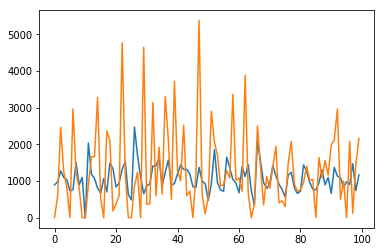

In [204]:
plt.plot(out.data[100:200].numpy())
plt.plot(out1[100:200])

# 

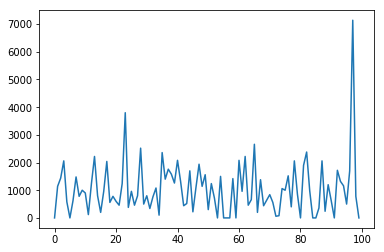

In [96]:
plt.plot(train_y[:100])


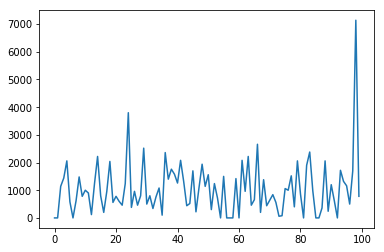

In [94]:
plt.plot(train_x[:100, 1])

In [93]:
train_x.shape

(2589, 5)

In [178]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn import model_selection

In [198]:
mlp = MLPRegressor()
mlp = mlp.fit(train_x, train_y)
out = mlp.predict(test_x)

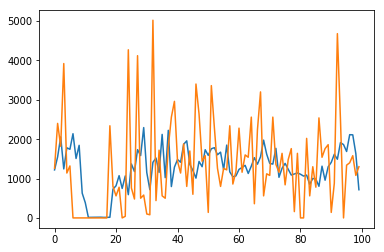

In [199]:
plt.plot(out[:100])
plt.plot(test_y[:100])